In [1]:
#===================================================================
# Imports y espacio de búsqueda
#===================================================================

import numpy as np
import json
from ultralytics import YOLO

# Definir espacio de hiperparámetros
param_space = {
    "lr0": (1e-4, 1e-2),
    "momentum": (0.85, 0.98),
    "weight_decay": (1e-6, 1e-3),
    "hsv_s": (0.0, 0.7),
    "scale": (0.0, 1.0),
    "translate": (0.0, 0.2)
}
param_keys = list(param_space.keys())
dim = len(param_keys)

def sample_particle():
    return np.array([np.random.uniform(low, high) for low, high in param_space.values()])

In [2]:
#===================================================================
# Baseline (con Hiperparámetros por defecto)
#===================================================================

def run_baseline_training(epochs=5, imgsz=640):
    """
    Entrena un modelo YOLOv8 con hiperparámetros por defecto
    para establecer una línea de base (baseline) de rendimiento.

    Retorna:
        float: El score mAP50-95 del modelo baseline.
    """
    print("--- Iniciando Entrenamiento Baseline ---")
    print(f"Entrenando con {epochs} épocas y tamaño de imagen {imgsz}...")
    
    model = YOLO("yolov8n.pt")

    # Entrena con los valores por defecto, guardando en una carpeta específica
    model.train(
        data="data.yaml",
        epochs=epochs,
        imgsz=imgsz,
        verbose=True, # Mantenlo en True para ver el progreso claramente
        name='baseline_training' # Nombra la carpeta de resultados para claridad
    ) 

    # Valida y obtén las métricas
    metrics = model.val()
    baseline_map = metrics.box.map

    print("\n--- Entrenamiento Baseline Finalizado ---")
    print(f"Baseline mAP50-95: {baseline_map:.4f}")
    
    return baseline_map

In [3]:
#====================================================================
# Función de evaluación (fitness)
#====================================================================

def evaluate_particle(position, epochs=5, imgsz=640):
    """Entrena YOLO con hiperparámetros de una partícula y devuelve fitness."""
    cfg = {k: float(v) for k, v in zip(param_keys, position)}

    overrides = dict(
        data="data.yaml",
        epochs=epochs,
        imgsz=imgsz,
        batch=16,
        optimizer="AdamW",
        lr0=cfg["lr0"],
        momentum=cfg["momentum"],
        weight_decay=cfg["weight_decay"],
        hsv_s=cfg["hsv_s"],
        scale=cfg["scale"],
        translate=cfg["translate"],
        #device=0,
        verbose=False
    )

    model = YOLO("yolov8n.pt")
    model.train(**overrides)
    metrics = model.val()

    fitness = metrics.box.map  # mAP50-95
    return fitness, cfg, metrics


In [4]:
#===================================================================
# Metaheurísticas
#===================================================================

# PSO
def iterarPSO(maxIter, iter, dim, population, best, pBest, vel, ub0):
    Vmax = ub0 * 0.1
    wMax, wMin = 0.9, 0.1
    c1, c2 = 2, 2

    w = wMax - iter * ((wMax - wMin) / maxIter)
    r1 = np.random.rand(population.shape[0], dim)
    r2 = np.random.rand(population.shape[0], dim)

    vel = (
        w * vel
        + c1 * r1 * (pBest - population)
        + c2 * r2 * (best - population)
    )
    vel = np.clip(vel, -Vmax, Vmax)
    population = population + vel
    return population, vel

# WOA
import math, random
def iterarWOA(maxIter, iter, dim, population, best):
    a = 2 - (2 * iter / maxIter)
    b = 1
    new_population = []

    for individual in population:
        p = random.uniform(0, 1)
        r = random.uniform(0, 1)
        l = random.uniform(-1, 1)
        A = 2 * a * r - a
        C = 2 * random.uniform(0, 1)

        if p < 0.5:
            if abs(A) < 1:  # encircle best
                D = [abs(C * best[j] - individual[j]) for j in range(dim)]
                new_individual = [best[j] - A * D[j] for j in range(dim)]
            else:  # random search
                rand_idx = random.randint(0, len(population) - 1)
                rand_ind = population[rand_idx]
                D = [abs(C * rand_ind[j] - individual[j]) for j in range(dim)]
                new_individual = [rand_ind[j] - A * D[j] for j in range(dim)]
        else:  # spiral update
            D_prime = [best[j] - individual[j] for j in range(dim)]
            spiral_component = math.exp(b * l) * math.cos(2 * math.pi * l)
            new_individual = [D_prime[j] * spiral_component + best[j] for j in range(dim)]

        new_population.append(new_individual)
    return np.array(new_population)

# GWO
def iterarGWO(maxIter, iter, dim, population, fitness):
    population = np.array(population)
    fitness = np.array(fitness)

    # Parámetro 'a' decrece linealmente de 2 a 0
    a = 2 - iter * (2 / maxIter)

    # Ordenar posiciones según fitness (descendente para maximizar)
    sorted_indices = np.argsort(fitness)[::-1]

    # Alpha, Beta, Delta wolves
    Xalfa = population[sorted_indices[0]]
    Xbeta = population[sorted_indices[1]]
    Xdelta = population[sorted_indices[2]]

    # Random values para todos los cálculos
    r1 = np.random.uniform(0.0, 1.0, (population.shape[0], dim, 3))
    r2 = np.random.uniform(0.0, 1.0, (population.shape[0], dim, 3))

    # Calcular A y C
    A = 2 * a * r1 - a
    C = 2 * r2

    # Distancias a los 3 lobos líderes
    d_alfa = np.abs(C[:, :, 0] * Xalfa - population)
    d_beta = np.abs(C[:, :, 1] * Xbeta - population)
    d_delta = np.abs(C[:, :, 2] * Xdelta - population)

    # Actualización de posiciones
    X1 = Xalfa - A[:, :, 0] * d_alfa
    X2 = Xbeta - A[:, :, 1] * d_beta
    X3 = Xdelta - A[:, :, 2] * d_delta

    # Promedio de las 3 guías
    population = (X1 + X2 + X3) / 3

    return population

#FA
def iterarFA(maxIter, iter, dim, population, fitness, alpha=0.5, beta0=1.0, gamma=1.0):
    """
    Implementación simple del Firefly Algorithm para tu marco de optimización.
    - population: matriz (n_individuos, dim)
    - fitness: lista o array con el valor de cada individuo
    - alpha: factor de aleatoriedad
    - beta0: atractividad base
    - gamma: coeficiente de absorción de luz
    """
    n_fireflies = population.shape[0]
    new_population = np.copy(population)
    fitness = np.array(fitness)

    # Ordenar luciérnagas por brillo (fitness)
    sorted_indices = np.argsort(fitness)[::-1]  # descendente (mayor fitness = más brillo)
    population = population[sorted_indices]
    fitness = fitness[sorted_indices]

    # Actualizar cada luciérnaga según las más brillantes
    for i in range(n_fireflies):
        for j in range(n_fireflies):
            if fitness[j] > fitness[i]:  # luciérnaga j más brillante
                r = np.linalg.norm(population[i] - population[j])
                beta = beta0 * np.exp(-gamma * (r ** 2))
                e = np.random.randn(dim)
                # Movimiento
                new_population[i] += beta * (population[j] - population[i]) + alpha * e

    # Retornar nueva población
    return new_population

In [5]:
#===================================================================
# Loop general de optimización
#===================================================================

def run_metaheuristic(name="PSO", n_particles=4, max_iter=3, epochs=5):
    population = np.array([sample_particle() for _ in range(n_particles)])
    vel = np.zeros_like(population)
    pBest, pBest_scores = np.copy(population), np.full(n_particles, -np.inf)
    gBest, gBest_score = None, -np.inf

    history = []

    for it in range(max_iter):
        print(f"\nIteración {it+1}/{max_iter}")
        for i, particle in enumerate(population):
            fitness, cfg, metrics = evaluate_particle(particle, epochs=epochs)

            if fitness > pBest_scores[i]:
                pBest[i] = particle
                pBest_scores[i] = fitness
            if fitness > gBest_score:
                gBest, gBest_score = particle, fitness

            history.append({"iter": it, "particle": i, "fitness": fitness, "cfg": cfg})

        # Elegir algoritmo
        if name == "PSO":
            ub0 = np.array([high for _, high in param_space.values()])
            population, vel = iterarPSO(max_iter, it, dim, population, gBest, pBest, vel, ub0)
        elif name == "WOA":
            population = iterarWOA(max_iter, it, dim, population, gBest)
        elif name == "GWO":
            current_fitness = [h["fitness"] for h in history if h["iter"] == it]
            population = iterarGWO(max_iter, it, dim, population, current_fitness)
        elif name == "FA":
            current_fitness = [h["fitness"] for h in history if h["iter"] == it]
            population = iterarFA(max_iter, it, dim, population, current_fitness)
            
        # Clipping a los rangos definidos
        for i in range(population.shape[0]):
            for j, (low, high) in enumerate(param_space.values()):
                population[i, j] = np.clip(population[i, j], low, high)

        print(f"  Mejor global hasta ahora: {gBest_score:.4f}")

    with open(f"{name}_results.json", "w") as f:
        json.dump(history, f, indent=4)

    return gBest, gBest_score, history


In [6]:
#===================================================================
# Ejecución Maestra del Experimento
#===================================================================

# --- CONFIGURACIÓN DEL EXPERIMENTO ---
# Define aquí todos los algoritmos que quieres probar
algorithms_to_test = ["PSO", "WOA", "GWO", "FA"]
num_particles = 10
num_iterations = 10
num_epochs = 5

# Diccionario para guardar todos los resultados
all_results = {}


# --- PASO 1: Establecer la línea de base (baseline) UNA SOLA VEZ ---
print("INICIANDO EXPERIMENTO: OBTENIENDO BASELINE\n" + "="*50)
baseline_score = run_baseline_training(epochs=num_epochs)
print(f"\nEl score a superar es: {baseline_score:.4f}\n")


# --- PASO 2: Bucle para ejecutar cada metaheurística ---
for algo_name in algorithms_to_test:
    print(f"\nINICIANDO OPTIMIZACIÓN CON '{algo_name}'\n" + "="*50)
    
    best_cfg, best_score, hist = run_metaheuristic(
        name=algo_name, 
        n_particles=num_particles, 
        max_iter=num_iterations,
        epochs=num_epochs
    )
    
    # Guarda los resultados de este algoritmo
    all_results[algo_name] = {
        'score': best_score,
        'config': dict(zip(param_keys, best_cfg)) # Guardamos como dict para más claridad
    }
    print(f"--- Optimización con '{algo_name}' finalizada. Mejor score: {best_score:.4f} ---")


# --- PASO 3: Mostrar un resumen final comparativo ---
print("\n\n" + "="*60)
print("--- RESUMEN FINAL DEL EXPERIMENTO ---")
print("="*60)

print(f"\nBaseline mAP50-95 (Default): {baseline_score:.4f}")
print("-" * 30)

# Imprimir los resultados de cada algoritmo y su mejora
for algo_name, result in all_results.items():
    score = result['score']
    improvement = ((score - baseline_score) / baseline_score) * 100
    
    print(f"\nAlgoritmo: {algo_name}")
    print(f"  - Mejor mAP50-95: {score:.4f}")
    print(f"  - Mejora sobre Baseline: {improvement:.2f}%")
    print("  - Mejor Configuración:")
    for k, v in result['config'].items():
        print(f"    {k}: {v:.6f}")

print("\n" + "="*60)
print("--- FIN DEL EXPERIMENTO ---")
print("="*60)

INICIANDO EXPERIMENTO: OBTENIENDO BASELINE
--- Iniciando Entrenamiento Baseline ---
Entrenando con 5 épocas y tamaño de imagen 640...
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mo

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 44.222.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\baseline_training\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0004, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\baseline_training
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.529      3.384      1.174        265        640: 100%|██████████| 169/169 [01:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

                   all        300       2568      0.518      0.162      0.129     0.0758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.436      2.202      1.155        269        640: 100%|██████████| 169/169 [00:55<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568      0.524      0.208      0.187      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.69G      1.426      1.968      1.151        193        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


                   all        300       2568      0.553      0.234      0.222      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.6G      1.367      1.825      1.132        131        640: 100%|██████████| 169/169 [00:53<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


                   all        300       2568      0.578      0.251      0.253      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.337      1.744      1.113        176        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


                   all        300       2568      0.589      0.257       0.26      0.161

5 epochs completed in 0.083 hours.
Optimizer stripped from runs\detect\baseline_training\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\baseline_training\weights\best.pt, 6.2MB

Validating runs\detect\baseline_training\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


                   all        300       2568       0.59      0.257       0.26      0.161
               bicycle         30         32      0.127     0.0312     0.0686     0.0205
                   bus        220        425      0.639      0.492      0.571      0.384
                   car        232        842      0.601      0.732      0.713      0.473
               minibus          2          2          1          0    0.00841    0.00673
               minivan         87        110      0.361       0.21      0.265      0.175
             motorbike        166        335      0.403      0.442      0.365     0.0989
                pickup        105        142       0.38      0.164      0.227      0.143
             policecar          1          1          1          0          0          0
              rickshaw         62        192      0.452      0.604      0.578      0.371
               scooter          1          1          1          0          0          0
                   su

val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.78it/s]


                   all        300       2568       0.59      0.257       0.26      0.161
               bicycle         30         32      0.127     0.0312     0.0686     0.0205
                   bus        220        425      0.639      0.492      0.571      0.384
                   car        232        842      0.601      0.732      0.713      0.473
               minibus          2          2          1          0    0.00841    0.00673
               minivan         87        110      0.361       0.21      0.265      0.175
             motorbike        166        335      0.403      0.442      0.365     0.0989
                pickup        105        142       0.38      0.164      0.227      0.143
             policecar          1          1          1          0          0          0
              rickshaw         62        192      0.452      0.604      0.578      0.371
               scooter          1          1          1          0          0          0
                   su

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 180.851.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: AdamW(lr=0.005533253688880516, momentum=0.9429746176284145) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006031606126955723), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G       1.68       2.68      1.326        249        640: 100%|██████████| 169/169 [00:57<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]

                   all        300       2568       0.28      0.116     0.0588     0.0289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.659      2.182       1.35        255        640: 100%|██████████| 169/169 [00:57<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300       2568      0.385      0.147      0.103     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.626      2.004      1.325        186        640: 100%|██████████| 169/169 [00:52<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.471      0.152      0.142     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.5G       1.54      1.817      1.276        133        640: 100%|██████████| 169/169 [00:51<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568      0.533      0.207      0.205      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G       1.46      1.659      1.223        177        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300       2568      0.556      0.232      0.252      0.149



5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 388.2110.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.06it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train2
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.26840906317804436, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 243.8164.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: AdamW(lr=0.004432113391500656, momentum=0.9659304901016703) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009636990977405284), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G       1.74      2.823      1.331        301        640: 100%|██████████| 169/169 [00:54<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.264     0.0911     0.0477      0.023

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.704      2.243      1.342        277        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        300       2568      0.606      0.126      0.123     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.679      2.072      1.327        205        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300       2568      0.528      0.182      0.154     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.91G      1.606      1.905      1.285        123        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568       0.55      0.182      0.201       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.13G      1.534      1.761      1.233        172        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


                   all        300       2568      0.615      0.211      0.215      0.124

5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 6.2MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train3
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 323.7109.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train32
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06099050979107849, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 194.3135.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train4\labels.jpg... 
optimizer: AdamW(lr=0.005723641154829931, momentum=0.9703275629780459) with parameter groups 57 weight(decay=0.0), 64 weight(decay=7.196502213968905e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.674      2.757      1.349        233        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


                   all        300       2568      0.335      0.126     0.0571      0.029

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.08G      1.642        2.2      1.371        233        640: 100%|██████████| 169/169 [00:50<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        300       2568      0.457      0.129       0.11     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.05G      1.611       2.03      1.336        155        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300       2568      0.591      0.128      0.131     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.546      1.871        1.3        166        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300       2568      0.526      0.217      0.192      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.05G      1.455      1.724      1.244        182        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568       0.55      0.215      0.224      0.136



5 epochs completed in 0.076 hours.
Optimizer stripped from runs\detect\train4\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train4\weights\best.pt, 6.2MB

Validating runs\detect\train4\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train4
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 390.297.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.48it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train42
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5594109949517064, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 226.8133.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train5\labels.jpg... 
optimizer: AdamW(lr=0.0078037518344035205, momentum=0.9631015792720865) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009786397238905312), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.77G      1.745      2.765      1.375        259        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300       2568      0.341       0.11     0.0665     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.51G      1.719      2.266      1.408        271        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        300       2568      0.434      0.164      0.111     0.0576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.686      2.104      1.374        194        640: 100%|██████████| 169/169 [00:46<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.469      0.134      0.117     0.0632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.51G      1.604      1.931      1.328        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300       2568      0.635      0.181      0.196      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.515      1.783      1.274        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568       0.52      0.224      0.222      0.127



5 epochs completed in 0.071 hours.
Optimizer stripped from runs\detect\train5\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train5\weights\best.pt, 6.2MB

Validating runs\detect\train5\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train5
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 383.891.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.96it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train52
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6612682419347087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 202.5124.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: AdamW(lr=0.001270916816102439, momentum=0.9331897327725781) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00014420993412163737), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.595       2.73      1.238        269        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.399      0.146      0.121     0.0683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.493      2.003      1.218        270        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.569       0.17      0.189      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.94G      1.483      1.806      1.209        197        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.649      0.202      0.216      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.415      1.654       1.18        131        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568       0.55      0.257      0.239       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.361      1.532      1.147        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.507      0.282      0.271      0.163



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 6.2MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train6
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 339.095.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.84it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train62
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.39790376420805396, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 192.8104.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: AdamW(lr=0.002719100559835807, momentum=0.9506503796264482) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004566941818843321), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train7
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.584      2.678       1.27        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568       0.34      0.126     0.0754     0.0428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.19G      1.529      2.035      1.282        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.484      0.164      0.152     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.493      1.859      1.252        154        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.508      0.195      0.167     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.437        1.7      1.226        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.546      0.242      0.224      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.05G       1.37      1.558      1.184        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.592      0.233      0.284      0.177



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 6.2MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.592      0.233      0.284      0.177
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train7
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 323.693.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        300       2568      0.592      0.233      0.284      0.177
Speed: 0.5ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train72
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.47727420937243836, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 275.9193.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train8\labels.jpg... 
optimizer: AdamW(lr=0.006159747654951973, momentum=0.9302014195937184) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009438043304361097), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train8
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.689      2.658      1.334        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.285      0.134       0.07     0.0353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.63G      1.668      2.188      1.373        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.327     0.0726     0.0417     0.0189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.631      2.012      1.337        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.523      0.112      0.114     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.36G      1.542      1.825      1.289        139        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.451      0.179      0.184      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.458      1.649      1.238        169        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.575      0.236      0.243      0.144



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train8\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train8\weights\best.pt, 6.2MB

Validating runs\detect\train8\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.576      0.236      0.243      0.144
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train8
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 303.865.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


                   all        300       2568      0.576      0.236      0.243      0.144
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train82
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.46944650873271154, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 144.7124.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train9\labels.jpg... 
optimizer: AdamW(lr=0.007006548839679923, momentum=0.8578293113118051) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006670999487302221), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train9
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.705      2.671      1.364        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


                   all        300       2568      0.177     0.0424     0.0227     0.0111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.683       2.23      1.406        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.522     0.0999        0.1     0.0532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.61G       1.63      2.024       1.35        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

                   all        300       2568      0.525      0.138      0.121     0.0595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.532      1.829      1.304        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.466      0.187      0.189      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.04G      1.433      1.638       1.24        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.559      0.267      0.268      0.153



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 6.2MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568       0.56      0.266      0.268      0.153
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train9
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 336.165.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.51it/s]


                   all        300       2568       0.56      0.266      0.268      0.153
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train92
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.30702105942362423, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 198.8113.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: AdamW(lr=0.0032227406741494203, momentum=0.8972824002225409) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005706265736474619), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train10
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.716      2.774      1.303        281        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.479      0.138     0.0815     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G        1.7      2.232      1.339        262        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568       0.41       0.17      0.146     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.91G      1.655       2.05      1.298        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.426      0.182      0.157      0.083



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.44G      1.594      1.869      1.269        115        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.493      0.219      0.207      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.12G      1.516      1.708      1.219        150        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.644      0.233      0.251       0.15



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train10\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train10\weights\best.pt, 6.2MB

Validating runs\detect\train10\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.644      0.233      0.251       0.15
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train10
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 405.8101.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.55it/s]


                   all        300       2568      0.644      0.233      0.251       0.15
Speed: 0.5ms preprocess, 2.5ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train102
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.17730412177784746, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 231.557.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train11\labels.jpg... 
optimizer: AdamW(lr=0.0021678798853388636, momentum=0.8709702373250495) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006534552171399331), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train11
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.72G      1.594      2.616      1.241        264        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.322      0.161     0.0974       0.05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.525      1.982      1.244        257        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

                   all        300       2568      0.489      0.128      0.122     0.0685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.506      1.787       1.23        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.598      0.197       0.19      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.65G      1.435      1.633      1.197        135        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.437      0.234       0.22      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.363      1.487      1.155        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.601      0.286      0.279      0.168



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train11\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train11\weights\best.pt, 6.2MB

Validating runs\detect\train11\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.601      0.286      0.279      0.168
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train11
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 325.385.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]


                   all        300       2568      0.601      0.286      0.279      0.168
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train112
  Mejor global hasta ahora: 0.1767

Iteración 2/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3859742681663782, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 280.0173.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train12\labels.jpg... 
optimizer: AdamW(lr=0.0046385241864025685, momentum=0.9446690442565676) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005031606126955722), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train12
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.41G      1.656      2.674      1.311        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.279      0.132     0.0719     0.0361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G      1.615       2.13      1.337        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


                   all        300       2568      0.544      0.123      0.111     0.0585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.584      1.957      1.307        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.584      0.181      0.173     0.0936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.35G      1.509      1.787      1.263        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568       0.56      0.222      0.222      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.431      1.632      1.215        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.666      0.214      0.259      0.153



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train12\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train12\weights\best.pt, 6.2MB

Validating runs\detect\train12\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.666      0.214      0.259      0.153
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train12
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 398.996.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


                   all        300       2568      0.666      0.214      0.259      0.153
Speed: 0.5ms preprocess, 2.9ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train122
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2932975323774217, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 317.3175.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train13\labels.jpg... 
optimizer: AdamW(lr=0.003432113391500656, momentum=0.9629630536588644) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008636990977405283), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train13
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.678      2.772      1.284        291        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.286      0.069      0.046     0.0239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.637      2.155      1.302        280        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.464      0.131      0.118     0.0642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.52G      1.619      1.994      1.286        206        640: 100%|██████████| 169/169 [00:48<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.501      0.205      0.164     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.52G      1.554       1.83       1.25        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


                   all        300       2568      0.522      0.214      0.207      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.12G      1.481      1.694      1.206        181        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.522      0.253      0.239      0.142



5 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train13\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train13\weights\best.pt, 6.2MB

Validating runs\detect\train13\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.521      0.252      0.239      0.142
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train13
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 287.5105.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.84it/s]


                   all        300       2568      0.521      0.252      0.239      0.142
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train132
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.08739628303471754, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 277.6193.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train14\labels.jpg... 
optimizer: AdamW(lr=0.004723641154829931, momentum=0.9465242505952145) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00017196502213968906), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train14
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.646      2.681      1.315        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.445     0.0956     0.0767     0.0416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.617      2.125      1.346        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.526      0.147      0.119     0.0625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G       1.57      1.948      1.307        154        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568      0.621      0.178      0.155     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.505       1.79      1.276        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.519      0.213      0.197      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G       1.42      1.624      1.221        181        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.556      0.242      0.269      0.163



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train14\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train14\weights\best.pt, 6.2MB

Validating runs\detect\train14\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.557      0.243       0.27      0.163
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train14
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 355.478.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]


                   all        300       2568      0.557      0.243       0.27      0.163
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train142
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4894109949517064, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 301.7173.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train15\labels.jpg... 
optimizer: AdamW(lr=0.0068037518344035205, momentum=0.9601449742077455) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008786397238905311), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train15
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.717      2.731      1.353        246        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


                   all        300       2568      0.271      0.125     0.0543     0.0256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.692      2.241      1.384        251        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.507      0.115      0.105     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.653       2.06      1.355        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.415      0.184      0.139     0.0774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.575      1.897      1.313        133        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.583      0.191      0.188      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.489      1.731      1.255        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568       0.54      0.215      0.248      0.155



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train15\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train15\weights\best.pt, 6.2MB

Validating runs\detect\train15\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568       0.54      0.215      0.248      0.155
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train15
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 414.897.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.02it/s]


                   all        300       2568       0.54      0.215      0.248      0.155
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train152
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6117870548281643, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 177.1101.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train16\labels.jpg... 
optimizer: AdamW(lr=0.002270916816102439, momentum=0.9424574771326221) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00024420993412163736), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train16
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.606      2.672      1.256        249        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.356      0.156     0.0774     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.48G      1.535      2.023      1.258        249        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.523      0.144      0.149     0.0821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.86G      1.526       1.84      1.242        187        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.485      0.207      0.174      0.099



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.55G      1.441      1.687      1.208        135        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.561      0.245      0.251      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.381      1.545      1.171        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.532      0.261       0.29      0.176



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train16\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train16\weights\best.pt, 6.2MB

Validating runs\detect\train16\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.533      0.259       0.29      0.176
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train16
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 391.1115.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


                   all        300       2568      0.533      0.259       0.29      0.176
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train162
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.39790376420805396, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 258.6149.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train17\labels.jpg... 
optimizer: AdamW(lr=0.002719100559835807, momentum=0.9506503796264482) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004566941818843321), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train17
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.584      2.678       1.27        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568       0.34      0.126     0.0754     0.0428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.08G      1.529      2.035      1.282        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.484      0.164      0.152     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.82G      1.493      1.859      1.252        154        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.508      0.195      0.167     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.33G      1.437        1.7      1.226        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.546      0.242      0.224      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.05G       1.37      1.558      1.184        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.592      0.233      0.284      0.177



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train17\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train17\weights\best.pt, 6.2MB

Validating runs\detect\train17\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.592      0.233      0.284      0.177
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train17
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 353.6106.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.90it/s]


                   all        300       2568      0.592      0.233      0.284      0.177
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train172
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4765288453011159, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 200.2165.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train18\labels.jpg... 
optimizer: AdamW(lr=0.005159747654951973, momentum=0.931023776410407) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008438043304361097), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train18
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.661      2.667      1.325        245        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.353     0.0894     0.0519     0.0258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.632      2.153      1.356        228        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.476       0.12     0.0947     0.0524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.598      1.972      1.322        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.598      0.141      0.129     0.0716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.514      1.792      1.277        146        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.549      0.225      0.216      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.429      1.627      1.224        169        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.548      0.239      0.249      0.151



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train18\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train18\weights\best.pt, 6.2MB

Validating runs\detect\train18\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.548      0.239      0.249       0.15
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train18
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 363.8137.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


                   all        300       2568      0.548      0.239      0.249       0.15
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train182
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.39944650873271154, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 208.9184.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train19\labels.jpg... 
optimizer: AdamW(lr=0.006006548839679923, momentum=0.955829311311805) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000567099948730222), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train19
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.52G      1.676      2.739      1.344        229        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.399      0.088     0.0554     0.0265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.27G      1.654      2.203      1.374        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

                   all        300       2568       0.47      0.102     0.0986     0.0529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.23G      1.609       2.02      1.335        161        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.609      0.169       0.15     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.534      1.858      1.299        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.596      0.164      0.196      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.03G      1.448      1.702      1.242        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568       0.54      0.242      0.231      0.136



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train19\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train19\weights\best.pt, 6.2MB

Validating runs\detect\train19\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.539       0.24      0.231      0.136
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train19
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 396.6101.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.85it/s]


                   all        300       2568      0.539       0.24      0.231      0.136
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train192
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.37702105942362424, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 163.8109.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train20\labels.jpg... 
optimizer: AdamW(lr=0.002998034956220643, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00047062657364746187), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train20
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.54G      1.736      2.898      1.306        296        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300       2568      0.338     0.0943      0.054     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.683      2.285      1.323        271        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.472      0.136      0.126     0.0675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.668      2.108        1.3        207        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.485      0.172      0.146     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.622      1.968      1.276        117        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.488      0.188      0.178     0.0982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.547      1.856      1.237        158        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.511      0.192      0.187      0.105



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train20\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train20\weights\best.pt, 6.2MB

Validating runs\detect\train20\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.513      0.192      0.187      0.106
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train20
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 394.7100.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]


                   all        300       2568      0.513      0.192      0.187      0.106
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train202
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.24730412177784744, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 215.2127.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train21\labels.jpg... 
optimizer: AdamW(lr=0.003065044251499946, momentum=0.9341575050330679) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005534552171399331), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train21
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.621      2.665      1.274        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.261     0.0942     0.0581      0.026



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.551      2.034      1.275        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.462      0.121       0.11     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.533      1.858       1.26        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.478      0.189      0.148     0.0845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.21G       1.47      1.703      1.226        139        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.547      0.243      0.248      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.397      1.551      1.183        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.659      0.254      0.295      0.178



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train21\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train21\weights\best.pt, 6.2MB

Validating runs\detect\train21\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.658      0.254      0.295      0.178
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train21
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 330.785.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]


                   all        300       2568      0.658      0.254      0.295      0.178
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train212
  Mejor global hasta ahora: 0.1782

Iteración 3/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35138652083876654, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 328.1168.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train22\labels.jpg... 
optimizer: AdamW(lr=0.0036385241864025685, momentum=0.9437380488403574) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00048718028687014356), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train22
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.38G      1.616      2.687      1.289        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]

                   all        300       2568      0.432     0.0896     0.0723     0.0391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.577       2.09      1.312        229        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.473      0.134      0.129     0.0695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.549      1.904      1.289        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568       0.49      0.185       0.17      0.097



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.35G      1.472      1.742      1.253        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.527      0.223      0.226       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.397      1.592      1.202        169        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.569      0.241      0.266       0.16



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train22\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train22\weights\best.pt, 6.2MB

Validating runs\detect\train22\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568       0.57      0.241      0.266       0.16
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train22
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 410.693.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]


                   all        300       2568       0.57      0.241      0.266       0.16
Speed: 0.5ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train222
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3048662900564463, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 164.9123.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train23\labels.jpg... 
optimizer: AdamW(lr=0.002432113391500656, momentum=0.9549356447327957) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007636990977405283), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train23
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.639      2.729      1.262        276        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.307      0.113      0.074     0.0371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.73G      1.559      2.062      1.257        275        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.554      0.155      0.158     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.561      1.885      1.252        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.521      0.204      0.184      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.69G      1.486      1.719      1.214        127        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.535      0.242      0.228      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.424      1.597      1.178        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.667      0.252       0.27      0.163



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train23\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train23\weights\best.pt, 6.2MB

Validating runs\detect\train23\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.668      0.251       0.27      0.163
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train23
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 319.2113.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.48it/s]


                   all        300       2568      0.668      0.251       0.27      0.163
Speed: 0.5ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train232
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.12158188742350792, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 189.8120.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train24\labels.jpg... 
optimizer: AdamW(lr=0.0037236411548299308, momentum=0.9120455931471102) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00027196502213968905), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train24
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.607      2.631      1.292        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.64it/s]

                   all        300       2568       0.42     0.0625     0.0658     0.0328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G      1.572      2.063      1.316        228        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.504      0.159      0.142     0.0754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.25G      1.541      1.884      1.282        153        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.472      0.202       0.18      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.463       1.71      1.247        154        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.559      0.239      0.215      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.374      1.536      1.192        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.575      0.256      0.268      0.157



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train24\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train24\weights\best.pt, 6.2MB

Validating runs\detect\train24\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.575      0.256      0.268      0.157
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train24
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 395.0100.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.92it/s]


                   all        300       2568      0.575      0.256      0.268      0.157
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train242
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4194109949517064, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 171.3101.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train25\labels.jpg... 
optimizer: AdamW(lr=0.0058037518344035205, momentum=0.9515496921819794) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007786397238905311), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train25
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.675      2.703      1.332        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568      0.204     0.0576     0.0317     0.0153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.655      2.186      1.368        241        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


                   all        300       2568      0.508      0.119      0.104     0.0549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.632      1.996      1.348        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.536      0.165      0.142     0.0768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.543      1.852      1.298        134        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300       2568      0.538      0.203      0.204      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.459      1.698      1.241        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.555      0.237      0.244      0.145



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train25\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train25\weights\best.pt, 6.2MB

Validating runs\detect\train25\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.555      0.236      0.244      0.145
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train25
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 415.9100.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.555      0.236      0.244      0.145
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train252
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5417870548281644, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 202.4103.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train26\labels.jpg... 
optimizer: AdamW(lr=0.003270916816102439, momentum=0.9456515767672337) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00034420993412163735), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train26
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.39G      1.616      2.681       1.28        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.486      0.117     0.0857     0.0479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G       1.58      2.068      1.296        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.421      0.151      0.142     0.0768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.546      1.874      1.271        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568      0.506      0.187      0.171     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.32G      1.472      1.733      1.237        141        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.558      0.243      0.226      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.05G      1.399      1.584      1.194        168        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.505      0.236      0.252       0.15



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train26\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train26\weights\best.pt, 6.2MB

Validating runs\detect\train26\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.504      0.236      0.252       0.15
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train26
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 370.3123.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.00it/s]


                   all        300       2568      0.504      0.236      0.252       0.15
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train262
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.32790376420805395, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.61.3 ms, read: 138.3110.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train27\labels.jpg... 
optimizer: AdamW(lr=0.002939514398756984, momentum=0.9286353482283257) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00048219997710578056), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train27
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.595      2.645      1.281        241        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.363      0.132     0.0958     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.538      2.038      1.293        229        640: 100%|██████████| 169/169 [00:45<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.542      0.135       0.12     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.26G      1.512      1.838      1.265        157        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.567      0.187      0.164     0.0934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.444      1.676      1.228        156        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.505      0.217      0.225      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.81G      1.357      1.523      1.177        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.564       0.28      0.277      0.167



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train27\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train27\weights\best.pt, 6.2MB

Validating runs\detect\train27\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.563       0.28      0.277      0.167
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train27
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 345.2105.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.38it/s]


                   all        300       2568      0.563       0.28      0.277      0.167
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train272
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.47376500829853807, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 279.2156.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train28\labels.jpg... 
optimizer: AdamW(lr=0.004159747654951973, momentum=0.9318241321861301) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007438043304361096), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train28
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.38G      1.628      2.663      1.296        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.305      0.119     0.0774     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G        1.6      2.095      1.328        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.471      0.119      0.111     0.0578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.568      1.914      1.298        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.502      0.175      0.163     0.0896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.28G      1.492      1.747      1.259        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.544      0.224      0.217      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.416      1.592      1.207        168        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.631      0.242      0.277       0.17



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train28\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train28\weights\best.pt, 6.2MB

Validating runs\detect\train28\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.631      0.243      0.277       0.17
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train28
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 217.963.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]


                   all        300       2568      0.631      0.243      0.277       0.17
Speed: 0.6ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train282
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.32944650873271153, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 317.7184.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train29\labels.jpg... 
optimizer: AdamW(lr=0.005006548839679923, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006116649520682148), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train29
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.38G      1.679      2.799      1.335        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        300       2568      0.335      0.178     0.0694     0.0342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.63G      1.634      2.231      1.362        229        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568      0.462      0.143      0.121     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.38G      1.605       2.03      1.333        163        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.509       0.17      0.164     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.545      1.897      1.303        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568       0.59        0.2      0.188      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.81G       1.47      1.767      1.251        164        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.548       0.21       0.21      0.121



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train29\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train29\weights\best.pt, 6.2MB

Validating runs\detect\train29\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.551      0.209       0.21      0.121
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train29
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 210.755.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.551      0.209       0.21      0.121
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train292
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.30702105942362423, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 284.5165.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train30\labels.jpg... 
optimizer: AdamW(lr=0.0029854304616040725, momentum=0.9128366524984004) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005706265736474619), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train30
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      1.671      2.683      1.269        301        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.319      0.161      0.104     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.38G      1.625        2.1      1.285        269        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.392      0.134      0.111     0.0569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.27G       1.61      1.918      1.264        206        640: 100%|██████████| 169/169 [00:48<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568       0.77      0.135       0.16     0.0837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.08G      1.551      1.766      1.234        121        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.507      0.217      0.223      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.12G      1.465      1.618      1.185        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.524      0.269      0.262      0.154



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train30\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train30\weights\best.pt, 6.2MB

Validating runs\detect\train30\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.525      0.269      0.262      0.154
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train30
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 302.8106.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        300       2568      0.525      0.269      0.262      0.154
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train302
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.30470412177784745, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.81.6 ms, read: 286.3151.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train31\labels.jpg... 
optimizer: AdamW(lr=0.0038007190317520343, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00047145521713993306), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train31
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.657      2.816      1.318        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


                   all        300       2568       0.29      0.147     0.0787     0.0376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.606      2.202      1.338        230        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.437      0.184       0.12     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.587      1.997      1.315        168        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.524      0.164      0.156     0.0841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.28G       1.53      1.857      1.288        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568       0.52      0.226      0.194      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.455       1.73      1.239        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.621      0.218      0.223      0.131



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train31\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train31\weights\best.pt, 6.2MB

Validating runs\detect\train31\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.622      0.217      0.224      0.131
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train31
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 399.172.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.46it/s]


                   all        300       2568      0.622      0.217      0.224      0.131
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train312
  Mejor global hasta ahora: 0.1782

Iteración 4/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29702676164496994, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.4 ms, read: 275.3159.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train33\labels.jpg... 
optimizer: AdamW(lr=0.0027161924534415093, momentum=0.940934204482041) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005623512413109476), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train33
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.589      2.669      1.262        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.335       0.13      0.065     0.0362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.535      2.034      1.275        228        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.509     0.0899     0.0854     0.0478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.61G      1.518      1.841      1.256        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.509      0.195      0.164     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.439      1.674      1.218        152        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.659      0.212       0.23      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.81G      1.369      1.546      1.176        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.644      0.253      0.268      0.161



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train33\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train33\weights\best.pt, 6.2MB

Validating runs\detect\train33\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.643      0.253      0.268      0.161
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train33
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 294.983.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.643      0.253      0.268      0.161
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train332
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.302363905285929, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 219.4124.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train34\labels.jpg... 
optimizer: AdamW(lr=0.0027313772935431526, momentum=0.9449601943806049) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006636990977405283), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train34
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.46G      1.627      2.681      1.264        266        640: 100%|██████████| 169/169 [00:45<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.353      0.135     0.0833     0.0451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.3G      1.564      2.055      1.272        268        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.526      0.137      0.124     0.0688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.68G      1.548      1.873      1.259        190        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.631      0.179      0.191      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.64G      1.477      1.708      1.225        131        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.464      0.239      0.223      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.408      1.572      1.183        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568       0.58      0.254      0.273      0.171



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train34\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train34\weights\best.pt, 6.2MB

Validating runs\detect\train34\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568       0.58      0.254      0.273      0.171
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train34
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 351.188.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.81it/s]


                   all        300       2568       0.58      0.254      0.273      0.171
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train342
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.15077565273392812, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 233.2107.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train35\labels.jpg... 
optimizer: AdamW(lr=0.0028331466210670315, momentum=0.9771066271635697) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00037196502213968904), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train35
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.15G      1.626      2.788      1.288        241        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


                   all        300       2568        0.3      0.145       0.09     0.0479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.47G      1.563      2.149      1.304        226        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.461      0.183      0.127      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.24G      1.539      1.952      1.286        159        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.532      0.195      0.189      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.474      1.792       1.25        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.553      0.227      0.216      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.415      1.678      1.206        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.564      0.226      0.232      0.135



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train35\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train35\weights\best.pt, 6.2MB

Validating runs\detect\train35\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.565      0.226      0.232      0.135
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train35
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 396.393.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.97it/s]


                   all        300       2568      0.565      0.226      0.232      0.135
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train352
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3494109949517064, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 228.4119.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train36\labels.jpg... 
optimizer: AdamW(lr=0.0049979825271903, momentum=0.9560153136273294) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007571536215234451), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train36
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.664      2.673      1.315        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.317      0.115     0.0967     0.0495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.637      2.135      1.348        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


                   all        300       2568      0.456      0.177      0.157      0.085

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.614      1.967      1.329        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.605      0.167      0.166     0.0914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.52G      1.524      1.804      1.279        139        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.524      0.219      0.205      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.449       1.66      1.233        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.658      0.213      0.247      0.145



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train36\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train36\weights\best.pt, 6.2MB

Validating runs\detect\train36\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.658      0.214      0.246      0.144
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train36
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 283.191.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.95it/s]


                   all        300       2568      0.658      0.214      0.246      0.144
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train362
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5669129489343245, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 224.9148.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train37\labels.jpg... 
optimizer: AdamW(lr=0.0035410725753945533, momentum=0.9378264558033378) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00044420993412163734), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train37
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.89G      1.632      2.666      1.284        246        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.308       0.12     0.0827     0.0417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.47G      1.584      2.095      1.302        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568       0.46      0.158      0.121      0.066



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.562      1.902      1.283        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.593      0.182      0.179        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.8G      1.491      1.743      1.245        135        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.638      0.215      0.223      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.408      1.591      1.195        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.644      0.246      0.262      0.156



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train37\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train37\weights\best.pt, 6.2MB

Validating runs\detect\train37\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.644      0.245      0.262      0.156
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train37
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 378.5104.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.18it/s]


                   all        300       2568      0.644      0.245      0.262      0.156
Speed: 0.4ms preprocess, 3.5ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train372
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.25790376420805394, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 282.5147.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train38\labels.jpg... 
optimizer: AdamW(lr=0.0030659770307937986, momentum=0.9538048725010161) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004965878882854568), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train38
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.15G      1.601      2.701      1.278        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.329     0.0945     0.0592      0.032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.63G      1.559      2.084      1.299        228        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.596      0.146      0.142     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.535      1.908      1.278        162        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.515      0.201      0.183      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.33G       1.46      1.732      1.246        152        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.497      0.229      0.217      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.389       1.59      1.196        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


                   all        300       2568      0.634      0.253      0.261      0.155

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train38\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train38\weights\best.pt, 6.2MB

Validating runs\detect\train38\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


                   all        300       2568      0.634      0.253      0.261      0.155
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train38
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 166.747.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.78it/s]


                   all        300       2568      0.634      0.253      0.261      0.155
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train382
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4695930855142285, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 265.7136.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train39\labels.jpg... 
optimizer: AdamW(lr=0.003159747654951973, momentum=0.9325102322647502) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006438043304361096), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train39
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.629      2.673      1.272        252        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.381      0.168        0.1     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.569      2.049      1.284        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.511      0.166      0.162     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.84G      1.545      1.868      1.266        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.593      0.199      0.185      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.81G      1.478      1.713       1.23        134        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.512      0.234      0.223      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.398      1.566      1.183        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.595      0.238      0.264      0.161



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train39\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train39\weights\best.pt, 6.2MB

Validating runs\detect\train39\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.595      0.239      0.264      0.161
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train39
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 298.689.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.92it/s]


                   all        300       2568      0.595      0.239      0.264      0.161
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train392
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3707712348045302, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 222.9117.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train40\labels.jpg... 
optimizer: AdamW(lr=0.004202308489081963, momentum=0.8969359774752411) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006896077667347185), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train40
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.38G      1.634      2.624      1.298        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


                   all        300       2568      0.466     0.0984     0.0951     0.0483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.604        2.1      1.328        230        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.457      0.122      0.101     0.0526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G       1.57      1.904      1.301        172        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.652      0.173      0.179     0.0968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.486      1.728      1.258        144        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.612      0.225      0.227      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.403      1.558      1.203        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.627      0.244      0.284      0.172



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train40\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train40\weights\best.pt, 6.2MB

Validating runs\detect\train40\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.627      0.245      0.284      0.172
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train40
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 315.281.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.93it/s]


                   all        300       2568      0.627      0.245      0.284      0.172
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train402
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.23702105942362423, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 148.1111.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train41\labels.jpg... 
optimizer: AdamW(lr=0.0030116238840491674, momentum=0.9037626177014245) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006292710750878478), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train41
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.52G       1.66      2.651      1.265        294        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.358      0.117     0.0665      0.034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.612      2.067      1.276        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568       0.49      0.144      0.127     0.0662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.581      1.889      1.256        208        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.569      0.193      0.169     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.89G      1.511       1.73      1.223        124        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.447      0.204      0.193      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.12G      1.443       1.58      1.182        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.517      0.251      0.264      0.158



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train41\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train41\weights\best.pt, 6.2MB

Validating runs\detect\train41\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.517      0.251      0.265      0.159
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train41
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 322.253.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


                   all        300       2568      0.517      0.251      0.265      0.159
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train412
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2513721200276839, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 304.5190.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train43\labels.jpg... 
optimizer: AdamW(lr=0.0028404065815004096, momentum=0.9671987476634281) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005714552171399331), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train43
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.629      2.763      1.274        240        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.362      0.144     0.0889      0.049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.562      2.103      1.287        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.464      0.108      0.102     0.0549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.548      1.907      1.277        181        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.518      0.193      0.174     0.0996



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.4G      1.486      1.766      1.247        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.542      0.226      0.222      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.414       1.63      1.198        174        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.631      0.252      0.248      0.146



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train43\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train43\weights\best.pt, 6.2MB

Validating runs\detect\train43\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.631      0.252      0.248      0.146
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train43
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 395.9104.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.89it/s]


                   all        300       2568      0.631      0.252      0.248      0.146
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train432
  Mejor global hasta ahora: 0.1782

Iteración 5/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2474076783256977, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 167.5145.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train44\labels.jpg... 
optimizer: AdamW(lr=0.0022183671598698914, momentum=0.9375877088889353) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006002866234578081), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train44
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.582      2.674      1.254        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.392      0.115      0.107       0.06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G       1.52      2.011      1.262        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568        0.5      0.189      0.155     0.0888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G        1.5      1.828      1.243        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.506      0.221      0.225      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.431      1.662      1.211        146        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.424      0.241      0.221      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.359      1.525      1.164        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.497      0.262      0.264      0.162



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train44\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train44\weights\best.pt, 6.2MB

Validating runs\detect\train44\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.497      0.263      0.264      0.162
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train44
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 371.092.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.38it/s]


                   all        300       2568      0.497      0.263      0.264      0.162
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train442
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29013001626916174, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 209.8180.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train45\labels.jpg... 
optimizer: AdamW(lr=0.0034767680959041664, momentum=0.936278487312875) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005636990977405282), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train45
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G       1.62      2.634      1.278        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568       0.37      0.128     0.0787     0.0461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.572      2.058      1.291        241        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.443       0.16      0.135     0.0738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.552      1.865      1.271        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.582      0.191      0.176     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G      1.483      1.724      1.242        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.561      0.213      0.216      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.405      1.568      1.192        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.636      0.261      0.273      0.164



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train45\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train45\weights\best.pt, 6.2MB

Validating runs\detect\train45\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


                   all        300       2568      0.632      0.263      0.273      0.164
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train45
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 356.6108.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        300       2568      0.632      0.263      0.273      0.164
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train452
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.16656461282701238, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.5 ms, read: 171.7118.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train46\labels.jpg... 
optimizer: AdamW(lr=0.0038331466210670315, momentum=0.9114778515338597) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00047196502213968903), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train46
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.622      2.628      1.291        241        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.433      0.148     0.0817     0.0412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.594      2.091      1.317        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.461      0.127      0.105     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.64G      1.554      1.892      1.286        169        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.594      0.184      0.169     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.45G      1.478       1.72      1.245        134        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.545      0.225      0.217      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.399      1.559      1.195        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.549      0.267      0.257      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train46\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train46\weights\best.pt, 6.2MB

Validating runs\detect\train46\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.546       0.27      0.257      0.151
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train46
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 310.276.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]


                   all        300       2568      0.546       0.27      0.257      0.151
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train462
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4194109949517064, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 236.0160.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train47\labels.jpg... 
optimizer: AdamW(lr=0.0059979825271903, momentum=0.9609580780159861) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008512045176400656), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train47
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.697      2.724      1.333        245        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.357      0.109     0.0687      0.033



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.663      2.212      1.366        247        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.488       0.11     0.0803     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G       1.64      2.059      1.338        187        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568       0.63      0.161      0.156     0.0869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.72G      1.567      1.871      1.296        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.483      0.188      0.175     0.0991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.485      1.723      1.248        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.619      0.219      0.227      0.133



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train47\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train47\weights\best.pt, 6.2MB

Validating runs\detect\train47\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.625      0.216      0.226      0.133
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train47
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 318.375.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.93it/s]


                   all        300       2568      0.625      0.216      0.226      0.133
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train472
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6082299521490223, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 272.7168.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train48\labels.jpg... 
optimizer: AdamW(lr=0.002879484809014155, momentum=0.9366414498104092) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005442099341216374), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train48
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.615      2.676      1.262        255        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.414      0.114     0.0731     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.42G       1.56      2.037      1.276        247        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568       0.49      0.157      0.143     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.84G      1.538      1.855      1.257        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568       0.58      0.195      0.184     0.0983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.81G      1.476      1.708       1.23        134        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.556      0.247      0.244      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.397       1.56      1.182        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.607      0.228      0.264      0.159



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train48\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train48\weights\best.pt, 6.2MB

Validating runs\detect\train48\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.607      0.228      0.264      0.159
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train48
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 373.685.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]


                   all        300       2568      0.607      0.228      0.264      0.159
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train482
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.32790376420805395, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 191.9105.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train49\labels.jpg... 
optimizer: AdamW(lr=0.002965311824695106, momentum=0.9393064152337116) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00048467883957493334), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train49
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.605      2.655      1.269        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.443      0.145      0.102     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.549       2.04      1.286        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.497      0.154      0.137     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.64G      1.536      1.871      1.266        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568       0.58      0.213      0.191      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.36G      1.456      1.693      1.232        135        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.483      0.249      0.244      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.385      1.548      1.183        171        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.568      0.245      0.254      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train49\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train49\weights\best.pt, 6.2MB

Validating runs\detect\train49\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.568      0.244      0.254      0.152
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train49
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 323.736.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.93it/s]


                   all        300       2568      0.568      0.244      0.254      0.152
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train492
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.47044111468367306, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 153.996.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train50\labels.jpg... 
optimizer: AdamW(lr=0.0036128495582065127, momentum=0.9321827466156658) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006167659529080437), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train50
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.63G      1.628      2.662       1.29        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.456      0.124     0.0898      0.047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G       1.59       2.08       1.31        238        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.486       0.14      0.129     0.0646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.564      1.903      1.286        181        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.395      0.184      0.141     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.489      1.737      1.253        141        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.483      0.212      0.214      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.05G      1.399      1.584      1.196        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.545      0.228      0.269      0.162



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train50\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train50\weights\best.pt, 6.2MB

Validating runs\detect\train50\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.545      0.228      0.269      0.162
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train50
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 300.6139.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]


                   all        300       2568      0.545      0.228      0.269      0.162
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train502
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3007712348045302, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 235.6129.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train51\labels.jpg... 
optimizer: AdamW(lr=0.0032023084890819634, momentum=0.9137419775047283) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006733132749946913), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train51
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.609      2.629      1.261        247        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.352      0.135     0.0727     0.0406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.51G      1.563      2.033      1.283        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.521      0.163      0.148     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.542      1.851      1.265        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.593       0.19      0.183      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.8G      1.474      1.704      1.232        134        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.615      0.224      0.243      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.392      1.546      1.183        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.598      0.275      0.289      0.172



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train51\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train51\weights\best.pt, 6.2MB

Validating runs\detect\train51\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.597      0.276      0.289      0.172
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train51
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 405.598.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


                   all        300       2568      0.597      0.276      0.289      0.172
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train512
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.20822840573597604, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 222.7119.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train53\labels.jpg... 
optimizer: AdamW(lr=0.003052745748437293, momentum=0.9556911524562072) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006001780576581393), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train53
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.5G      1.658      2.714      1.281        277        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568       0.36      0.135     0.0852     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.584      2.091      1.284        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


                   all        300       2568      0.455      0.158      0.118     0.0657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.99G      1.579      1.932      1.278        207        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.538      0.186      0.182      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.71G       1.51      1.757      1.239        127        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568       0.56      0.232      0.211       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.441      1.624      1.195        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.531      0.271      0.241      0.147



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train53\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train53\weights\best.pt, 6.2MB

Validating runs\detect\train53\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568       0.53      0.271      0.241      0.148
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train53
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 369.7108.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.05it/s]


                   all        300       2568       0.53      0.271      0.241      0.148
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train532
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.20938298522379556, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 285.8180.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train54\labels.jpg... 
optimizer: AdamW(lr=0.0026660628320840825, momentum=0.9218881025079296) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005822236023271769), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train54
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.607      2.658      1.257        245        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.318      0.162      0.105     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.51G       1.54      2.019      1.263        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.544       0.13      0.124     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.531      1.844      1.254        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.607      0.187      0.194      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.81G      1.453      1.662      1.214        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.572      0.252       0.24      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.378      1.523      1.171        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568       0.61      0.247      0.276      0.166



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train54\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train54\weights\best.pt, 6.2MB

Validating runs\detect\train54\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568       0.61      0.247      0.276      0.166
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train54
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 342.364.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        300       2568       0.61      0.247      0.276      0.166
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train542
  Mejor global hasta ahora: 0.1782

Iteración 6/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.21859999050169296, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 285.4187.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train55\labels.jpg... 
optimizer: AdamW(lr=0.0021988202990756117, momentum=0.9348895229753066) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005608154697376025), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train55
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.61G      1.589      2.666      1.249        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.414      0.162      0.095     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G       1.52      2.013      1.257        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.514      0.157      0.149     0.0846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.497      1.814      1.238        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.535      0.205      0.182      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.2G      1.431      1.661      1.209        139        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568       0.52      0.257      0.238      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G       1.36      1.519      1.165        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.535      0.262      0.276      0.167



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train55\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train55\weights\best.pt, 6.2MB

Validating runs\detect\train55\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.535      0.262      0.276      0.167
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train55
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 394.791.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.88it/s]


                   all        300       2568      0.535      0.262      0.276      0.167
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train552
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2841853220564069, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 263.5137.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train56\labels.jpg... 
optimizer: AdamW(lr=0.002580702818615862, momentum=0.9463154209703851) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006636990977405283), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train56
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.607      2.679      1.254        255        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568      0.384      0.162      0.107     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.42G      1.549      2.031      1.269        250        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.477      0.171       0.14     0.0784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.84G       1.53      1.851      1.248        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.576      0.152      0.156     0.0896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G      1.459      1.692      1.219        134        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568       0.55      0.241      0.226      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.392       1.56      1.177        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.573      0.274      0.273      0.158



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train56\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train56\weights\best.pt, 6.2MB

Validating runs\detect\train56\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.573      0.274      0.273      0.158
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train56
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 384.661.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.51it/s]


                   all        300       2568      0.573      0.274      0.273      0.158
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train562
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.16825445362127708, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 244.9152.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train57\labels.jpg... 
optimizer: AdamW(lr=0.00392432276156297, momentum=0.9657261935962663) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005719650221396891), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train57
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.657      2.738      1.307        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

                   all        300       2568      0.289      0.119     0.0604     0.0255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.611       2.14       1.32        251        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568       0.39      0.152      0.112     0.0593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.586      1.967        1.3        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.546       0.16      0.168     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.514      1.805      1.268        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.509       0.23      0.208       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.446      1.662      1.219        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.49      0.248      0.236      0.141



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train57\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train57\weights\best.pt, 6.2MB

Validating runs\detect\train57\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


                   all        300       2568      0.488      0.248      0.236      0.141
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train57
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 292.4117.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.52it/s]


                   all        300       2568      0.488      0.248      0.236      0.141
Speed: 0.5ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train572
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.42929817662692904, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 188.9114.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train58\labels.jpg... 
optimizer: AdamW(lr=0.006094890338856202, momentum=0.9560461191856396) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007700926910362655), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train58
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.91G      1.697      2.705      1.332        249        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

                   all        300       2568      0.238     0.0856     0.0354     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G      1.678      2.215      1.365        250        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.451      0.141      0.113     0.0617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.644       2.03      1.336        187        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.526      0.166       0.15     0.0823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.55G      1.559      1.859      1.296        135        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.529       0.19        0.2      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.476      1.721      1.245        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.566      0.224      0.242      0.143



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train58\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train58\weights\best.pt, 6.2MB

Validating runs\detect\train58\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.566      0.224      0.242      0.143
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train58
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 394.892.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        300       2568      0.566      0.224      0.242      0.143
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train582
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5711032689830597, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 228.3137.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train59\labels.jpg... 
optimizer: AdamW(lr=0.002562084344494261, momentum=0.9420793169427485) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005258731143623535), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train59
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.603      2.686      1.261        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        300       2568       0.49     0.0749     0.0674     0.0352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G      1.539      2.041      1.266        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.458      0.123      0.114     0.0607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.518      1.853       1.25        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.553      0.184      0.191      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.35G      1.452      1.683      1.217        139        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.549      0.232      0.229      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G       1.38      1.543      1.178        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.663      0.248      0.274      0.169



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train59\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train59\weights\best.pt, 6.2MB

Validating runs\detect\train59\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.663       0.25      0.274      0.169
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train59
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 292.080.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        300       2568      0.663       0.25      0.274      0.169
Speed: 0.5ms preprocess, 2.9ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train592
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3326130840196929, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 235.9166.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train60\labels.jpg... 
optimizer: AdamW(lr=0.002840196170859344, momentum=0.9415901966010517) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004703703286117301), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train60
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.613      2.665      1.268        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.415      0.153      0.113     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.558      2.042      1.279        246        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.398      0.132      0.114     0.0594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.537      1.858       1.26        187        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.572      0.197      0.184      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.69G      1.458      1.696      1.222        135        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.588      0.216      0.225      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.389      1.555      1.181        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.579       0.26      0.271      0.164



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train60\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train60\weights\best.pt, 6.2MB

Validating runs\detect\train60\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


                   all        300       2568      0.578       0.26      0.271      0.164
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train60
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 369.1120.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]


                   all        300       2568      0.578       0.26      0.271      0.164
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train602
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4733700990035701, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 256.6142.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train61\labels.jpg... 
optimizer: AdamW(lr=0.003902566837377992, momentum=0.9316297371646702) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007167659529080438), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train61
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.38G      1.625      2.644      1.287        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.312      0.149      0.104     0.0536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.597      2.076      1.312        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.419      0.163      0.155     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.565      1.901      1.289        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.654       0.17      0.178      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.487      1.729      1.256        141        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.595      0.213      0.227      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.407      1.572      1.202        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568       0.59      0.264      0.266      0.163



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train61\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train61\weights\best.pt, 6.2MB

Validating runs\detect\train61\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.591      0.263      0.266      0.162
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train61
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 341.5104.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]


                   all        300       2568      0.591      0.263      0.266      0.162
Speed: 0.5ms preprocess, 2.7ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train612
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29244959791013103, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 272.6158.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train63\labels.jpg... 
optimizer: AdamW(lr=0.0038157391870934634, momentum=0.9607523324264724) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006259615819250484), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train63
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.638      2.715      1.296        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.299      0.171     0.0899      0.048



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.7G      1.591      2.109      1.312        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.477       0.15      0.154     0.0922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.581      1.941      1.296        186        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568       0.52      0.177      0.172     0.0935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.38G       1.51      1.774       1.26        138        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.523       0.23      0.223      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G       1.43      1.635       1.21        169        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.473      0.246      0.245      0.142



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train63\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train63\weights\best.pt, 6.2MB

Validating runs\detect\train63\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.535      0.246      0.244      0.142
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train63
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 298.8104.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.59it/s]


                   all        300       2568      0.535      0.246      0.244      0.142
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train632
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.278228405735976, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 196.6139.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train64\labels.jpg... 
optimizer: AdamW(lr=0.0030561415663251617, momentum=0.9070034452013133) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005746996611955821), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train64
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.46G      1.626      2.619      1.262        266        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.344      0.118     0.0702     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.32G      1.575      2.041      1.283        268        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.518      0.145      0.141     0.0748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.66G      1.553      1.849      1.265        190        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568       0.53      0.185      0.182      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.63G      1.472      1.686      1.224        130        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.511      0.233      0.237      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.402      1.536       1.18        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.583      0.243      0.274      0.163



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train64\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train64\weights\best.pt, 6.2MB

Validating runs\detect\train64\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.583      0.244      0.274      0.163
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train64
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 275.270.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.583      0.244      0.274      0.163
Speed: 0.5ms preprocess, 2.9ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train642
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.24832455389013255, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 275.8170.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train65\labels.jpg... 
optimizer: AdamW(lr=0.003380999765126868, momentum=0.9092960482058342) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005001956896553977), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train65
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.38G       1.61      2.631      1.281        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.356      0.163      0.101     0.0526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.573      2.055      1.299        232        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.504      0.162      0.132     0.0699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.542      1.874      1.271        174        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.563      0.192      0.182      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.468      1.702      1.233        144        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


                   all        300       2568      0.557      0.251      0.262      0.148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.05G      1.383      1.539      1.185        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.606      0.288      0.295      0.177



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train65\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train65\weights\best.pt, 6.2MB

Validating runs\detect\train65\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.607      0.285      0.295      0.177
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train65
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 379.898.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


                   all        300       2568      0.607      0.285      0.295      0.177
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train652
  Mejor global hasta ahora: 0.1782

Iteración 7/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.21212898974096475, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 175.2159.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train66\labels.jpg... 
optimizer: AdamW(lr=0.0024644533907998175, momentum=0.9333788368510735) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005314183897459216), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train66
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.595      2.652      1.249        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.373      0.146     0.0922     0.0526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.537       2.02      1.257        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.517      0.161       0.16     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.519      1.831      1.245        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.485      0.196      0.166     0.0934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.4G      1.443      1.671       1.21        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.568      0.221      0.212      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.374      1.523      1.167        170        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.565      0.269      0.277      0.164



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train66\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train66\weights\best.pt, 6.2MB

Validating runs\detect\train66\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.565      0.269      0.277      0.164
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train66
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 354.6135.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.90it/s]


                   all        300       2568      0.565      0.269      0.277      0.164
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train662
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2880653728213111, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 257.1178.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train67\labels.jpg... 
optimizer: AdamW(lr=0.0030598187012208793, momentum=0.9465556805367276) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005636990977405282), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train67
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.619      2.674      1.278        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.351      0.122     0.0788     0.0448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.51G      1.561      2.064      1.285        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.508      0.166      0.155     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.543      1.873      1.269        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.651      0.191      0.191      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.57G      1.473       1.71      1.231        136        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300       2568      0.574      0.215      0.226      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.401      1.579      1.188        175        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.555      0.281      0.281       0.17



5 epochs completed in 0.071 hours.
Optimizer stripped from runs\detect\train67\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train67\weights\best.pt, 6.2MB

Validating runs\detect\train67\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


                   all        300       2568      0.555      0.281      0.281       0.17
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train67
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 349.686.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


                   all        300       2568      0.555      0.281      0.281       0.17
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train672
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.16120470640868548, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 308.4197.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train68\labels.jpg... 
optimizer: AdamW(lr=0.003199388138470754, momentum=0.9191154971631935) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005377689261852112), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train68
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.609      2.619       1.27        246        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

                   all        300       2568      0.366      0.118     0.0851      0.046



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.64G      1.567      2.031       1.29        250        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300       2568      0.546        0.1        0.1     0.0548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.552      1.862      1.273        185        640: 100%|██████████| 169/169 [01:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568       0.58      0.188      0.171     0.0963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.45G      1.465        1.7       1.23        132        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568      0.506      0.229      0.233      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.398      1.543      1.189        179        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.596      0.245      0.284      0.172



5 epochs completed in 0.080 hours.
Optimizer stripped from runs\detect\train68\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train68\weights\best.pt, 6.2MB

Validating runs\detect\train68\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


                   all        300       2568      0.596      0.245      0.284      0.172
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train68
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 393.791.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.596      0.245      0.284      0.172
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train682
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3795343103401448, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 207.0175.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train69\labels.jpg... 
optimizer: AdamW(lr=0.0054520365236435005, momentum=0.9555246766379266) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008042148669757485), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train69
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.691       2.72      1.325        245        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        300       2568      0.319      0.135     0.0945     0.0501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.654      2.172      1.349        247        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


                   all        300       2568      0.484      0.131      0.127     0.0705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.619      1.989      1.329        186        640: 100%|██████████| 169/169 [00:57<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300       2568      0.602      0.175      0.171     0.0922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.73G      1.537      1.827      1.288        138        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


                   all        300       2568      0.627      0.185      0.199      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G       1.46      1.671       1.23        177        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.495      0.231      0.244      0.142



5 epochs completed in 0.078 hours.
Optimizer stripped from runs\detect\train69\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train69\weights\best.pt, 6.2MB

Validating runs\detect\train69\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


                   all        300       2568      0.496      0.232      0.244      0.142
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train69
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 388.291.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]


                   all        300       2568      0.496      0.232      0.244      0.142
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\train692
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5685696286884118, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 253.2108.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train70\labels.jpg... 
optimizer: AdamW(lr=0.0029044643971639257, momentum=0.9410775045587204) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046481458200129863), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train70
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.621      2.667      1.272        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


                   all        300       2568       0.38      0.145      0.104     0.0576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.555      2.053      1.278        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568       0.51      0.143      0.139     0.0803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.544      1.879      1.265        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.571      0.185      0.176      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G      1.476      1.724      1.236        135        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.477      0.235      0.227      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.395      1.568      1.185        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.59      0.256      0.268      0.164



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train70\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train70\weights\best.pt, 6.2MB

Validating runs\detect\train70\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.587      0.255      0.268      0.164
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train70
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 308.464.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


                   all        300       2568      0.587      0.255      0.268      0.164
Speed: 0.5ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train702
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2869763614351777, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 287.0164.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train71\labels.jpg... 
optimizer: AdamW(lr=0.0028568245319671665, momentum=0.9468401741390439) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00047264013679608745), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train71
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.616       2.69       1.27        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.295      0.165     0.0819     0.0425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.557      2.057      1.285        247        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.497      0.164      0.151     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.545      1.871      1.274        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.541       0.18      0.187      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.52G      1.467      1.717      1.235        138        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.483      0.212      0.225      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.397       1.57      1.187        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.582      0.244       0.26      0.157



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train71\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train71\weights\best.pt, 6.2MB

Validating runs\detect\train71\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.581      0.244       0.26      0.157
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train71
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 344.984.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]


                   all        300       2568      0.581      0.244       0.26      0.157
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train712
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4732501306827297, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.71.4 ms, read: 250.1139.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train73\labels.jpg... 
optimizer: AdamW(lr=0.0033798283741441845, momentum=0.9316947446526261) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006167659529080437), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train73
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.621       2.65      1.271        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.437      0.137     0.0895     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G      1.574       2.07       1.29        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.474      0.111      0.103     0.0534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.555      1.884      1.269        186        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.556      0.178      0.163     0.0931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.483      1.722       1.24        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568       0.49      0.224      0.228      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.402      1.573      1.189        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.617      0.257      0.265      0.159



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train73\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train73\weights\best.pt, 6.2MB

Validating runs\detect\train73\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.618      0.257      0.265      0.159
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train73
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 372.8128.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.618      0.257      0.265      0.159
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train732
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3413178965078641, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 212.7162.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train74\labels.jpg... 
optimizer: AdamW(lr=0.0035580072868371033, momentum=0.9253922931835283) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006510876782516059), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train74
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.38G      1.613       2.65      1.282        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


                   all        300       2568      0.435      0.107     0.0905     0.0473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G       1.57      2.053      1.297        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.433      0.138      0.134      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G       1.55      1.881      1.276        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.533      0.176      0.175     0.0953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.17G      1.475      1.716      1.243        144        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


                   all        300       2568      0.501      0.256      0.255      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.394      1.552      1.192        164        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.588      0.267      0.281      0.167



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train74\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train74\weights\best.pt, 6.2MB

Validating runs\detect\train74\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.588      0.267      0.281      0.167
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train74
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 381.496.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.93it/s]


                   all        300       2568      0.588      0.267      0.281      0.167
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train742
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2608792414717364, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 228.2145.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train75\labels.jpg... 
optimizer: AdamW(lr=0.0030618115263564487, momentum=0.9344015989006209) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005429626027804974), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train75
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.616      2.654      1.267        240        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.64it/s]

                   all        300       2568      0.428      0.073     0.0642     0.0334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.552      2.048      1.279        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.421      0.167      0.137     0.0747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.535      1.846      1.264        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.666      0.189      0.191      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.61G      1.467      1.703      1.231        136        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.567      0.225      0.229      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.395      1.553      1.186        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.516      0.273      0.268      0.158



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train75\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train75\weights\best.pt, 6.2MB

Validating runs\detect\train75\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.518      0.272      0.268      0.158
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train75
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 393.788.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]


                   all        300       2568      0.518      0.272      0.268      0.158
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train752
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.26609210544281786, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 250.8143.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train76\labels.jpg... 
optimizer: AdamW(lr=0.0030922288899097924, momentum=0.9307362209998612) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006001956896553978), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train76
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.625      2.652      1.267        248        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.283      0.132      0.071     0.0398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.51G      1.569      2.065      1.287        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.57      0.131      0.125     0.0685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.544      1.877      1.267        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.478      0.196      0.178        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.81G      1.471      1.712      1.232        134        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.594      0.211       0.21      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.393      1.557      1.186        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.484      0.273      0.252      0.156



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train76\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train76\weights\best.pt, 6.2MB

Validating runs\detect\train76\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.484      0.273      0.252      0.156
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train76
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 377.0114.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.484      0.273      0.252      0.156
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train762
  Mejor global hasta ahora: 0.1782

Iteración 8/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.226184255522688, hsv

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 169.3128.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train77\labels.jpg... 
optimizer: AdamW(lr=0.002475404591801172, momentum=0.9350770932038669) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005834374262675405), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train77
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.592      2.657      1.255        242        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.305      0.154     0.0875     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G      1.532      2.009      1.265        239        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.504      0.163      0.161     0.0892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.514      1.815      1.248        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.514      0.206      0.181      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.21G      1.441       1.66      1.216        139        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.526      0.244      0.236      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.365      1.521      1.172        167        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.563      0.268      0.263      0.157



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train77\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train77\weights\best.pt, 6.2MB

Validating runs\detect\train77\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.564      0.268      0.263      0.157
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train77
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 369.3108.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]


                   all        300       2568      0.564      0.268      0.263      0.157
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train772
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29282611349491044, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 280.3179.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train78\labels.jpg... 
optimizer: AdamW(lr=0.0029821841354198955, momentum=0.9414032092824645) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006636990977405283), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train78
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.626      2.667      1.268        263        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.475      0.136     0.0944     0.0497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.44G      1.565      2.032      1.279        256        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.541      0.139      0.139      0.076



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.553       1.86       1.26        186        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.606      0.187      0.192      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.63G      1.483      1.714      1.229        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.566      0.238      0.223      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.403      1.568      1.181        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.617      0.263      0.278      0.167



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train78\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train78\weights\best.pt, 6.2MB

Validating runs\detect\train78\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568       0.62      0.262      0.279      0.167
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train78
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 366.1127.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.68it/s]


                   all        300       2568       0.62      0.262      0.279      0.167
Speed: 0.5ms preprocess, 2.8ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\train782
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.16499190458480736, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 191.6129.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train79\labels.jpg... 
optimizer: AdamW(lr=0.0026324718343133714, momentum=0.9177351867974295) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005465991730816723), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train79
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.594      2.628      1.263        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.332      0.124     0.0935     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.535       2.01      1.272        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.527      0.148      0.136     0.0755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.527      1.824      1.259        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.582        0.2      0.176     0.0981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.49G      1.449      1.662       1.22        135        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.469      0.257      0.245      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.371       1.52      1.175        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.506       0.26       0.27      0.162



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train79\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train79\weights\best.pt, 6.2MB

Validating runs\detect\train79\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.505      0.262       0.27      0.162
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train79
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 411.997.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]


                   all        300       2568      0.505      0.262       0.27      0.162
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train792
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4246951257717206, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 256.6165.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train80\labels.jpg... 
optimizer: AdamW(lr=0.005871961984201684, momentum=0.958271349706105) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008047385396230165), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train80
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.686      2.723      1.338        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.381     0.0986     0.0651     0.0341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G       1.66      2.193      1.371        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.467       0.11      0.092       0.05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.626      2.011      1.346        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.475      0.186      0.162     0.0861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.7G      1.547      1.844      1.298        138        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.521      0.219      0.194      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.465      1.692      1.244        176        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568       0.54      0.227      0.229      0.137



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train80\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train80\weights\best.pt, 6.2MB

Validating runs\detect\train80\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568      0.538      0.228      0.229      0.137
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train80
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 337.5123.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.91it/s]


                   all        300       2568      0.538      0.228      0.229      0.137
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train802
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5887981264463843, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 301.7190.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train81\labels.jpg... 
optimizer: AdamW(lr=0.0030803686244299257, momentum=0.9387498999723907) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004686832750158113), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train81
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.9G      1.621      2.659      1.272        244        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.353      0.149     0.0877     0.0487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.47G      1.584      2.072      1.291        241        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.642       0.14       0.14     0.0737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G       1.55      1.887      1.268        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.575      0.186      0.173     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.57G      1.477      1.718      1.227        136        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.566      0.241      0.238      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.402      1.571      1.186        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.571      0.244      0.265      0.158



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train81\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train81\weights\best.pt, 6.2MB

Validating runs\detect\train81\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.571      0.244      0.265      0.158
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train81
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 343.992.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.91it/s]


                   all        300       2568      0.571      0.244      0.265      0.158
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train812
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.33708213211182547, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 208.9211.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train83\labels.jpg... 
optimizer: AdamW(lr=0.002923601819997599, momentum=0.9380160535950856) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00048034846065121906), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train83
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.617      2.674      1.272        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.269      0.109     0.0578     0.0313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.562      2.048       1.28        241        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.464      0.161      0.158      0.091



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.539      1.871      1.261        183        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


                   all        300       2568       0.55      0.162      0.157     0.0823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.5G      1.469      1.712      1.231        136        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300       2568      0.488      0.232      0.224      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.396       1.56      1.181        176        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.611      0.213      0.267      0.159



5 epochs completed in 0.074 hours.
Optimizer stripped from runs\detect\train83\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train83\weights\best.pt, 6.2MB

Validating runs\detect\train83\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


                   all        300       2568       0.61      0.213      0.267      0.159
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train83
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 318.8108.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]


                   all        300       2568       0.61      0.213      0.267      0.159
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train832
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.47178000379677326, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 199.088.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train84\labels.jpg... 
optimizer: AdamW(lr=0.003745798812080995, momentum=0.9319807350701453) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007095887959727181), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train84
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G       1.63      2.653      1.285        243        640: 100%|██████████| 169/169 [00:51<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568      0.314      0.152     0.0895     0.0484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G       1.59      2.072      1.305        239        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.487      0.125      0.105     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.569      1.908      1.284        181        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


                   all        300       2568       0.52       0.15      0.129     0.0723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.33G      1.491      1.728      1.247        139        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.538      0.223      0.214      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G       1.41      1.578        1.2        168        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300       2568      0.577      0.258      0.248      0.147



5 epochs completed in 0.076 hours.
Optimizer stripped from runs\detect\train84\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train84\weights\best.pt, 6.2MB

Validating runs\detect\train84\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        300       2568      0.577      0.258      0.247      0.147
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train84
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 348.4104.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


                   all        300       2568      0.577      0.258      0.247      0.147
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train842
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2930141783217394, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 220.1117.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train85\labels.jpg... 
optimizer: AdamW(lr=0.0036238821718337696, momentum=0.9239810595070751) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006644357012396458), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train85
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.62G      1.626      2.638      1.285        242        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.429      0.124     0.0796     0.0419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.585      2.068      1.306        240        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300       2568      0.488      0.133      0.131     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.552      1.885      1.279        184        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300       2568      0.566      0.179      0.156     0.0878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.19G      1.478      1.718      1.243        139        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.569      0.218      0.233      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.401      1.567      1.195        167        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300       2568      0.595      0.212      0.248       0.15



5 epochs completed in 0.076 hours.
Optimizer stripped from runs\detect\train85\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train85\weights\best.pt, 6.2MB

Validating runs\detect\train85\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


                   all        300       2568      0.598       0.21      0.248       0.15
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train85
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 342.598.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]


                   all        300       2568      0.598       0.21      0.248       0.15
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train852
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2458311338104771, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 164.860.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train86\labels.jpg... 
optimizer: AdamW(lr=0.003062058300490419, momentum=0.925513695863514) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005752088030041545), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train86
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G       1.63      2.637      1.269        267        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.331      0.157      0.112     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.71G      1.576      2.042      1.283        267        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300       2568      0.471      0.146       0.12     0.0643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.66G      1.547      1.839      1.265        188        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568      0.522      0.183      0.178      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.64G      1.479      1.698       1.23        130        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300       2568      0.538      0.235      0.239      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.401       1.55      1.182        176        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300       2568       0.58      0.259      0.305      0.193



5 epochs completed in 0.076 hours.
Optimizer stripped from runs\detect\train86\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train86\weights\best.pt, 6.2MB

Validating runs\detect\train86\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


                   all        300       2568      0.581       0.26      0.304      0.193
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train86
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 356.9118.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.32it/s]


                   all        300       2568      0.581       0.26      0.304      0.193
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train862
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2421949096410166, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 313.6173.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train87\labels.jpg... 
optimizer: AdamW(lr=0.002915343045210635, momentum=0.9435579824497101) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005001956896553977), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train87
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.38G      1.604      2.671      1.268        243        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568       0.46      0.112     0.0815     0.0417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.549      2.039      1.283        234        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.445      0.139      0.105      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.535      1.866      1.269        182        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.533      0.189      0.197      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.19G      1.461      1.708      1.235        142        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300       2568      0.593      0.233      0.263      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.385      1.557      1.186        165        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.581      0.261      0.278      0.168



5 epochs completed in 0.076 hours.
Optimizer stripped from runs\detect\train87\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train87\weights\best.pt, 6.2MB

Validating runs\detect\train87\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


                   all        300       2568      0.582      0.262      0.278      0.168
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train87
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 406.2100.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]


                   all        300       2568      0.582      0.262      0.278      0.168
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train872
  Mejor global hasta ahora: 0.1929

Iteración 9/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.22812769621099768, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 274.8127.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train88\labels.jpg... 
optimizer: AdamW(lr=0.0023620618021265405, momentum=0.9332750812350843) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005630511470455831), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train88
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.597      2.661      1.255        243        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


                   all        300       2568      0.552     0.0959     0.0912     0.0538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.51G      1.529      2.004      1.255        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.491      0.181      0.153      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.506      1.814      1.238        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.584      0.207      0.188       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G      1.443      1.665      1.209        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.563      0.253      0.242       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.366      1.519      1.166        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.591      0.263      0.281       0.17



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train88\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train88\weights\best.pt, 6.2MB

Validating runs\detect\train88\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.591      0.263      0.281       0.17
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train88
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 399.891.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]


                   all        300       2568      0.591      0.263      0.281       0.17
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train882
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2927268506117522, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 250.8142.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train89\labels.jpg... 
optimizer: AdamW(lr=0.002867440947567979, momentum=0.9429096315560045) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005636990977405282), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train89
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.643      2.676      1.262        275        640: 100%|██████████| 169/169 [00:46<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.423      0.129     0.0927     0.0487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.576      2.042      1.267        271        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568       0.49      0.179      0.148     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.97G      1.564      1.864      1.258        207        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.515      0.181      0.184      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.7G      1.498      1.722      1.224        129        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.551      0.247      0.224      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.425      1.575      1.181        180        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568       0.56      0.242      0.253      0.149



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train89\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train89\weights\best.pt, 6.2MB

Validating runs\detect\train89\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.564       0.24      0.253      0.149
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train89
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 302.593.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        300       2568      0.564       0.24      0.253      0.149
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train892
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.17195542195664582, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 244.599.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train90\labels.jpg... 
optimizer: AdamW(lr=0.0036324718343133714, momentum=0.9292306952596079) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005906470400051016), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train90
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.7G       1.63      2.638      1.275        253        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.332      0.107     0.0864     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.48G      1.595      2.066      1.293        259        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.443     0.0823     0.0869     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.564      1.896      1.271        188        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568       0.52       0.18       0.18      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.5G      1.489      1.723      1.235        132        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568       0.49      0.224      0.219      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.412      1.579      1.188        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.654      0.225      0.286      0.174



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train90\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train90\weights\best.pt, 6.2MB

Validating runs\detect\train90\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.653      0.226      0.286      0.174
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train90
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 404.6104.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]


                   all        300       2568      0.653      0.226      0.286      0.174
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train902
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3952928193688608, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 190.6134.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train91\labels.jpg... 
optimizer: AdamW(lr=0.005800642901768771, momentum=0.9546868876665988) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008035855063658587), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train91
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.682      2.701      1.324        245        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.229      0.145     0.0723     0.0362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.674      2.199      1.368        247        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.412      0.137      0.119     0.0653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.86G      1.635      2.005      1.338        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


                   all        300       2568      0.511      0.148       0.14     0.0774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.55G      1.553      1.829      1.292        136        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.473      0.203      0.202      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G       1.47      1.677      1.242        175        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.556      0.224      0.253      0.151



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train91\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train91\weights\best.pt, 6.2MB

Validating runs\detect\train91\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.555      0.225      0.253      0.151
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train91
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 361.3109.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.76it/s]


                   all        300       2568      0.555      0.225      0.253      0.151
Speed: 0.6ms preprocess, 2.7ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\train912
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5746726789181804, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 2.55.0 ms, read: 180.9138.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train93\labels.jpg... 
optimizer: AdamW(lr=0.002927951853561123, momentum=0.9356781285982395) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005171191982638289), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train93
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.639      2.679      1.269        270        640: 100%|██████████| 169/169 [00:46<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.469      0.132      0.107     0.0537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.571      2.055      1.275        265        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.482      0.165       0.13     0.0714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.69G      1.551      1.872      1.257        192        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.498      0.198      0.164     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.44G      1.485      1.707      1.229        131        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.485      0.233      0.205      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G       1.41      1.572      1.182        177        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.573      0.263      0.265      0.157



5 epochs completed in 0.068 hours.
Optimizer stripped from runs\detect\train93\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train93\weights\best.pt, 6.2MB

Validating runs\detect\train93\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.573      0.263      0.265      0.157
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train93
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 337.256.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.78it/s]


                   all        300       2568      0.573      0.263      0.265      0.157
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train932
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29253311018761063, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 298.6174.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train94\labels.jpg... 
optimizer: AdamW(lr=0.002926318057712795, momentum=0.9378912876755529) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00048639425722437853), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train94
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.618      2.666      1.272        247        640: 100%|██████████| 169/169 [00:46<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.308      0.169     0.0912     0.0508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.51G       1.56       2.04      1.278        248        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.412      0.155      0.134      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.544      1.854      1.261        187        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


                   all        300       2568      0.586      0.194      0.188      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.73G      1.473      1.706      1.232        137        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.535      0.239      0.233      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.396      1.556      1.183        178        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


                   all        300       2568      0.515       0.26      0.279      0.171

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train94\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train94\weights\best.pt, 6.2MB

Validating runs\detect\train94\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.515       0.26      0.279      0.171
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train94
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 310.683.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        300       2568      0.515       0.26      0.279      0.171
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train942
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.471865118302271, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 141.547.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train95\labels.jpg... 
optimizer: AdamW(lr=0.00357493608507088, momentum=0.9316246719466993) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006095887959727181), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train95
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.633      2.663       1.28        255        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.341      0.123     0.0774     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.592      2.064      1.298        256        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.462      0.144      0.122     0.0649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.83G      1.573      1.895      1.281        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568       0.56      0.189       0.17     0.0941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G      1.493      1.735      1.238        133        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.511      0.247      0.237      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.415      1.571      1.194        179        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.584      0.233      0.261      0.158



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train95\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train95\weights\best.pt, 6.2MB

Validating runs\detect\train95\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.584      0.233      0.261      0.158
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train95
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 328.875.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]


                   all        300       2568      0.584      0.233      0.261      0.158
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train952
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3265148532425984, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 295.2163.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train96\labels.jpg... 
optimizer: AdamW(lr=0.0036272370162531474, momentum=0.923193004707834) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006581508770726174), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train96
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.7G      1.639      2.637      1.277        256        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568      0.509       0.12      0.087     0.0417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.587      2.057      1.296        251        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.434      0.165       0.14     0.0733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.84G      1.571       1.89      1.275        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.459      0.193      0.185      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.63G      1.494      1.731      1.246        134        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.545       0.23      0.222      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.413      1.574      1.194        174        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568       0.55      0.259      0.268      0.161



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train96\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train96\weights\best.pt, 6.2MB

Validating runs\detect\train96\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568       0.55      0.258      0.268      0.161
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train96
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 354.589.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568       0.55      0.258      0.268      0.161
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train962
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.24071477720564893, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 258.0185.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train97\labels.jpg... 
optimizer: AdamW(lr=0.003062142203695969, momentum=0.9224918088308975) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000586172511080198), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train97
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.628      2.645      1.264        270        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.427     0.0979     0.0723     0.0376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.52G      1.582      2.047      1.282        268        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.552      0.114      0.114     0.0625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.7G      1.551      1.862       1.26        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


                   all        300       2568       0.61      0.187      0.231      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.45G      1.486      1.704      1.228        130        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.49      0.238      0.253      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.411      1.554      1.181        178        640: 100%|██████████| 169/169 [00:50<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.605      0.255      0.275      0.165



5 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train97\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train97\weights\best.pt, 6.2MB

Validating runs\detect\train97\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


                   all        300       2568      0.604      0.255      0.275      0.165
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train97
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 392.891.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]


                   all        300       2568      0.604      0.255      0.275      0.165
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train972
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.24088538106517185, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 205.296.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train98\labels.jpg... 
optimizer: AdamW(lr=0.0031565331724468723, momentum=0.930575281940894) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006001956896553978), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train98
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.616      2.644      1.265        254        640: 100%|██████████| 169/169 [00:50<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

                   all        300       2568      0.294      0.141     0.0902     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G      1.563      2.031       1.28        246        640: 100%|██████████| 169/169 [00:50<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.503      0.153      0.131     0.0699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.83G      1.541      1.853      1.263        182        640: 100%|██████████| 169/169 [00:50<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


                   all        300       2568      0.627      0.168      0.181        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.83G       1.48      1.703      1.233        133        640: 100%|██████████| 169/169 [00:50<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


                   all        300       2568      0.515      0.218      0.218      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.399      1.547      1.184        177        640: 100%|██████████| 169/169 [00:50<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

                   all        300       2568      0.556      0.272      0.274      0.162



5 epochs completed in 0.075 hours.
Optimizer stripped from runs\detect\train98\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train98\weights\best.pt, 6.2MB

Validating runs\detect\train98\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


                   all        300       2568      0.555      0.271      0.274      0.162
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train98
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 340.5115.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]


                   all        300       2568      0.555      0.271      0.274      0.162
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train982
  Mejor global hasta ahora: 0.1929

Iteración 10/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.23352561730298238, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 215.9118.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train99\labels.jpg... 
optimizer: AdamW(lr=0.0025551489806075914, momentum=0.9310932301111655) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005737095731361726), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train99
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.7G       1.61      2.654      1.259        254        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


                   all        300       2568      0.295      0.165     0.0892     0.0507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.536      2.017      1.261        245        640: 100%|██████████| 169/169 [00:50<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.483      0.161      0.133     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.83G      1.524      1.827      1.245        183        640: 100%|██████████| 169/169 [00:50<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568       0.47      0.212      0.201      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.82G      1.455      1.677      1.214        133        640: 100%|██████████| 169/169 [00:50<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        300       2568      0.467      0.227      0.223      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.386      1.535      1.172        174        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568       0.59      0.276      0.285      0.173



5 epochs completed in 0.075 hours.
Optimizer stripped from runs\detect\train99\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train99\weights\best.pt, 6.2MB

Validating runs\detect\train99\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


                   all        300       2568       0.59      0.275      0.284      0.173
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs\detect\train99
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 347.393.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


                   all        300       2568       0.59      0.275      0.284      0.173
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train992
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29107832858138044, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 265.9135.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train100\labels.jpg... 
optimizer: AdamW(lr=0.003038087347209108, momentum=0.9435802393751872) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006636990977405283), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train100
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.632      2.677       1.27        263        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


                   all        300       2568      0.341      0.161     0.0756     0.0397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.44G      1.565      2.059      1.276        258        640: 100%|██████████| 169/169 [00:53<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


                   all        300       2568        0.5      0.174      0.154     0.0849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.556      1.877      1.272        186        640: 100%|██████████| 169/169 [00:52<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


                   all        300       2568      0.526      0.198      0.178      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.63G       1.48      1.722       1.23        132        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568      0.499      0.231      0.225      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.404      1.583      1.185        175        640: 100%|██████████| 169/169 [00:49<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300       2568      0.511      0.246      0.267       0.16



5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train100\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train100\weights\best.pt, 6.2MB

Validating runs\detect\train100\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


                   all        300       2568      0.512      0.246      0.267       0.16
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train100
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 290.669.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.61it/s]


                   all        300       2568      0.512      0.246      0.267       0.16
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train1002
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.1795559885708598, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 204.1156.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train101\labels.jpg... 
optimizer: AdamW(lr=0.002778156346282566, momentum=0.9277231065965293) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005792736327153543), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train101
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.96G      1.617      2.653       1.26        264        640: 100%|██████████| 169/169 [02:47<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


                   all        300       2568      0.373      0.121     0.0925     0.0501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.44G       1.55      2.016      1.272        271        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

                   all        300       2568      0.489      0.199      0.159      0.087



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.67G       1.54      1.851      1.258        191        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        300       2568      0.588      0.181      0.154     0.0853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.79G      1.463      1.688      1.223        134        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300       2568      0.472      0.253      0.233      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.399      1.547      1.179        181        640: 100%|██████████| 169/169 [00:52<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300       2568       0.57      0.261      0.267      0.163



5 epochs completed in 0.109 hours.
Optimizer stripped from runs\detect\train101\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train101\weights\best.pt, 6.2MB

Validating runs\detect\train101\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


                   all        300       2568      0.572       0.26      0.267      0.163
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train101
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 286.060.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.06it/s]


                   all        300       2568      0.572       0.26      0.267      0.163
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1012
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.414246020985834, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 293.4161.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train103\labels.jpg... 
optimizer: AdamW(lr=0.0057212419465645205, momentum=0.9563247976954975) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008049446851132028), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train103
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.7G      1.691      2.701      1.334        247        640: 100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


                   all        300       2568      0.277      0.127     0.0697     0.0327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.51G      1.659      2.177      1.367        249        640: 100%|██████████| 169/169 [00:55<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


                   all        300       2568      0.352      0.117     0.0757     0.0413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.631      2.012      1.339        187        640: 100%|██████████| 169/169 [01:00<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


                   all        300       2568      0.546      0.196      0.164     0.0908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.53G      1.553      1.847      1.295        136        640: 100%|██████████| 169/169 [00:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


                   all        300       2568      0.535      0.195      0.208       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.466      1.696      1.242        178        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300       2568      0.546      0.236      0.247      0.145



5 epochs completed in 0.082 hours.
Optimizer stripped from runs\detect\train103\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train103\weights\best.pt, 6.2MB

Validating runs\detect\train103\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


                   all        300       2568      0.547      0.236      0.247      0.145
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train103
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 261.798.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.09it/s]


                   all        300       2568      0.547      0.236      0.247      0.145
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train1032
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5793385717445332, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 188.795.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train104\labels.jpg... 
optimizer: AdamW(lr=0.0028848724251700686, momentum=0.9381608960587607) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005122582031640303), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train104
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.616      2.664       1.27        252        640: 100%|██████████| 169/169 [00:52<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


                   all        300       2568      0.362      0.146      0.101     0.0568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.567      2.048      1.281        246        640: 100%|██████████| 169/169 [00:51<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

                   all        300       2568      0.496      0.179      0.153     0.0865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.83G      1.551      1.872      1.266        182        640: 100%|██████████| 169/169 [00:55<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


                   all        300       2568      0.506      0.197      0.171     0.0964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.81G      1.473      1.708      1.227        137        640: 100%|██████████| 169/169 [00:50<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568      0.457      0.235       0.22      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.397      1.566      1.182        176        640: 100%|██████████| 169/169 [00:49<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.607      0.241      0.296      0.187



5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train104\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train104\weights\best.pt, 6.2MB

Validating runs\detect\train104\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


                   all        300       2568      0.607      0.242      0.296      0.187
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train104
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 321.9123.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]


                   all        300       2568      0.607      0.242      0.296      0.187
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1042
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3338350860766535, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 156.588.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train105\labels.jpg... 
optimizer: AdamW(lr=0.0029038684294337863, momentum=0.941094019697802) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00048428190043534557), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train105
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.93G      1.611      2.664      1.264        255        640: 100%|██████████| 169/169 [00:56<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300       2568      0.262      0.138     0.0841     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.42G      1.568      2.032      1.276        258        640: 100%|██████████| 169/169 [00:49<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300       2568      0.485      0.155      0.119      0.066



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.552      1.864      1.261        184        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

                   all        300       2568      0.579      0.203      0.184      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.78G      1.473      1.705      1.224        133        640: 100%|██████████| 169/169 [00:49<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300       2568       0.57      0.212      0.197      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.405      1.564      1.182        178        640: 100%|██████████| 169/169 [00:49<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.582      0.249      0.277       0.17



5 epochs completed in 0.076 hours.
Optimizer stripped from runs\detect\train105\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train105\weights\best.pt, 6.2MB

Validating runs\detect\train105\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


                   all        300       2568      0.582      0.249      0.277       0.17
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train105
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 356.763.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


                   all        300       2568      0.582      0.249      0.277       0.17
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1052
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4723553408189619, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 286.8173.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train106\labels.jpg... 
optimizer: AdamW(lr=0.0036448141878274933, momentum=0.931532449672376) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007095887959727181), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train106
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G      1.633       2.65       1.28        255        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


                   all        300       2568      0.297      0.123     0.0789     0.0408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.42G      1.593       2.08      1.302        250        640: 100%|██████████| 169/169 [00:49<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.477      0.142      0.118     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.84G      1.567      1.908      1.283        184        640: 100%|██████████| 169/169 [00:49<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.598      0.164      0.189       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.82G      1.499       1.74      1.243        134        640: 100%|██████████| 169/169 [00:49<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.574      0.233       0.23      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.417      1.588      1.197        178        640: 100%|██████████| 169/169 [00:49<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.579      0.249      0.262      0.158



5 epochs completed in 0.074 hours.
Optimizer stripped from runs\detect\train106\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train106\weights\best.pt, 6.2MB

Validating runs\detect\train106\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


                   all        300       2568      0.578      0.249      0.262      0.158
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train106
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 326.684.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.578      0.249      0.262      0.158
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1062
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3016120061795712, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 241.0213.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train107\labels.jpg... 
optimizer: AdamW(lr=0.0035994528479492602, momentum=0.9242913116562015) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006572014334762713), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train107
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.631       2.64      1.272        262        640: 100%|██████████| 169/169 [00:50<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


                   all        300       2568      0.382      0.188        0.1     0.0513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.44G      1.592      2.071      1.295        253        640: 100%|██████████| 169/169 [00:49<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568      0.478      0.172      0.138      0.072



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.61G       1.57      1.887      1.274        186        640: 100%|██████████| 169/169 [00:50<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


                   all        300       2568      0.632      0.177      0.191      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.64G      1.493      1.716      1.236        133        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


                   all        300       2568      0.513      0.237      0.223      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G       1.41      1.574      1.189        174        640: 100%|██████████| 169/169 [00:51<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


                   all        300       2568      0.575       0.24      0.258      0.156

5 epochs completed in 0.075 hours.
Optimizer stripped from runs\detect\train107\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train107\weights\best.pt, 6.2MB

Validating runs\detect\train107\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


                   all        300       2568      0.575      0.238      0.258      0.156
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train107
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 357.5113.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.575      0.238      0.258      0.156
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1072
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2525336651925378, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 167.6144.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train108\labels.jpg... 
optimizer: AdamW(lr=0.0030620736531017283, momentum=0.9296625036935687) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005667158290573323), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train108
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.621      2.644      1.261        251        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300       2568      0.408     0.0861     0.0643     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.558      2.031      1.276        247        640: 100%|██████████| 169/169 [00:50<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568       0.41       0.16      0.128     0.0675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.538      1.848      1.254        181        640: 100%|██████████| 169/169 [00:53<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568      0.491      0.169      0.146     0.0798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.82G      1.475      1.698      1.229        134        640: 100%|██████████| 169/169 [00:50<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.539      0.244      0.254       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.396      1.548      1.181        177        640: 100%|██████████| 169/169 [00:49<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.575      0.269      0.289      0.175



5 epochs completed in 0.076 hours.
Optimizer stripped from runs\detect\train108\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train108\weights\best.pt, 6.2MB

Validating runs\detect\train108\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


                   all        300       2568      0.575      0.269      0.289      0.175
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train108
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 252.266.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]


                   all        300       2568      0.575      0.269      0.289      0.175
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train1082
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.24954619368947464, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 170.6111.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train109\labels.jpg... 
optimizer: AdamW(lr=0.0030272558978466074, momentum=0.9243415772935673) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005211104547547952), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train109
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.47G      1.629       2.65      1.265        267        640: 100%|██████████| 169/169 [00:50<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        300       2568      0.272     0.0677     0.0454     0.0232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G      1.577      2.057      1.285        267        640: 100%|██████████| 169/169 [00:50<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300       2568      0.503      0.159      0.144     0.0756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.67G      1.548      1.864      1.263        189        640: 100%|██████████| 169/169 [00:50<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


                   all        300       2568      0.513      0.199      0.186      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.82G      1.483      1.718      1.229        130        640: 100%|██████████| 169/169 [00:50<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

                   all        300       2568      0.476      0.259      0.232      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.405      1.556      1.179        176        640: 100%|██████████| 169/169 [00:50<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300       2568      0.534      0.267      0.275      0.162



5 epochs completed in 0.075 hours.
Optimizer stripped from runs\detect\train109\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train109\weights\best.pt, 6.2MB

Validating runs\detect\train109\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


                   all        300       2568      0.534      0.267      0.275      0.162
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train109
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 300.370.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.18it/s]


                   all        300       2568      0.534      0.267      0.275      0.162
Speed: 0.3ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1092
  Mejor global hasta ahora: 0.1929
--- Optimización con 'PSO' finalizada. Mejor score: 0.1929 ---

INICIANDO OPTIMIZACIÓN CON 'WOA'

Iteración 1/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, fo

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 233.0107.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train110\labels.jpg... 
optimizer: AdamW(lr=0.007280017370214442, momentum=0.9151721696504713) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009561275510885008), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train110
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.7G      1.719      2.695      1.347        248        640: 100%|██████████| 169/169 [00:55<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]

                   all        300       2568      0.246      0.133     0.0547      0.025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.708      2.242      1.392        253        640: 100%|██████████| 169/169 [00:50<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300       2568      0.464      0.123      0.099     0.0524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.659       2.05      1.351        187        640: 100%|██████████| 169/169 [00:50<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300       2568      0.404      0.146      0.128     0.0666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.52G      1.569      1.868      1.305        134        640: 100%|██████████| 169/169 [00:50<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568      0.621      0.203      0.224       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.473       1.68      1.243        177        640: 100%|██████████| 169/169 [00:50<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

                   all        300       2568      0.646       0.22      0.265      0.155



5 epochs completed in 0.076 hours.
Optimizer stripped from runs\detect\train110\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train110\weights\best.pt, 6.2MB

Validating runs\detect\train110\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


                   all        300       2568      0.647      0.219      0.264      0.155
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train110
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 271.758.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


                   all        300       2568      0.647      0.219      0.264      0.155
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train1102
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.20305432504731083, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 220.5139.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train111\labels.jpg... 
optimizer: AdamW(lr=0.0002900126632624019, momentum=0.8892047261676914) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006605133639551924), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train111
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.5G      1.596      2.952      1.219        282        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


                   all        300       2568      0.376      0.113     0.0891     0.0515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.485      2.151      1.185        273        640: 100%|██████████| 169/169 [00:54<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


                   all        300       2568      0.624      0.175      0.173      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.24G      1.462      1.916      1.174        207        640: 100%|██████████| 169/169 [00:52<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

                   all        300       2568       0.62      0.224      0.201      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.53G      1.404      1.774      1.152        128        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        300       2568      0.547      0.253      0.234      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G       1.38      1.691      1.135        181        640: 100%|██████████| 169/169 [00:50<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.574      0.229      0.245      0.148



5 epochs completed in 0.077 hours.
Optimizer stripped from runs\detect\train111\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train111\weights\best.pt, 6.2MB

Validating runs\detect\train111\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


                   all        300       2568      0.574      0.229      0.245      0.148
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train111
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 271.166.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]


                   all        300       2568      0.574      0.229      0.245      0.148
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\train1112
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.41361093287372125, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.2 ms, read: 239.5145.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train113\labels.jpg... 
optimizer: AdamW(lr=0.0014411932358022574, momentum=0.888776702374284) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005703949457905637), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train113
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.599      2.673      1.232        274        640: 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


                   all        300       2568      0.441      0.129     0.0937     0.0504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.72G      1.512      1.994      1.226        279        640: 100%|██████████| 169/169 [00:51<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.529      0.151       0.15      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.98G      1.495      1.802      1.206        198        640: 100%|██████████| 169/169 [00:49<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568      0.551      0.216      0.207      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.417      1.624      1.172        126        640: 100%|██████████| 169/169 [00:49<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568       0.56      0.277      0.241      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.367      1.506       1.14        183        640: 100%|██████████| 169/169 [00:49<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568      0.579      0.262      0.279      0.168



5 epochs completed in 0.074 hours.
Optimizer stripped from runs\detect\train113\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train113\weights\best.pt, 6.2MB

Validating runs\detect\train113\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.578      0.262      0.279      0.168
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train113
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 255.380.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.48it/s]


                   all        300       2568      0.578      0.262      0.279      0.168
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1132
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.25729330903352754, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 208.3125.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train114\labels.jpg... 
optimizer: AdamW(lr=0.006555822373016721, momentum=0.9060843966064166) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000896650049255212), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train114
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.45G      1.709      2.668      1.337        256        640: 100%|██████████| 169/169 [00:50<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


                   all        300       2568       0.14      0.153     0.0542     0.0292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.694      2.193       1.37        262        640: 100%|██████████| 169/169 [00:49<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        300       2568      0.534      0.104     0.0918     0.0474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.642      2.006      1.339        184        640: 100%|██████████| 169/169 [00:50<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568       0.64      0.143      0.153     0.0815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.64G       1.55      1.826       1.29        131        640: 100%|██████████| 169/169 [00:49<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300       2568       0.53      0.203      0.222      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.468      1.647      1.234        181        640: 100%|██████████| 169/169 [00:49<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.544      0.247      0.252      0.148



5 epochs completed in 0.074 hours.
Optimizer stripped from runs\detect\train114\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train114\weights\best.pt, 6.2MB

Validating runs\detect\train114\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.544      0.247      0.252      0.148
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train114
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 377.393.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.43it/s]


                   all        300       2568      0.544      0.247      0.252      0.148
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1142
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6436378296212715, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 207.184.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train115\labels.jpg... 
optimizer: AdamW(lr=0.008081320491556248, momentum=0.9415055158602476) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00010112666042498882), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train115
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.788      2.774      1.385        273        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568      0.257     0.0784     0.0363      0.017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.88G      1.785      2.331      1.428        291        640: 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        300       2568      0.582      0.103      0.073     0.0358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.25G      1.743      2.164       1.39        205        640: 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

                   all        300       2568      0.546      0.155      0.139     0.0716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.6G      1.655      1.996      1.338        119        640: 100%|██████████| 169/169 [00:50<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300       2568      0.524      0.174      0.182     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.567      1.821      1.285        183        640: 100%|██████████| 169/169 [00:50<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


                   all        300       2568      0.631      0.196      0.222      0.132

5 epochs completed in 0.076 hours.
Optimizer stripped from runs\detect\train115\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train115\weights\best.pt, 6.2MB

Validating runs\detect\train115\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


                   all        300       2568      0.631      0.196      0.222      0.132
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train115
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 367.295.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.17it/s]


                   all        300       2568      0.631      0.196      0.222      0.132
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train1152
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4308916949986909, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 189.3115.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train116\labels.jpg... 
optimizer: AdamW(lr=0.0015795382161141382, momentum=0.9628563874578678) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00016333044174169847), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train116
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.578      2.772      1.255        235        640: 100%|██████████| 169/169 [00:50<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all        300       2568      0.473      0.146      0.118     0.0643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.495      2.056      1.247        229        640: 100%|██████████| 169/169 [00:50<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300       2568      0.493      0.162      0.147     0.0801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.458      1.838      1.229        149        640: 100%|██████████| 169/169 [00:50<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300       2568      0.564      0.212      0.208      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      1.402      1.691      1.204        156        640: 100%|██████████| 169/169 [00:49<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.548      0.236       0.22       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.344      1.568      1.166        182        640: 100%|██████████| 169/169 [00:49<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568      0.577      0.271      0.259      0.156



5 epochs completed in 0.074 hours.
Optimizer stripped from runs\detect\train116\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train116\weights\best.pt, 6.2MB

Validating runs\detect\train116\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


                   all        300       2568      0.576      0.271      0.259      0.156
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train116
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 378.6107.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.31it/s]


                   all        300       2568      0.576      0.271      0.259      0.156
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train1162
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.04841689681859663, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 191.3115.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train117\labels.jpg... 
optimizer: AdamW(lr=0.008092457691377605, momentum=0.9239830960198971) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00040777611392877374), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train117
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.789      2.739      1.364        294        640: 100%|██████████| 169/169 [00:51<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


                   all        300       2568      0.294     0.0542     0.0278     0.0135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.785      2.304      1.413        271        640: 100%|██████████| 169/169 [00:50<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568      0.473     0.0973     0.0881     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.721      2.119      1.368        207        640: 100%|██████████| 169/169 [00:50<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

                   all        300       2568      0.488      0.172      0.147     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.11G      1.634      1.926       1.32        123        640: 100%|██████████| 169/169 [00:50<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300       2568      0.595      0.205      0.197      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.12G       1.54      1.747      1.263        178        640: 100%|██████████| 169/169 [00:50<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568      0.537      0.216      0.216      0.127



5 epochs completed in 0.075 hours.
Optimizer stripped from runs\detect\train117\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train117\weights\best.pt, 6.2MB

Validating runs\detect\train117\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


                   all        300       2568      0.537      0.214      0.216      0.127
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train117
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 380.698.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


                   all        300       2568      0.537      0.214      0.216      0.127
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1172
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5990623396748277, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 215.4167.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train118\labels.jpg... 
optimizer: AdamW(lr=0.007248350434756445, momentum=0.9626297023707218) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000975545983497883), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train118
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.697      2.754      1.377        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.201      0.103     0.0562     0.0281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.07G      1.674      2.249      1.407        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.366      0.105     0.0838      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.05G      1.634      2.076      1.374        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.554      0.165      0.159     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.558       1.91      1.328        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


                   all        300       2568      0.545      0.193       0.18      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.471      1.743      1.269        177        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.619      0.225      0.239       0.14



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train118\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train118\weights\best.pt, 6.2MB

Validating runs\detect\train118\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568       0.62      0.224      0.239       0.14
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train118
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 388.1113.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        300       2568       0.62      0.224      0.239       0.14
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train1182
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.03803659183747754, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 301.5172.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train119\labels.jpg... 
optimizer: AdamW(lr=0.007326906567998176, momentum=0.8723118580439873) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005215155695979252), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train119
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.46G      1.707      2.677      1.358        230        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]

                   all        300       2568      0.274     0.0539     0.0392     0.0195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.41G      1.692      2.254      1.402        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.546     0.0769     0.0749     0.0352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.6G      1.644      2.033      1.352        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.461      0.139      0.154     0.0796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.537      1.845      1.295        157        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.461      0.194      0.201      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.03G      1.441      1.646      1.239        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.576      0.268       0.27      0.157



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train119\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train119\weights\best.pt, 6.2MB

Validating runs\detect\train119\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.577      0.268       0.27      0.157
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train119
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 399.292.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.577      0.268       0.27      0.157
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train1192
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6496569054259136, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 218.9125.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train120\labels.jpg... 
optimizer: AdamW(lr=0.007957607263238464, momentum=0.8791102094478493) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003460063290162059), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train120
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.76G      1.789      2.716      1.363        294        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]

                   all        300       2568      0.315     0.0635     0.0377       0.02



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.39G      1.778      2.304      1.415        267        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.503      0.109     0.0867     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.723      2.117      1.376        209        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.383      0.176      0.124     0.0602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.1G      1.629      1.913      1.314        129        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.451      0.197      0.186      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.39G      1.528      1.727      1.254        166        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.557      0.227      0.239      0.135



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train120\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train120\weights\best.pt, 6.2MB

Validating runs\detect\train120\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.556      0.228      0.239      0.135
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train120
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 342.3139.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]


                   all        300       2568      0.556      0.228      0.239      0.135
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1202
  Mejor global hasta ahora: 0.1676

Iteración 2/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6469073992256953, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 265.6137.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train121\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006408209543072199), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train121
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.19G      1.792       2.86      1.436        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


                   all        300       2568     0.0398      0.109     0.0172     0.0091

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.745      2.344      1.462        235        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.397      0.141     0.0629     0.0321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.24G      1.709      2.194      1.426        160        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.402      0.135      0.121     0.0639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.07G       1.63      2.056      1.382        134        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.472      0.159      0.161     0.0888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.563      1.917      1.329        175        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.607      0.177       0.19      0.107



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train121\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train121\weights\best.pt, 6.2MB

Validating runs\detect\train121\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.607      0.177       0.19      0.107
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train121
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 355.9111.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


                   all        300       2568      0.607      0.177       0.19      0.107
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1212
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5711731911549044, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.91.8 ms, read: 193.4155.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train123\labels.jpg... 
optimizer: AdamW(lr=0.0023026366859567288, momentum=0.8884564065821758) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005029581570555684), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train123
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.72G      1.614      2.651      1.251        272        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.241      0.133     0.0865     0.0449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.547      2.008      1.249        278        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568       0.42      0.157      0.134     0.0716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.95G      1.531      1.825      1.239        198        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.553       0.19      0.165     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.457      1.662      1.207        129        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.423      0.237      0.212      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.392       1.52      1.164        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.575      0.273       0.31      0.185



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train123\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train123\weights\best.pt, 6.2MB

Validating runs\detect\train123\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.574      0.273       0.31      0.185
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train123
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 375.798.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.43it/s]


                   all        300       2568      0.574      0.273       0.31      0.185
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1232
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.41361093287372125, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 283.2138.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train124\labels.jpg... 
optimizer: AdamW(lr=0.0014411932358022574, momentum=0.888776702374284) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005703949457905637), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train124
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.599      2.673      1.232        274        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.441      0.129     0.0937     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.71G      1.512      1.994      1.226        279        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.529      0.151       0.15      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.98G      1.495      1.802      1.206        198        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.551      0.216      0.207      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.417      1.624      1.172        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568       0.56      0.277      0.241      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.367      1.506       1.14        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.579      0.262      0.279      0.168



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train124\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train124\weights\best.pt, 6.2MB

Validating runs\detect\train124\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.578      0.262      0.279      0.168
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train124
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 284.578.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.578      0.262      0.279      0.168
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1242
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5447325787226316, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 222.7141.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train125\labels.jpg... 
optimizer: AdamW(lr=0.0024744773080182573, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006085499324285854), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train125
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.686      2.864      1.281        295        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

                   all        300       2568      0.322      0.126       0.08     0.0418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.616      2.219      1.283        285        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.415      0.131     0.0775     0.0436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.611       2.04      1.277        207        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.502      0.164      0.155     0.0869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.29G      1.562      1.905      1.253        124        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


                   all        300       2568      0.532      0.206      0.217      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.499      1.782      1.212        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.533      0.226      0.215      0.125



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train125\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train125\weights\best.pt, 6.2MB

Validating runs\detect\train125\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.533      0.224      0.216      0.125
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train125
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 310.295.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]


                   all        300       2568      0.533      0.224      0.216      0.125
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1252
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.47162667803715513, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 236.5148.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train126\labels.jpg... 
optimizer: AdamW(lr=0.0031159188273289697, momentum=0.902075588066461) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00045203944196907115), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train126
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.657      2.639      1.268        276        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.296       0.11     0.0747     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.73G      1.603       2.07      1.284        284        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.352      0.144      0.117     0.0655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.24G      1.582      1.888      1.263        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.598      0.188      0.184      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.502      1.724      1.228        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.505      0.237      0.244      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G       1.43      1.571      1.181        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.593      0.301      0.306      0.186



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train126\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train126\weights\best.pt, 6.2MB

Validating runs\detect\train126\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.594      0.301      0.306      0.186
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train126
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 286.083.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


                   all        300       2568      0.594      0.301      0.306      0.186
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1262
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4071741559542177, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 290.6159.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train127\labels.jpg... 
optimizer: AdamW(lr=0.0013896621881690065, momentum=0.8611833356175534) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007220192425352596), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train127
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.78G      1.628      2.719      1.237        297        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.447      0.155      0.109     0.0597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.534      2.016      1.214        276        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.461        0.2      0.175     0.0963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.03G      1.514      1.812      1.201        206        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.571      0.216      0.197      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.11G       1.46      1.657      1.175        123        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568       0.41      0.254      0.224       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.39G      1.399      1.537      1.142        178        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.507      0.313      0.285      0.173



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train127\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train127\weights\best.pt, 6.2MB

Validating runs\detect\train127\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.508      0.313      0.285      0.173
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train127
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 337.0144.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.508      0.313      0.285      0.173
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1272
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5379295596904028, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 144.748.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train128\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004485871804679965), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train128
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.532      3.056       1.22        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300       2568       0.48      0.102     0.0786     0.0444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.439      2.362      1.202        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.545      0.172      0.138     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G       1.41      2.107      1.184        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.575      0.201      0.175      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.367      1.961      1.169        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.607      0.209      0.201      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.345       1.89      1.153        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.607      0.211      0.206      0.126



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train128\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train128\weights\best.pt, 6.2MB

Validating runs\detect\train128\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.608      0.211      0.206      0.126
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train128
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 389.597.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


                   all        300       2568      0.608      0.211      0.206      0.126
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1282
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6985631213530272, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 60.350.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train129\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train129
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.06G      1.772      2.877      1.439        222        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.319     0.0877     0.0393     0.0196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.18G      1.749      2.393      1.468        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


                   all        300       2568        0.5      0.105     0.0875     0.0453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.06G      1.701      2.217      1.431        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.407      0.152      0.119     0.0639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.623      2.077      1.391        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.492      0.174       0.16      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.536      1.926      1.327        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.532      0.188      0.193      0.111



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train129\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train129\weights\best.pt, 6.2MB

Validating runs\detect\train129\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.532      0.188      0.193      0.111
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train129
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 301.993.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.532      0.188      0.193      0.111
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1292
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.3 ms, read: 237.4129.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train130\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train130
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.535      3.071      1.225        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.369     0.0963     0.0755     0.0432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G      1.436      2.365      1.208        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.557      0.166      0.133     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.409      2.104      1.185        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.593      0.186       0.18      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.368      1.957      1.171        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.618      0.207      0.208      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.343      1.886      1.152        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.605      0.214      0.207      0.127



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train130\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train130\weights\best.pt, 6.2MB

Validating runs\detect\train130\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.619      0.207      0.207      0.128
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train130
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 347.378.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]


                   all        300       2568      0.619      0.207      0.207      0.128
Speed: 0.5ms preprocess, 2.5ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1302
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.359442892140493, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 241.1135.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train131\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.8909949778098913) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006218878461018309), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train131
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.73G      1.588      3.094      1.212        274        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.432      0.119     0.0886     0.0524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.496       2.39      1.192        278        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.477      0.171      0.137     0.0818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.96G      1.477      2.155      1.183        199        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568       0.59      0.191       0.18      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.6G      1.428      2.021      1.167        127        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.604      0.205      0.205      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.411      1.953      1.155        186        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.541      0.217      0.202      0.122



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train131\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train131\weights\best.pt, 6.2MB

Validating runs\detect\train131\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.604      0.204      0.206      0.124
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train131
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 252.460.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]


                   all        300       2568      0.604      0.204      0.206      0.124
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1312
  Mejor global hasta ahora: 0.1857

Iteración 3/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 204.2171.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train133\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009328273216884024), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train133
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.794      2.851       1.43        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]

                   all        300       2568      0.236       0.11     0.0271     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.7G      1.737      2.342      1.444        254        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.505      0.127     0.0936     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.72G      1.738      2.209      1.435        169        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.527      0.142      0.126     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.43G      1.632      2.064      1.387        132        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.465       0.17      0.139     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.564      1.926      1.329        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.518      0.202      0.185      0.103



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train133\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train133\weights\best.pt, 6.2MB

Validating runs\detect\train133\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.518      0.201      0.186      0.103
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train133
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 357.073.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.52it/s]


                   all        300       2568      0.518      0.201      0.186      0.103
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1332
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3971347227726544, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 201.3186.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train134\labels.jpg... 
optimizer: AdamW(lr=0.003724508470452455, momentum=0.9122669993584513) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004139363027675745), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train134
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.675      2.646      1.282        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


                   all        300       2568      0.301      0.117     0.0817      0.044

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.72G      1.639      2.112      1.308        283        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.383      0.159      0.103     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.27G      1.613      1.933      1.281        204        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.582      0.184      0.169     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.69G      1.529      1.764      1.241        124        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.526       0.22      0.222      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.457      1.612      1.195        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.599      0.253      0.258      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train134\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train134\weights\best.pt, 6.2MB

Validating runs\detect\train134\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568        0.6      0.252      0.258      0.152
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train134
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 290.562.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]


                   all        300       2568        0.6      0.252      0.258      0.152
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1342
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.41503216193593223, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 125.3107.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train135\labels.jpg... 
optimizer: AdamW(lr=0.00148221948954081, momentum=0.8891024891548812) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005674955556124342), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train135
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.599       2.66      1.235        274        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.414      0.162      0.107     0.0593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.72G      1.517      1.997      1.233        279        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.515      0.195       0.17     0.0927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.98G      1.498      1.796      1.213        198        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.485      0.214      0.214      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.426      1.626      1.177        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.461      0.236      0.236      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.373      1.503      1.144        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.661      0.244      0.271      0.162



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train135\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train135\weights\best.pt, 6.2MB

Validating runs\detect\train135\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.664      0.244      0.271      0.162
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train135
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 391.391.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.43it/s]


                   all        300       2568      0.664      0.244      0.271      0.162
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1352
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5466237435598942, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 208.1100.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train136\labels.jpg... 
optimizer: AdamW(lr=0.003877875465543392, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005034369336101457), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train136
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.727       2.82      1.326        276        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.111      0.151     0.0392     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.88G      1.678      2.232      1.341        288        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.499      0.125     0.0941      0.049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.26G       1.66      2.065      1.326        204        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568       0.49      0.172      0.155      0.082



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.85G      1.595      1.916      1.294        120        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.503      0.198      0.191      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.537      1.805      1.251        186        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


                   all        300       2568      0.638      0.194      0.222      0.125

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train136\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train136\weights\best.pt, 6.2MB

Validating runs\detect\train136\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.638      0.194      0.222      0.125
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train136
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 309.172.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.638      0.194      0.222      0.125
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1362
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.47162667803715513, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 227.6127.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train137\labels.jpg... 
optimizer: AdamW(lr=0.0031159188273289697, momentum=0.902075588066461) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00045203944196907115), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train137
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.657      2.639      1.268        276        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.296       0.11     0.0747     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.71G      1.603       2.07      1.284        284        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.66it/s]

                   all        300       2568      0.352      0.144      0.117     0.0655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.24G      1.582      1.888      1.263        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.598      0.188      0.184      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.502      1.724      1.228        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.505      0.237      0.244      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G       1.43      1.571      1.181        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.593      0.301      0.306      0.186



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train137\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train137\weights\best.pt, 6.2MB

Validating runs\detect\train137\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.594      0.301      0.306      0.186
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train137
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 386.892.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.50it/s]


                   all        300       2568      0.594      0.301      0.306      0.186
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train1372
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4956340975911683, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 171.1144.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train138\labels.jpg... 
optimizer: AdamW(lr=0.0037589187605338347, momentum=0.9173072257017777) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00035147676212605647), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train138
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G       1.66      2.638      1.283        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.386      0.122     0.0558     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.615      2.089      1.302        279        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.452      0.117     0.0973     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.22G      1.599      1.914      1.283        199        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568        0.5      0.157      0.141     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.43G      1.516      1.746      1.245        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.504      0.223      0.225      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.439      1.597      1.192        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.619      0.241      0.293      0.173



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train138\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train138\weights\best.pt, 6.2MB

Validating runs\detect\train138\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.619      0.241      0.292      0.173
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train138
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 382.097.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]


                   all        300       2568      0.619      0.241      0.292      0.173
Speed: 0.5ms preprocess, 3.4ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train1382
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.07135294993403096, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 276.8148.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train139\labels.jpg... 
optimizer: AdamW(lr=0.009909785024440397, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00047807626902415627), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train139
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.06G      1.754      2.732       1.41        222        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

                   all        300       2568       0.27       0.09     0.0386     0.0184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.755      2.354       1.46        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.445      0.134     0.0983     0.0505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.05G      1.665      2.107      1.385        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.473      0.165      0.134     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.36G      1.563      1.901       1.33        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.577      0.188      0.182      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.456      1.686      1.259        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.585       0.26       0.25      0.146



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train139\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train139\weights\best.pt, 6.2MB

Validating runs\detect\train139\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.586       0.26       0.25      0.146
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train139
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 286.772.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]


                   all        300       2568      0.586       0.26       0.25      0.146
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1392
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 244.4127.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train140\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train140
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.777      2.874      1.435        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.244     0.0702      0.033      0.015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.736      2.376      1.457        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

                   all        300       2568      0.568     0.0989     0.0824     0.0406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.685      2.214      1.408        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.514      0.125     0.0973     0.0513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.99G      1.618       2.07      1.377        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568       0.47      0.144      0.121     0.0694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.539      1.913      1.318        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.585      0.188      0.193      0.111



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train140\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train140\weights\best.pt, 6.2MB

Validating runs\detect\train140\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.585      0.188      0.193      0.111
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train140
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 366.0102.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.45it/s]


                   all        300       2568      0.585      0.188      0.193      0.111
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1402
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 263.4153.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train141\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train141
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.535      3.071      1.225        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.369     0.0963     0.0755     0.0432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.436      2.365      1.208        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.557      0.166      0.133     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.409      2.104      1.185        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.593      0.186       0.18      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.368      1.957      1.171        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.618      0.207      0.208      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.343      1.886      1.152        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.605      0.214      0.207      0.127



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train141\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train141\weights\best.pt, 6.2MB

Validating runs\detect\train141\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.619      0.207      0.207      0.128
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train141
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 246.069.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.52it/s]


                   all        300       2568      0.619      0.207      0.207      0.128
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1412
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4973707134822611, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 261.0124.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train143\labels.jpg... 
optimizer: AdamW(lr=0.0038080145751212494, momentum=0.9046183764107705) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004130624783968465), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train143
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.671      2.653      1.281        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.363      0.145     0.0932     0.0478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.7G      1.634       2.09      1.304        284        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.63it/s]

                   all        300       2568      0.491      0.124      0.106     0.0559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.26G      1.608      1.922      1.281        198        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.607      0.178      0.175     0.0958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.526      1.754      1.242        125        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.523      0.231      0.211      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.447      1.596      1.191        184        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.613      0.256      0.282      0.164



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train143\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train143\weights\best.pt, 6.2MB

Validating runs\detect\train143\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.612      0.256      0.283      0.165
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train143
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 342.485.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]


                   all        300       2568      0.612      0.256      0.283      0.165
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1432
  Mejor global hasta ahora: 0.1857

Iteración 4/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 301.3156.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train144\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train144
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.46G        1.8      2.842      1.436        256        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


                   all        300       2568      0.307      0.121     0.0435     0.0207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.766      2.356      1.453        272        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.418     0.0983     0.0753     0.0359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.725      2.195      1.414        193        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.548       0.15      0.134     0.0693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.44G      1.647       2.05       1.37        133        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.558      0.139      0.151     0.0824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.565      1.897      1.312        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.542      0.186      0.201      0.115



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train144\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train144\weights\best.pt, 6.2MB

Validating runs\detect\train144\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.542      0.187      0.202      0.115
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train144
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 396.392.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.50it/s]


                   all        300       2568      0.542      0.187      0.202      0.115
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1442
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5273699805932642, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 174.4146.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train145\labels.jpg... 
optimizer: AdamW(lr=0.002660503252738544, momentum=0.8944492219561074) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004805525184389374), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train145
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.636      2.641      1.264        274        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.407      0.134      0.106     0.0551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.579      2.039      1.274        279        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.568        0.2      0.161      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.23G      1.555      1.875      1.254        199        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]

                   all        300       2568      0.534      0.171      0.171     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.472      1.693      1.218        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.436      0.254      0.239      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.406      1.545      1.173        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.565      0.308      0.272      0.164



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train145\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train145\weights\best.pt, 6.2MB

Validating runs\detect\train145\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.565      0.309      0.272      0.164
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train145
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 394.8109.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


                   all        300       2568      0.565      0.309      0.272      0.164
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1452
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.416418574724706, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 3.16.4 ms, read: 239.2134.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train146\labels.jpg... 
optimizer: AdamW(lr=0.0015222407108702704, momentum=0.8894202950392689) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005646671926627275), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train146
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.602      2.676      1.237        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.384      0.148      0.102     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.71G      1.515      1.998      1.228        279        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.531      0.168      0.183      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.98G      1.496      1.802      1.207        198        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.468      0.202        0.2      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.428      1.638      1.179        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.453      0.273      0.246      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.376      1.508      1.148        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.568      0.275      0.272      0.162



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train146\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train146\weights\best.pt, 6.2MB

Validating runs\detect\train146\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.569      0.277      0.272      0.162
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train146
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 289.287.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.569      0.277      0.272      0.162
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1462
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5378923621672975, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 265.6127.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train147\labels.jpg... 
optimizer: AdamW(lr=0.003497587617373152, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005198681677085147), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train147
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.5G      1.708      2.839      1.299        278        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        300       2568      0.284      0.156     0.0812     0.0412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.71G      1.652      2.221      1.314        288        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.447      0.169      0.125     0.0646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.27G      1.644      2.072      1.306        203        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.545      0.177      0.159     0.0855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.86G      1.587      1.934      1.279        123        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.532      0.192      0.207      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G       1.53      1.813      1.235        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.521      0.206      0.213      0.119



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train147\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train147\weights\best.pt, 6.2MB

Validating runs\detect\train147\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.522      0.207      0.213      0.119
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train147
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 390.586.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


                   all        300       2568      0.522      0.207      0.213      0.119
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1472
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.47162667803715513, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 228.4137.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train148\labels.jpg... 
optimizer: AdamW(lr=0.0031159188273289697, momentum=0.902075588066461) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00045203944196907115), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train148
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.657      2.639      1.268        276        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.296       0.11     0.0747     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.73G      1.603       2.07      1.284        284        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.352      0.144      0.117     0.0655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.24G      1.582      1.888      1.263        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.598      0.188      0.184      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.502      1.724      1.228        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.505      0.237      0.244      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G       1.43      1.571      1.181        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.593      0.301      0.306      0.186



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train148\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train148\weights\best.pt, 6.2MB

Validating runs\detect\train148\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.594      0.301      0.306      0.186
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train148
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 331.990.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.59it/s]


                   all        300       2568      0.594      0.301      0.306      0.186
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train1482
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4626843407163478, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 229.4130.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train149\labels.jpg... 
optimizer: AdamW(lr=0.00287641277433406, momentum=0.8964020736191102) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004894972538349977), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train149
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G       1.65      2.666      1.263        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.452      0.121     0.0918     0.0484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.71G      1.593      2.054      1.277        283        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.504      0.147      0.133      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.27G       1.57      1.876      1.261        199        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.604      0.196      0.193      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.491      1.711       1.22        125        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.517      0.249      0.241      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.423      1.563      1.174        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.515      0.264       0.27      0.156



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train149\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train149\weights\best.pt, 6.2MB

Validating runs\detect\train149\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.513      0.266       0.27      0.156
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train149
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 380.389.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]


                   all        300       2568      0.513      0.266       0.27      0.156
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1492
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6274914795805846, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 246.0117.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train150\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005054137713340655), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train150
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.538      3.068      1.225        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.498     0.0913     0.0762     0.0424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.439      2.354      1.204        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.538      0.158      0.133     0.0797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.411      2.101      1.187        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.564        0.2       0.18      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.369      1.953      1.173        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.609      0.218      0.202      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.346      1.885      1.152        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.619      0.204      0.207      0.127



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train150\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train150\weights\best.pt, 6.2MB

Validating runs\detect\train150\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.628        0.2      0.206      0.127
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train150
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 324.389.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]


                   all        300       2568      0.628        0.2      0.206      0.127
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1502
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 271.0131.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train151\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train151
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.777      2.874      1.435        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.244     0.0702      0.033      0.015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.736      2.376      1.457        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


                   all        300       2568      0.568     0.0989     0.0824     0.0406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.685      2.214      1.408        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.514      0.125     0.0973     0.0513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.618       2.07      1.377        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568       0.47      0.144      0.121     0.0694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.539      1.913      1.318        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.585      0.188      0.193      0.111



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train151\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train151\weights\best.pt, 6.2MB

Validating runs\detect\train151\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568      0.585      0.188      0.193      0.111
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train151
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 319.648.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]


                   all        300       2568      0.585      0.188      0.193      0.111
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1512
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 197.6127.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train153\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train153
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.535      3.071      1.225        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.369     0.0963     0.0755     0.0432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G      1.436      2.365      1.208        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.557      0.166      0.133     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.409      2.104      1.185        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.593      0.186       0.18      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.368      1.957      1.171        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.618      0.207      0.208      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.343      1.886      1.152        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.605      0.214      0.207      0.127



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train153\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train153\weights\best.pt, 6.2MB

Validating runs\detect\train153\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.619      0.207      0.207      0.128
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train153
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 352.783.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.619      0.207      0.207      0.128
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1532
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.46571891377602237, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 174.693.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train154\labels.jpg... 
optimizer: AdamW(lr=0.0029570960766064727, momentum=0.9014920667247441) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004609839104029521), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train154
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.638      2.625       1.26        276        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.434      0.121     0.0943     0.0512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.71G       1.59      2.037      1.271        282        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.494      0.153      0.152     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.25G      1.567      1.865      1.251        198        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568       0.42      0.193      0.165     0.0873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.499      1.706      1.221        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.558      0.248      0.227      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.421      1.559      1.176        183        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.612      0.268      0.297      0.184



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train154\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train154\weights\best.pt, 6.2MB

Validating runs\detect\train154\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.612      0.268      0.297      0.184
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train154
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 360.5117.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.18it/s]


                   all        300       2568      0.612      0.268      0.297      0.184
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train1542
  Mejor global hasta ahora: 0.1857

Iteración 5/10
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 184.990.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train155\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train155
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.822      2.859      1.438        266        640: 100%|██████████| 169/169 [00:46<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.287     0.0767     0.0222    0.00878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.782      2.378      1.459        280        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.446      0.133     0.0912      0.046



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       4.7G      1.743       2.23      1.422        203        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.591      0.135      0.116     0.0581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.28G      1.666      2.081       1.38        129        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.616      0.125       0.14     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.584      1.932      1.317        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.525      0.196      0.181      0.101



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train155\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train155\weights\best.pt, 6.2MB

Validating runs\detect\train155\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        300       2568      0.525      0.195      0.181      0.101
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train155
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 319.478.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.525      0.195      0.181      0.101
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1552
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.42991323705109585, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 290.5142.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train156\labels.jpg... 
optimizer: AdamW(lr=0.0034567122468736476, momentum=0.9077824973828243) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00043070273463172637), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train156
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.665      2.655      1.273        277        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.359      0.104     0.0679     0.0366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.71G      1.612      2.078      1.283        285        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.487      0.137       0.12     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.27G      1.593      1.923      1.277        203        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.608      0.172      0.179     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.512      1.735      1.232        125        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


                   all        300       2568       0.51      0.265      0.261      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.441      1.588      1.188        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.647      0.244      0.271      0.163



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train156\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train156\weights\best.pt, 6.2MB

Validating runs\detect\train156\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.646      0.244      0.271      0.163
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train156
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 188.874.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]


                   all        300       2568      0.646      0.244      0.271      0.163
Speed: 0.5ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1562
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4177710241447068, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 187.381.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train157\labels.jpg... 
optimizer: AdamW(lr=0.0015612815203701772, momentum=0.8897303155378486) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005619081169661842), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train157
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.607      2.668      1.239        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.441      0.146      0.104      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.72G      1.509      1.988      1.226        278        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

                   all        300       2568      0.515      0.165      0.155      0.084



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.98G      1.498      1.785      1.215        198        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.544      0.179      0.186      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.427       1.63       1.18        127        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.435      0.281      0.254      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.377      1.509       1.15        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.557        0.3       0.29       0.17



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train157\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train157\weights\best.pt, 6.2MB

Validating runs\detect\train157\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.563      0.296      0.289       0.17
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train157
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 291.591.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]


                   all        300       2568      0.563      0.296      0.289       0.17
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1572
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5312185099219071, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 224.5155.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train158\labels.jpg... 
optimizer: AdamW(lr=0.0035199732415416053, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005083609906416947), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train158
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.702      2.829      1.309        278        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


                   all        300       2568      0.339      0.125     0.0699     0.0337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.71G      1.662      2.237      1.334        290        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.459      0.142      0.115     0.0636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.26G      1.644      2.073      1.317        203        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568       0.46      0.214      0.145     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.85G      1.576      1.925      1.284        123        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.511      0.223      0.197      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.519      1.804      1.239        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.561      0.203       0.22      0.126



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train158\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train158\weights\best.pt, 6.2MB

Validating runs\detect\train158\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.558      0.204       0.22      0.126
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train158
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 282.5100.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


                   all        300       2568      0.558      0.204       0.22      0.126
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1582
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.47162667803715513, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 253.0119.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train159\labels.jpg... 
optimizer: AdamW(lr=0.0031159188273289697, momentum=0.902075588066461) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00045203944196907115), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train159
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.657      2.639      1.268        276        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568      0.296       0.11     0.0747     0.0403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.71G      1.603       2.07      1.284        284        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.352      0.144      0.117     0.0655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.24G      1.582      1.888      1.263        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.598      0.188      0.184      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.502      1.724      1.228        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.505      0.237      0.244      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G       1.43      1.571      1.181        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.593      0.301      0.306      0.186



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train159\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train159\weights\best.pt, 6.2MB

Validating runs\detect\train159\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        300       2568      0.594      0.301      0.306      0.186
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train159
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 384.187.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]


                   all        300       2568      0.594      0.301      0.306      0.186
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train1592
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.47495753983924066, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 176.261.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train160\labels.jpg... 
optimizer: AdamW(lr=0.00320513057753132, momentum=0.9041888714149084) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004380870724421903), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train160
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.657      2.646      1.272        276        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.334      0.111     0.0717     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.7G      1.595      2.063      1.278        281        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.465      0.135       0.12     0.0612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.25G      1.587      1.911      1.264        198        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.579      0.178      0.164     0.0911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.501      1.723      1.225        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.532      0.227      0.233      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.436      1.578      1.183        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.618      0.265      0.288      0.168



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train160\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train160\weights\best.pt, 6.2MB

Validating runs\detect\train160\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.619      0.265      0.288      0.167
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train160
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 343.7123.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.39it/s]


                   all        300       2568      0.619      0.265      0.288      0.167
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train1602
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 177.759.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train161\labels.jpg... 
optimizer: AdamW(lr=0.00303144003901948, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train161
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.646      2.616      1.264        276        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.364     0.0963     0.0714     0.0394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.73G      1.593      2.042       1.27        284        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        300       2568       0.56      0.158      0.145     0.0797

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.24G      1.576      1.866      1.256        197        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.583      0.175      0.184     0.0953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.492      1.696      1.216        126        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.478      0.212      0.218      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.416      1.547       1.17        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.667      0.255       0.29      0.172



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train161\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train161\weights\best.pt, 6.2MB

Validating runs\detect\train161\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.667      0.255       0.29      0.172
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train161
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 332.6113.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


                   all        300       2568      0.667      0.255       0.29      0.172
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1612
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.15992045996112586, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 270.8123.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train163\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train163
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.551       3.06       1.22        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


                   all        300       2568      0.344     0.0878     0.0723     0.0422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.449      2.373        1.2        229        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.568      0.152      0.141      0.083



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.37G      1.429      2.107      1.185        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.584        0.2       0.18       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.18G      1.377      1.975      1.169        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.609      0.218      0.201      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.03G       1.36      1.901      1.155        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.617      0.208      0.202      0.123



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train163\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train163\weights\best.pt, 6.2MB

Validating runs\detect\train163\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.617      0.206      0.202      0.123
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train163
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 346.078.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


                   all        300       2568      0.617      0.206      0.202      0.123
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1632
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29911110549951747, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 201.4161.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train164\labels.jpg... 
optimizer: AdamW(lr=0.001995054842057966, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002868776834371973), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train164
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G       1.58      2.609      1.247        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.451      0.111     0.0888     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.507      1.971      1.241        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

                   all        300       2568      0.528      0.149      0.146     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.495      1.786      1.227        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.616       0.18      0.202      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.417      1.612      1.191        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.409      0.273      0.229      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.347      1.466      1.149        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.597      0.254      0.298      0.197



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train164\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train164\weights\best.pt, 6.2MB

Validating runs\detect\train164\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train164
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 379.485.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.48it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1642
New https://pypi.org/project/ultralytics/8.3.209 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4729823970595104, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 200.0110.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train165\labels.jpg... 
optimizer: AdamW(lr=0.00315236561410309, momentum=0.9022094950654455) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00044998685735928116), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train165
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.647      2.636      1.272        276        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


                   all        300       2568      0.474      0.127     0.0783     0.0402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.71G        1.6      2.062      1.281        285        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]

                   all        300       2568      0.366      0.138      0.129     0.0723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.24G       1.58      1.885      1.265        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.448      0.204      0.167     0.0888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.502      1.709      1.228        126        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.562      0.248      0.227      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.428      1.574      1.182        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.587      0.271      0.279      0.167



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train165\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train165\weights\best.pt, 6.2MB

Validating runs\detect\train165\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.587      0.271      0.279      0.167
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train165
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 380.685.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]


                   all        300       2568      0.587      0.271      0.279      0.167
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1652
  Mejor global hasta ahora: 0.1965

Iteración 6/10
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.40549196871273063, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 248.4143.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train166\labels.jpg... 
optimizer: AdamW(lr=0.00788854364472934, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007084689816810959), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train166
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.5G      1.796      2.837      1.389        278        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.305       0.13     0.0394     0.0172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G       1.76      2.339      1.408        280        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.641      0.106     0.0903     0.0465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.724       2.18      1.375        205        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.503      0.146       0.11     0.0582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.68G      1.647      2.036      1.333        124        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.548      0.194      0.171     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.576      1.894      1.289        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.625      0.194      0.194      0.111



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train166\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train166\weights\best.pt, 6.2MB

Validating runs\detect\train166\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568      0.626      0.194      0.194      0.111
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train166
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 303.093.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.53it/s]


                   all        300       2568      0.626      0.194      0.194      0.111
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1662
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.25321315383558163, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 182.447.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train167\labels.jpg... 
optimizer: AdamW(lr=0.0014821650281101706, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00023641004067415444), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train167
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.565      2.635      1.241        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.396       0.16      0.119     0.0677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.479      1.957      1.243        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.466      0.198      0.187      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.451      1.755      1.219        170        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.603      0.207      0.204      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      1.382      1.593      1.188        146        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.574      0.258      0.245       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G       1.32      1.458      1.147        166        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.646      0.266       0.29      0.179



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train167\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train167\weights\best.pt, 6.2MB

Validating runs\detect\train167\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.645      0.266       0.29      0.179
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train167
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 328.3158.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


                   all        300       2568      0.645      0.266       0.29      0.179
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1672
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5244203322871602, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 1.94.1 ms, read: 209.9120.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train168\labels.jpg... 
optimizer: AdamW(lr=0.0022444241125296775, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006679066185224533), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train168
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.5G      1.678       2.86      1.278        283        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.359      0.169     0.0865     0.0473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.73G      1.606      2.195      1.276        286        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568       0.45       0.17      0.113      0.063



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.26G      1.601      2.029      1.266        204        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.528      0.188      0.175     0.0951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.62G      1.556      1.886      1.247        124        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568       0.51      0.235      0.213      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.486       1.76      1.202        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.544      0.225      0.216      0.125



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train168\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train168\weights\best.pt, 6.2MB

Validating runs\detect\train168\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.544      0.225      0.216      0.125
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train168
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 346.763.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.544      0.225      0.216      0.125
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1682
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.30147538685758984, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.71.4 ms, read: 233.2161.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train169\labels.jpg... 
optimizer: AdamW(lr=0.00201449379430603, momentum=0.9403876717151384) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028932396354151596), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train169
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.587      2.696      1.248        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.389      0.106     0.0796      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.523      2.019      1.248        241        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.442      0.158      0.162     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.499       1.83       1.23        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.536      0.199      0.187      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.435      1.676      1.204        138        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.417      0.259      0.224      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.366       1.53      1.159        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.585      0.251      0.271       0.16



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train169\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train169\weights\best.pt, 6.2MB

Validating runs\detect\train169\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.585      0.251      0.271       0.16
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train169
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 368.392.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]


                   all        300       2568      0.585      0.251      0.271       0.16
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1692
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34262175418705654, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 223.5110.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train170\labels.jpg... 
optimizer: AdamW(lr=0.0022777511712777617, momentum=0.8631341338305123) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00032853360554549677), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train170
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.93G      1.591      2.603      1.246        254        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568        0.4      0.096     0.0901     0.0524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.532      1.998      1.254        254        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.505       0.18      0.157     0.0854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.86G       1.51       1.81      1.235        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.602      0.202       0.19        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.77G      1.438      1.635      1.203        134        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.571      0.268      0.243      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.365      1.492       1.16        178        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.602      0.278      0.305      0.184



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train170\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train170\weights\best.pt, 6.2MB

Validating runs\detect\train170\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.605       0.28      0.305      0.184
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train170
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 323.7105.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


                   all        300       2568      0.605       0.28      0.305      0.184
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1702
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.23361143240932283, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 233.973.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train171\labels.jpg... 
optimizer: AdamW(lr=0.00154432312614067, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000230554872086579), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train171
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G       1.56      2.635      1.239        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


                   all        300       2568      0.509       0.17      0.123     0.0699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G       1.48       1.96      1.231        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.446      0.182      0.163     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.456      1.754      1.207        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.551      0.197      0.189      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.388      1.587      1.182        145        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.506      0.245      0.233      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.323      1.458      1.143        168        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.634      0.257      0.277      0.169



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train171\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train171\weights\best.pt, 6.2MB

Validating runs\detect\train171\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.632      0.258      0.276      0.169
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train171
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 286.883.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


                   all        300       2568      0.632      0.258      0.276      0.169
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1712
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29857810513879524, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 178.659.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train173\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002866092565338746), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train173
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.536      3.072      1.217        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


                   all        300       2568      0.369     0.0847     0.0788      0.046

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G       1.44      2.375      1.198        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.547      0.142      0.134     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G       1.41      2.115      1.181        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.571      0.197      0.182      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.367      1.969      1.167        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.614        0.2      0.205      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.346      1.899       1.15        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.614      0.207       0.21      0.129



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train173\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train173\weights\best.pt, 6.2MB

Validating runs\detect\train173\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.615      0.207       0.21      0.129
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train173
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 322.190.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.48it/s]


                   all        300       2568      0.615      0.207       0.21      0.129
Speed: 0.5ms preprocess, 3.7ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs\detect\train1732
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.26856418567926643, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 274.6123.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train174\labels.jpg... 
optimizer: AdamW(lr=0.0009384752903443848, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00012314351200434987), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train174
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.39G      1.549      2.683       1.23        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.463      0.165      0.137     0.0745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.458       1.95      1.215        238        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.521      0.203      0.171     0.0998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.431      1.743        1.2        178        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.549       0.22      0.217      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.32G      1.367      1.589      1.173        141        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.447      0.278      0.252      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.05G      1.311      1.471      1.137        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.524      0.281      0.285      0.174



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train174\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train174\weights\best.pt, 6.2MB

Validating runs\detect\train174\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.525      0.281      0.285      0.174
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train174
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 336.5106.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.51it/s]


                   all        300       2568      0.525      0.281      0.285      0.174
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1742
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29911110549951747, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 129.673.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train175\labels.jpg... 
optimizer: AdamW(lr=0.001995054842057966, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002868776834371973), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train175
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G       1.58      2.609      1.247        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.451      0.111     0.0888     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.64G      1.507      1.971      1.241        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.528      0.149      0.146     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.495      1.786      1.227        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.616       0.18      0.202      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.417      1.612      1.191        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.409      0.273      0.229      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.347      1.466      1.149        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.597      0.254      0.298      0.197



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train175\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train175\weights\best.pt, 6.2MB

Validating runs\detect\train175\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train175
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 353.7140.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.31it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1752
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.17473903190734152, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 236.2122.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train176\labels.jpg... 
optimizer: AdamW(lr=0.0011672175423036834, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00017020387259363527), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train176
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.551      2.656      1.234        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.492      0.143      0.123     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.451      1.952      1.214        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.484      0.183      0.179     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.61G      1.433      1.745      1.197        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.503      0.228       0.22      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.22G      1.361      1.576       1.17        157        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.429      0.269      0.249      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.04G      1.304      1.457      1.136        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.585       0.28      0.279       0.17



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train176\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train176\weights\best.pt, 6.2MB

Validating runs\detect\train176\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.585       0.28      0.279       0.17
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train176
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 337.7110.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568      0.585       0.28      0.279       0.17
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1762
  Mejor global hasta ahora: 0.1965

Iteración 7/10
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4491115745283675, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 209.288.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train177\labels.jpg... 
optimizer: AdamW(lr=0.005195301192116871, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004019649650769425), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train177
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G      1.715      2.833      1.344        269        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

                   all        300       2568      0.413      0.117     0.0611     0.0299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G       1.68      2.276      1.378        275        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.457      0.138     0.0919     0.0498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.91G       1.67      2.106      1.361        197        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.475      0.168      0.139      0.072



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.55G      1.582      1.954      1.316        132        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.569      0.184      0.171     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.524      1.817      1.272        186        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.549      0.206      0.217      0.125



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train177\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train177\weights\best.pt, 6.2MB

Validating runs\detect\train177\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.549      0.206      0.217      0.125
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train177
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 370.393.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.45it/s]


                   all        300       2568      0.549      0.206      0.217      0.125
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1772
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.31521651557163316, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 287.7132.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train178\labels.jpg... 
optimizer: AdamW(lr=0.002175025853311849, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00030458658007866775), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train178
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.586      2.605      1.248        246        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.455     0.0606     0.0527     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.51G      1.526      1.981       1.25        249        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.503       0.17      0.162     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.504       1.79      1.232        186        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.666      0.187      0.197      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.55G      1.429      1.632      1.197        136        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.537      0.253      0.256       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.359      1.478      1.157        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.559      0.286      0.297      0.182



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train178\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train178\weights\best.pt, 6.2MB

Validating runs\detect\train178\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.559      0.286      0.297      0.182
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train178
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 271.370.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]


                   all        300       2568      0.559      0.286      0.297      0.182
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1782
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5777889435771846, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 200.6106.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train179\labels.jpg... 
optimizer: AdamW(lr=0.0027852519650880046, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006947671226329982), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train179
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.75G       1.71      2.874      1.295        289        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.394      0.104     0.0555     0.0289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.643      2.223      1.295        285        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.412      0.175      0.129     0.0708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.62G      1.639      2.067      1.288        205        640: 100%|██████████| 169/169 [00:47<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.387      0.182      0.143     0.0762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.09G      1.584      1.932       1.26        116        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.542      0.197       0.21      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.28G      1.517        1.8      1.218        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.568      0.191      0.217      0.127



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train179\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train179\weights\best.pt, 6.2MB

Validating runs\detect\train179\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568       0.56      0.191      0.217      0.127
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train179
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 286.781.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568       0.56      0.191      0.217      0.127
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1792
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3002136401445917, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.4 ms, read: 155.758.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train180\labels.jpg... 
optimizer: AdamW(lr=0.002004119803063668, momentum=0.892150456929875) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002880184565340025), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train180
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.581       2.63      1.245        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.348      0.121      0.103     0.0567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.508      1.976      1.239        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568       0.45      0.157      0.145     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.496      1.808      1.231        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.511      0.187      0.172      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.418      1.628      1.194        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.526      0.262      0.242      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.353      1.488      1.157        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.613      0.276      0.274      0.166



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train180\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train180\weights\best.pt, 6.2MB

Validating runs\detect\train180\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.612      0.276      0.274      0.167
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train180
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 383.792.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        300       2568      0.612      0.276      0.274      0.167
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1802
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29588232486232496, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.51.0 ms, read: 237.4149.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train181\labels.jpg... 
optimizer: AdamW(lr=0.001974308726703177, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028378885429283665), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train181
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.582      2.607      1.245        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.449      0.168      0.111     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.503      1.972      1.247        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.393      0.191      0.172     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.485      1.772      1.224        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.595      0.206      0.204       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.414      1.609      1.193        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.448      0.221      0.224      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.342      1.471      1.151        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.572      0.268      0.263      0.161



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train181\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train181\weights\best.pt, 6.2MB

Validating runs\detect\train181\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.573      0.267      0.263      0.161
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train181
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 374.285.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.573      0.267      0.263      0.161
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1812
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.15029316152135855, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 105.979.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train183\labels.jpg... 
optimizer: AdamW(lr=0.0010140407602870383, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00013870793501795194), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train183
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.49G      1.543      2.672      1.233        240        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        300       2568      0.404       0.14      0.113     0.0607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.448      1.955      1.223        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.538       0.17      0.171     0.0964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.37G      1.421      1.739      1.199        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.475      0.222      0.212      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.22G      1.356      1.576      1.171        160        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.497      0.252      0.249      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.03G      1.293      1.454      1.129        166        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.615      0.253      0.279      0.172



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train183\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train183\weights\best.pt, 6.2MB

Validating runs\detect\train183\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.616      0.252      0.279      0.172
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train183
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 381.496.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.616      0.252      0.279      0.172
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1832
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29825847734298283, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 247.2138.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train184\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028644828722546826), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train184
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.533      3.053      1.222        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.437     0.0911     0.0726     0.0427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G      1.437      2.363      1.199        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.474      0.199      0.154     0.0952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.409      2.104      1.183        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.571      0.196      0.181       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.368      1.955      1.168        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568       0.62      0.208      0.209      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.342      1.883      1.148        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.597      0.223       0.21      0.129



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train184\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train184\weights\best.pt, 6.2MB

Validating runs\detect\train184\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568       0.62      0.207      0.209      0.131
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train184
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 305.353.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568       0.62      0.207      0.209      0.131
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1842
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2881243727192989, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 264.4150.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train185\labels.jpg... 
optimizer: AdamW(lr=0.0016150375681715, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00022798783139618684), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train185
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.572       2.62      1.247        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568      0.467       0.17      0.134     0.0761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.488      1.964      1.241        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.608      0.198      0.187      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.467      1.762      1.222        187        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568       0.58      0.197      0.189      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.53G        1.4      1.599      1.188        139        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.566      0.256      0.234      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.338       1.47      1.148        175        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.599      0.264      0.284      0.176



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train185\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train185\weights\best.pt, 6.2MB

Validating runs\detect\train185\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.597      0.264      0.284      0.176
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train185
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 356.576.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.73it/s]


                   all        300       2568      0.597      0.264      0.284      0.176
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1852
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29911110549951747, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 204.480.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train186\labels.jpg... 
optimizer: AdamW(lr=0.001995054842057966, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002868776834371973), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train186
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G       1.58      2.609      1.247        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.451      0.111     0.0888     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.507      1.971      1.241        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.65it/s]

                   all        300       2568      0.528      0.149      0.146     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.495      1.786      1.227        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.616       0.18      0.202      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.417      1.612      1.191        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.409      0.273      0.229      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.347      1.466      1.149        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.597      0.254      0.298      0.197



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train186\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train186\weights\best.pt, 6.2MB

Validating runs\detect\train186\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train186
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 372.782.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1862
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.41534799531691174, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 239.5134.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train187\labels.jpg... 
optimizer: AdamW(lr=0.0027687432611623744, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003959198542710506), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train187
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.73G       1.63      2.621       1.26        272        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.371      0.081     0.0553     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.564       2.02      1.266        276        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.492      0.171      0.161     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.95G      1.548      1.848       1.25        197        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.546      0.186      0.164     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.61G      1.467      1.661      1.214        132        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.511      0.222      0.234      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.397      1.518      1.172        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.591      0.282      0.284      0.165



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train187\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train187\weights\best.pt, 6.2MB

Validating runs\detect\train187\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.587      0.278      0.284      0.165
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train187
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 365.594.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


                   all        300       2568      0.587      0.278      0.284      0.165
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train1872
  Mejor global hasta ahora: 0.1965

Iteración 8/10
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.39083416490537815, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 169.3147.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train188\labels.jpg... 
optimizer: AdamW(lr=0.0028093015408303472, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00039350545556345214), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train188
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.661        2.8      1.292        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.337      0.139     0.0681     0.0401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.72G      1.591      2.178      1.298        276        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.535      0.131      0.123     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.96G      1.582       1.99      1.281        199        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.527       0.18      0.163     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.526      1.844      1.255        128        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.538      0.205      0.208      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.469      1.732      1.219        181        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.523       0.22      0.199      0.115



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train188\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train188\weights\best.pt, 6.2MB

Validating runs\detect\train188\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.536      0.205      0.208      0.118
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train188
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 351.456.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


                   all        300       2568      0.536      0.205      0.208      0.118
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train1882
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29345978067591283, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 182.290.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train189\labels.jpg... 
optimizer: AdamW(lr=0.0019319037245841414, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028066370150563115), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train189
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G       1.58      2.611      1.242        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.484      0.152      0.119     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.504      1.971      1.239        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.538      0.159      0.156     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.491       1.78      1.225        187        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.512      0.205      0.188       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.417      1.608      1.192        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]

                   all        300       2568      0.454      0.257       0.24      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.343      1.471      1.148        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.526      0.294      0.306      0.188



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train189\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train189\weights\best.pt, 6.2MB

Validating runs\detect\train189\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.526      0.294      0.305      0.188
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train189
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 314.240.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]


                   all        300       2568      0.526      0.294      0.305      0.188
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1892
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5584514149522117, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 250.6186.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train190\labels.jpg... 
optimizer: AdamW(lr=0.0029960636832937013, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006315084237757043), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train190
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.5G      1.712      2.864      1.301        287        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

                   all        300       2568      0.143      0.149     0.0701     0.0328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.54G      1.649       2.22      1.303        287        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.478      0.135      0.115     0.0613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.27G      1.647      2.058      1.301        204        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.426       0.17      0.161     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.85G      1.573      1.919      1.261        120        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568       0.52      0.209      0.195      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.524      1.799      1.224        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.522      0.223      0.212       0.12



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train190\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train190\weights\best.pt, 6.2MB

Validating runs\detect\train190\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.522      0.223      0.212       0.12
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train190
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 318.170.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


                   all        300       2568      0.522      0.223      0.212       0.12
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1902
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2996252501631543, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 301.7167.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train191\labels.jpg... 
optimizer: AdamW(lr=0.0019992821027141096, momentum=0.869656010445722) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028740965982702166), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train191
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.585       2.61      1.246        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.403      0.158      0.121     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.508       1.98      1.243        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.491      0.186      0.178     0.0998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.493      1.787      1.225        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.537      0.197      0.194      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G       1.42      1.617      1.194        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.439      0.237      0.212      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.348      1.479      1.154        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.665      0.245       0.28      0.172



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train191\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train191\weights\best.pt, 6.2MB

Validating runs\detect\train191\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.665      0.245       0.28      0.172
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train191
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 310.7125.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]


                   all        300       2568      0.665      0.245       0.28      0.172
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1912
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29776624737155344, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 166.269.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train193\labels.jpg... 
optimizer: AdamW(lr=0.0019861510740468167, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028558849263504856), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train193
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.578      2.598      1.245        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.475      0.151      0.121     0.0669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G      1.507      1.981      1.243        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.447      0.175      0.158     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.491      1.784      1.225        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


                   all        300       2568      0.584      0.187      0.191      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.419      1.616      1.194        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.592      0.255       0.26       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.344      1.473       1.15        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568       0.58      0.295        0.3      0.185



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train193\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train193\weights\best.pt, 6.2MB

Validating runs\detect\train193\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.582      0.294        0.3      0.185
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train193
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 366.081.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        300       2568      0.582      0.294        0.3      0.185
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1932
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.23584198477633617, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 109.727.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train194\labels.jpg... 
optimizer: AdamW(lr=0.0015652908645113648, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00022983743500715767), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train194
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.566      2.636      1.236        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.402       0.16      0.114     0.0622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.476      1.951       1.23        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.496      0.158      0.145     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.459      1.751      1.213        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.543      0.202      0.199      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.385      1.583      1.181        144        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.474      0.256      0.249      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.322      1.456      1.142        168        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.541      0.291      0.279      0.171



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train194\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train194\weights\best.pt, 6.2MB

Validating runs\detect\train194\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.542      0.292      0.279      0.171
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train194
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 333.793.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568      0.542      0.292      0.279      0.171
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1942
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29774717626627906, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 231.9165.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train195\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028619078840408065), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train195
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.533      3.061      1.221        218        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


                   all        300       2568       0.47     0.0767       0.06     0.0321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.437      2.366      1.201        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.463      0.166      0.133     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.407      2.111      1.184        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.571      0.203      0.173      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.369      1.966      1.171        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


                   all        300       2568      0.594      0.219      0.201      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.343      1.894      1.152        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.588      0.212      0.203      0.124



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train195\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train195\weights\best.pt, 6.2MB

Validating runs\detect\train195\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.589      0.212      0.203      0.124
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train195
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 202.748.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.589      0.212      0.203      0.124
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1952
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29515953532831135, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.91.6 ms, read: 103.322.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train196\labels.jpg... 
optimizer: AdamW(lr=0.0018583749979157152, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002656969204781686), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train196
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.576      2.617      1.245        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


                   all        300       2568      0.451      0.149      0.107     0.0601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.497       1.96      1.233        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.517      0.123       0.12     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.487      1.771      1.221        186        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.482      0.216        0.2      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G       1.41      1.608      1.189        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

                   all        300       2568      0.445      0.223      0.236      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.345      1.469      1.149        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.589      0.295      0.294      0.179



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train196\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train196\weights\best.pt, 6.2MB

Validating runs\detect\train196\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.589      0.295      0.294      0.179
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train196
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 255.439.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.58it/s]


                   all        300       2568      0.589      0.295      0.294      0.179
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train1962
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29911110549951747, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 265.2161.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train197\labels.jpg... 
optimizer: AdamW(lr=0.001995054842057966, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002868776834371973), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train197
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G       1.58      2.609      1.247        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.451      0.111     0.0888     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.64G      1.507      1.971      1.241        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.68it/s]

                   all        300       2568      0.528      0.149      0.146     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.495      1.786      1.227        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.616       0.18      0.202      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.417      1.612      1.191        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.409      0.273      0.229      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.347      1.466      1.149        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

                   all        300       2568      0.597      0.254      0.298      0.197



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train197\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train197\weights\best.pt, 6.2MB

Validating runs\detect\train197\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train197
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 260.450.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.5ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train1972
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.19047727666488257, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 217.5109.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train198\labels.jpg... 
optimizer: AdamW(lr=0.0012719734225158017, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00018496796664478193), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train198
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.561      2.652      1.236        245        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.547      0.128      0.114     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.64G      1.462      1.955      1.223        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.513      0.156      0.142     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G       1.44      1.743      1.202        166        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.622      0.232      0.222      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.23G      1.371      1.578      1.172        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.513      0.253      0.233      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.04G      1.309      1.456      1.136        164        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.613       0.27      0.277      0.169



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train198\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train198\weights\best.pt, 6.2MB

Validating runs\detect\train198\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.613       0.27      0.277      0.169
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train198
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 345.473.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.613       0.27      0.277      0.169
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train1982
  Mejor global hasta ahora: 0.1965

Iteración 9/10
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3962380563301047, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 253.0151.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train199\labels.jpg... 
optimizer: AdamW(lr=0.0025444502064461785, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00037096155214501786), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train199
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.71G       1.66      2.829      1.285        267        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.279      0.184     0.0826     0.0426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.574      2.172      1.285        275        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568       0.46      0.165      0.132     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.68G       1.56       1.98      1.278        193        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.518      0.158      0.157     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.58G      1.502      1.839      1.255        133        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.523      0.222      0.212       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.458       1.71      1.213        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.556      0.216      0.224      0.129



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train199\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train199\weights\best.pt, 6.2MB

Validating runs\detect\train199\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.557      0.217      0.224      0.129
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train199
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 315.7102.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.557      0.217      0.224      0.129
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train1992
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3010941330734124, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 197.485.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train200\labels.jpg... 
optimizer: AdamW(lr=0.0020172143199116903, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002890581451693758), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train200
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.582      2.618      1.247        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.337      0.142      0.111      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.506      1.974      1.242        242        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.608       0.18      0.175     0.0983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.494      1.789      1.228        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.545      0.269      0.221      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.422      1.621      1.196        138        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.507      0.259       0.24      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.351      1.475      1.156        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.606      0.255      0.284      0.175



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train200\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train200\weights\best.pt, 6.2MB

Validating runs\detect\train200\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.603      0.257      0.284      0.175
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train200
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 204.767.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.71it/s]


                   all        300       2568      0.603      0.257      0.284      0.175
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train2002
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4837250161194592, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 271.9123.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train201\labels.jpg... 
optimizer: AdamW(lr=0.0028536435809426563, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005129933398590094), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train201
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.675      2.824      1.289        276        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

                   all        300       2568      0.297      0.133     0.0657     0.0331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.72G      1.618      2.207      1.302        287        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.441      0.162      0.101     0.0535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.27G      1.608      2.031      1.288        198        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.505      0.168       0.16     0.0887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.543      1.868      1.255        124        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.532      0.211      0.201      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.488      1.767      1.223        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.599      0.208      0.214      0.126



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train201\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train201\weights\best.pt, 6.2MB

Validating runs\detect\train201\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.598      0.208      0.214      0.126
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train201
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 322.379.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]


                   all        300       2568      0.598      0.208      0.214      0.126
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2012
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29935086643249786, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.4 ms, read: 181.658.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train203\labels.jpg... 
optimizer: AdamW(lr=0.00199702613930279, momentum=0.8591661816925286) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002871257598339173), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train203
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G       1.58      2.615      1.244        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.299       0.15     0.0903     0.0513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.514      1.991      1.239        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.557      0.205      0.166     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.491      1.784      1.221        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300       2568      0.566      0.192      0.184      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G       1.42      1.613      1.193        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

                   all        300       2568      0.435      0.243      0.234      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.352      1.478      1.153        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.613      0.278      0.294      0.178



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train203\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train203\weights\best.pt, 6.2MB

Validating runs\detect\train203\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.613      0.278      0.294      0.178
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train203
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 339.295.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        300       2568      0.613      0.278      0.294      0.178
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2032
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2982212025464296, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 169.589.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train204\labels.jpg... 
optimizer: AdamW(lr=0.0019891234203894665, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002860242186813209), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train204
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.582      2.615      1.247        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.63it/s]

                   all        300       2568      0.463       0.12     0.0927     0.0505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.511      1.979      1.251        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.529      0.169       0.16     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.494      1.788      1.229        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.599      0.175      0.174     0.0975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.421      1.616      1.195        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568        0.5      0.261      0.242      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G       1.35      1.474      1.155        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.627      0.265       0.29      0.176



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train204\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train204\weights\best.pt, 6.2MB

Validating runs\detect\train204\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.626      0.264      0.289      0.176
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train204
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 284.677.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.73it/s]


                   all        300       2568      0.626      0.264      0.289      0.176
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2042
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2087002496762816, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 264.3113.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train205\labels.jpg... 
optimizer: AdamW(lr=0.0013959172780549634, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00019833610106478425), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train205
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.557      2.638      1.239        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300       2568      0.467      0.164      0.134      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.474      1.956      1.227        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.509      0.183      0.168     0.0911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.446      1.747      1.212        166        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568       0.51      0.209      0.212      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.24G      1.376      1.583      1.178        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


                   all        300       2568      0.527      0.276       0.26      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.314      1.455      1.138        166        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.587      0.283      0.278       0.17



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train205\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train205\weights\best.pt, 6.2MB

Validating runs\detect\train205\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.587      0.283      0.278       0.17
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train205
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 350.8123.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


                   all        300       2568      0.587      0.283      0.278       0.17
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2052
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29692925994465896, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 263.5154.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train206\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028577887358831566), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train206
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.535      3.074      1.226        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.404     0.0883     0.0681     0.0395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G      1.439      2.361      1.204        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568       0.56      0.175       0.15     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.412      2.105      1.186        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.584      0.189      0.179      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G       1.37      1.958      1.172        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.595      0.211      0.199      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.345      1.882      1.151        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.594      0.211      0.204      0.125



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train206\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train206\weights\best.pt, 6.2MB

Validating runs\detect\train206\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.595      0.211      0.204      0.125
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train206
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 258.365.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        300       2568      0.595      0.211      0.204      0.125
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2062
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2976898543295536, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 232.592.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train207\labels.jpg... 
optimizer: AdamW(lr=0.0019458955509455015, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002792596524186418), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train207
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G       1.58      2.615       1.25        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.379      0.172     0.0996     0.0549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.501      1.974      1.242        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.383      0.169      0.155     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.494       1.79      1.225        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.623      0.194      0.198      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G       1.42      1.618      1.197        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.563       0.23      0.229      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.346      1.478      1.154        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.602      0.263      0.283      0.172



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train207\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train207\weights\best.pt, 6.2MB

Validating runs\detect\train207\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


                   all        300       2568      0.602      0.262      0.283      0.172
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train207
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 338.7125.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568      0.602      0.262      0.283      0.172
Speed: 0.3ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2072
New https://pypi.org/project/ultralytics/8.3.210 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29911110549951747, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 207.1136.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train208\labels.jpg... 
optimizer: AdamW(lr=0.001995054842057966, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002868776834371973), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train208
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G       1.58      2.609      1.247        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.451      0.111     0.0888     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.507      1.971      1.241        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.66it/s]

                   all        300       2568      0.528      0.149      0.146     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.495      1.786      1.227        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.616       0.18      0.202      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.417      1.612      1.191        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.409      0.273      0.229      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.347      1.466      1.149        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.597      0.254      0.298      0.197



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train208\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train208\weights\best.pt, 6.2MB

Validating runs\detect\train208\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train208
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 202.354.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2082
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.400639189964031, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 286.5131.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train209\labels.jpg... 
optimizer: AdamW(lr=0.002670839468500143, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00038212148037640854), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train209
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.72G      1.616      2.602      1.254        270        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.295      0.116     0.0798     0.0432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.558      2.023      1.264        275        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.422      0.158      0.124     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.15G      1.536      1.831      1.246        195        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.458       0.18      0.187      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.6G      1.458      1.656       1.21        133        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.433      0.243      0.225      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.393      1.512      1.169        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.614      0.254      0.271      0.161



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train209\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train209\weights\best.pt, 6.2MB

Validating runs\detect\train209\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.615      0.254      0.272      0.161
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train209
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 299.733.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.18it/s]


                   all        300       2568      0.615      0.254      0.272      0.161
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2092
  Mejor global hasta ahora: 0.1965

Iteración 10/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3621108136029939, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 252.8128.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train210\labels.jpg... 
optimizer: AdamW(lr=0.00244716610867243, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003502408728181165), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train210
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.95G       1.64      2.811      1.277        262        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.419       0.15     0.0954     0.0527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.574      2.165      1.284        265        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.468      0.153      0.122     0.0625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.65G      1.563       1.98       1.27        188        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.515      0.167      0.175     0.0975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.79G      1.501      1.839      1.246        134        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.596      0.206       0.21      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.444      1.702      1.202        178        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.569      0.211      0.225      0.133



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train210\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train210\weights\best.pt, 6.2MB

Validating runs\detect\train210\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.568      0.211      0.225      0.133
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train210
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 341.891.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568      0.568      0.211      0.225      0.133
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2102
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29841526895117354, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 223.3148.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train211\labels.jpg... 
optimizer: AdamW(lr=0.0019872791687461956, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002861125680220167), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train211
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.582      2.615      1.243        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.457      0.155      0.119     0.0676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.507      1.967       1.24        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.564      0.157      0.144     0.0767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.485      1.787      1.221        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.574      0.191       0.21      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.415      1.609       1.19        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.497       0.24      0.226      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G       1.35      1.472      1.151        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.537      0.271      0.315      0.202



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train211\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train211\weights\best.pt, 6.2MB

Validating runs\detect\train211\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.537      0.271      0.315      0.202
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train211
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 278.242.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


                   all        300       2568      0.537      0.271      0.315      0.202
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2112
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3967048915847012, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 100.760.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train213\labels.jpg... 
optimizer: AdamW(lr=0.002518881217663356, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003972070933861778), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train213
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.72G      1.653      2.825      1.288        270        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.332      0.132     0.0641      0.036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.579      2.173      1.287        276        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.507      0.151       0.15     0.0826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.15G      1.563      1.965       1.27        194        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


                   all        300       2568      0.461      0.193      0.183      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.59G      1.514      1.827      1.252        133        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.537      0.208        0.2      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.463      1.728      1.212        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


                   all        300       2568      0.536      0.219      0.221      0.129

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train213\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train213\weights\best.pt, 6.2MB

Validating runs\detect\train213\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.535       0.22      0.221      0.129
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train213
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 344.963.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]


                   all        300       2568      0.535       0.22      0.221      0.129
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2132
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29922291314637117, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 252.4130.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train214\labels.jpg... 
optimizer: AdamW(lr=0.0019959741165346424, momentum=0.8542744628698918) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002869933688318628), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train214
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.576      2.604      1.243        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        300       2568      0.527      0.111     0.0963     0.0532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.509      1.974      1.244        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.525      0.155      0.152     0.0825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.493      1.781      1.226        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.593      0.169      0.188      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.421      1.617      1.193        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.484      0.249      0.227      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G       1.35      1.473      1.153        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568       0.51      0.307      0.278      0.169



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train214\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train214\weights\best.pt, 6.2MB

Validating runs\detect\train214\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.509      0.307      0.278      0.169
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train214
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 327.867.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.39it/s]


                   all        300       2568      0.509      0.307      0.278      0.169
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2142
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29853695359873433, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 242.1134.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train215\labels.jpg... 
optimizer: AdamW(lr=0.0019912254557909624, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028632701568027), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train215
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.582      2.606      1.244        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

                   all        300       2568       0.48      0.171      0.122     0.0683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.64G      1.511      1.982      1.241        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.491      0.168      0.159     0.0869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.488      1.784      1.223        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568       0.64      0.179      0.217      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.419      1.617      1.193        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.586      0.242      0.249      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G       1.35      1.474      1.151        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568       0.63      0.272      0.297      0.181



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train215\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train215\weights\best.pt, 6.2MB

Validating runs\detect\train215\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.629      0.272      0.297      0.181
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train215
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 259.361.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.71it/s]


                   all        300       2568      0.629      0.272      0.297      0.181
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2152
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2479234922955836, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 185.584.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train216\labels.jpg... 
optimizer: AdamW(lr=0.0016523313195420373, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00023839572379369013), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train216
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.38G      1.571      2.636      1.242        245        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

                   all        300       2568      0.404     0.0858     0.0832      0.042



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.488      1.956      1.234        235        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.553      0.151      0.146     0.0771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.461      1.757      1.212        175        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.508      0.193       0.19      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.394      1.592      1.183        142        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.528      0.247      0.238      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.05G      1.324      1.459      1.144        166        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.531      0.305      0.282      0.165



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train216\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train216\weights\best.pt, 6.2MB

Validating runs\detect\train216\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.531      0.304      0.282      0.165
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train216
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 320.6100.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.25it/s]


                   all        300       2568      0.531      0.304      0.282      0.165
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2162
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29562085841833063, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 139.450.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train217\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028511994313367377), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train217
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.541      3.072      1.227        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


                   all        300       2568      0.414      0.112     0.0818     0.0449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.446      2.367      1.204        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


                   all        300       2568      0.468      0.181      0.147     0.0871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.414      2.095      1.182        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.579      0.195       0.18      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.368      1.952      1.168        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568       0.59      0.222      0.202      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.344      1.879       1.15        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.612      0.211      0.206      0.126



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train217\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train217\weights\best.pt, 6.2MB

Validating runs\detect\train217\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.591      0.221      0.202      0.126
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train217
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 343.762.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.32it/s]


                   all        300       2568      0.591      0.221      0.202      0.126
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2172
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2985999277143316, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 219.1106.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train218\labels.jpg... 
optimizer: AdamW(lr=0.00197737384514254, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00028413772564096806), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train218
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.585      2.612      1.251        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.359       0.16      0.135     0.0726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.69G      1.508      1.975      1.246        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.578      0.196      0.158     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.486       1.78      1.224        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.595      0.197      0.242      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.414      1.617      1.192        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.455      0.241      0.242       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.347      1.472      1.152        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.545      0.319      0.308      0.186



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train218\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train218\weights\best.pt, 6.2MB

Validating runs\detect\train218\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.546       0.32      0.308      0.186
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train218
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 348.174.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]


                   all        300       2568      0.546       0.32      0.308      0.186
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2182
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29911110549951747, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 279.0131.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train219\labels.jpg... 
optimizer: AdamW(lr=0.001995054842057966, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0002868776834371973), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train219
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G       1.58      2.609      1.247        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.451      0.111     0.0888     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.64G      1.507      1.971      1.241        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.528      0.149      0.146     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.495      1.786      1.227        185        640: 100%|██████████| 169/169 [00:45<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.616       0.18      0.202      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.417      1.612      1.191        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.409      0.273      0.229      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.347      1.466      1.149        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.597      0.254      0.298      0.197



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train219\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train219\weights\best.pt, 6.2MB

Validating runs\detect\train219\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train219
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 351.1119.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        300       2568      0.596      0.253      0.298      0.197
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2192
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.20422397829787564, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 245.5133.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train220\labels.jpg... 
optimizer: AdamW(lr=0.0013634733230296473, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00019786378818837015), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train220
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G       1.55      2.634      1.233        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


                   all        300       2568      0.418      0.152      0.133     0.0738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.84G      1.471      1.954       1.23        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.547      0.172      0.168     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.443      1.742      1.206        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.559      0.228      0.214      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.24G      1.375       1.58      1.176        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.475      0.266      0.252      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.313      1.449      1.137        166        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.589      0.293      0.281      0.171



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train220\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train220\weights\best.pt, 6.2MB

Validating runs\detect\train220\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.589      0.293      0.281       0.17
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train220
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 308.287.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]


                   all        300       2568      0.589      0.293      0.281       0.17
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2202
  Mejor global hasta ahora: 0.2022
--- Optimización con 'WOA' finalizada. Mejor score: 0.2022 ---

INICIANDO OPTIMIZACIÓN CON 'GWO'

Iteración 1/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, fo

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 176.7100.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train221\labels.jpg... 
optimizer: AdamW(lr=0.005533253688880516, momentum=0.9429746176284145) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006031606126955723), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train221
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.69G       1.68       2.68      1.326        249        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


                   all        300       2568       0.28      0.116     0.0588     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.5G      1.659      2.182       1.35        255        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.385      0.147      0.103     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.88G      1.626      2.004      1.325        186        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.471      0.152      0.142     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.49G       1.54      1.817      1.276        133        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.533      0.207      0.205      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G       1.46      1.659      1.223        177        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.556      0.232      0.252      0.149



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train221\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train221\weights\best.pt, 6.2MB

Validating runs\detect\train221\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train221
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 350.478.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.557      0.232      0.253      0.149
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2212
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.26840906317804436, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 191.944.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train223\labels.jpg... 
optimizer: AdamW(lr=0.004432113391500656, momentum=0.9659304901016703) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009636990977405284), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train223
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G       1.74      2.823      1.331        301        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568      0.264     0.0911     0.0477      0.023



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.704      2.243      1.342        277        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.606      0.126      0.123     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         5G      1.679      2.072      1.327        205        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.528      0.182      0.154     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.91G      1.606      1.905      1.285        123        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


                   all        300       2568       0.55      0.182      0.201       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.12G      1.534      1.761      1.233        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.615      0.211      0.215      0.124



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train223\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train223\weights\best.pt, 6.2MB

Validating runs\detect\train223\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train223
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 278.739.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.52it/s]


                   all        300       2568      0.612      0.212      0.215      0.124
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2232
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.06099050979107849, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.61.1 ms, read: 194.2146.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train224\labels.jpg... 
optimizer: AdamW(lr=0.005723641154829931, momentum=0.9703275629780459) with parameter groups 57 weight(decay=0.0), 64 weight(decay=7.196502213968905e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train224
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.674      2.757      1.349        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.335      0.126     0.0571      0.029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.17G      1.642        2.2      1.371        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.457      0.129       0.11     0.0583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.05G      1.611       2.03      1.336        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.591      0.128      0.131     0.0696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.31G      1.546      1.871        1.3        166        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568      0.526      0.217      0.192      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.05G      1.455      1.724      1.244        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.55      0.215      0.224      0.136



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train224\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train224\weights\best.pt, 6.2MB

Validating runs\detect\train224\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train224
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 264.768.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        300       2568       0.55      0.215      0.224      0.136
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train2242
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5594109949517064, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 253.387.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train225\labels.jpg... 
optimizer: AdamW(lr=0.0078037518344035205, momentum=0.9631015792720865) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009786397238905312), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train225
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.68G      1.745      2.765      1.375        259        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300       2568      0.341       0.11     0.0665     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.41G      1.719      2.266      1.408        271        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.434      0.164      0.111     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.686      2.104      1.374        194        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.469      0.134      0.117     0.0632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.5G      1.604      1.931      1.328        132        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.635      0.181      0.196      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.515      1.783      1.274        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568       0.52      0.224      0.222      0.127



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train225\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train225\weights\best.pt, 6.2MB

Validating runs\detect\train225\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train225
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 347.286.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568      0.519      0.224      0.222      0.127
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2252
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6612682419347087, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 200.7100.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train226\labels.jpg... 
optimizer: AdamW(lr=0.001270916816102439, momentum=0.9331897327725781) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00014420993412163737), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train226
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.48G      1.595       2.73      1.238        269        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.399      0.146      0.121     0.0683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.493      2.003      1.218        270        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.569       0.17      0.189      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.93G      1.483      1.806      1.209        197        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.649      0.202      0.216      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.67G      1.415      1.654       1.18        131        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568       0.55      0.257      0.239       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.361      1.532      1.147        178        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.507      0.282      0.271      0.163



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train226\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train226\weights\best.pt, 6.2MB

Validating runs\detect\train226\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train226
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 357.0106.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


                   all        300       2568      0.507      0.281      0.271      0.163
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2262
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.39790376420805396, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 283.6154.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train227\labels.jpg... 
optimizer: AdamW(lr=0.002719100559835807, momentum=0.9506503796264482) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004566941818843321), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train227
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.584      2.678       1.27        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568       0.34      0.126     0.0754     0.0428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.08G      1.529      2.035      1.282        234        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.484      0.164      0.152     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.82G      1.493      1.859      1.252        154        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.508      0.195      0.167     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.33G      1.437        1.7      1.226        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.546      0.242      0.224      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.05G       1.37      1.558      1.184        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


                   all        300       2568      0.592      0.233      0.284      0.177

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train227\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train227\weights\best.pt, 6.2MB

Validating runs\detect\train227\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.592      0.233      0.284      0.177
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train227
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 154.330.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.45it/s]


                   all        300       2568      0.592      0.233      0.284      0.177
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2272
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.47727420937243836, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 181.3104.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train228\labels.jpg... 
optimizer: AdamW(lr=0.006159747654951973, momentum=0.9302014195937184) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009438043304361097), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train228
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.689      2.658      1.334        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.285      0.134       0.07     0.0353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.6G      1.668      2.188      1.373        239        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

                   all        300       2568      0.327     0.0726     0.0417     0.0189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.631      2.012      1.337        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.523      0.112      0.114     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.35G      1.542      1.825      1.289        139        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.451      0.179      0.184      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.458      1.649      1.238        169        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


                   all        300       2568      0.575      0.236      0.243      0.144

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train228\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train228\weights\best.pt, 6.2MB

Validating runs\detect\train228\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.576      0.236      0.243      0.144
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train228
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 316.469.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.55it/s]


                   all        300       2568      0.576      0.236      0.243      0.144
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2282
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.46944650873271154, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 191.6127.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train229\labels.jpg... 
optimizer: AdamW(lr=0.007006548839679923, momentum=0.8578293113118051) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006670999487302221), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train229
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.36G      1.705      2.671      1.364        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.177     0.0424     0.0227     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.683       2.23      1.406        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.522     0.0999        0.1     0.0532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.61G       1.63      2.024       1.35        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


                   all        300       2568      0.525      0.138      0.121     0.0595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.532      1.829      1.304        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.466      0.187      0.189      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.04G      1.433      1.638       1.24        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.559      0.267      0.268      0.153



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train229\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train229\weights\best.pt, 6.2MB

Validating runs\detect\train229\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568       0.56      0.266      0.268      0.153
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train229
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 350.892.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.43it/s]


                   all        300       2568       0.56      0.266      0.268      0.153
Speed: 0.5ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2292
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.30702105942362423, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 231.4121.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train230\labels.jpg... 
optimizer: AdamW(lr=0.0032227406741494203, momentum=0.8972824002225409) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005706265736474619), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train230
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.6G      1.716      2.774      1.303        281        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.479      0.138     0.0815     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G        1.7      2.232      1.339        262        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.41       0.17      0.146     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.91G      1.655       2.05      1.298        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.426      0.182      0.157      0.083



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.44G      1.594      1.869      1.269        115        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


                   all        300       2568      0.493      0.219      0.207      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.12G      1.516      1.708      1.219        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.644      0.233      0.251       0.15



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train230\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train230\weights\best.pt, 6.2MB

Validating runs\detect\train230\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.644      0.233      0.251       0.15
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train230
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 358.2101.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.58it/s]


                   all        300       2568      0.644      0.233      0.251       0.15
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2302
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.17730412177784746, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 230.7116.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train231\labels.jpg... 
optimizer: AdamW(lr=0.0021678798853388636, momentum=0.8709702373250495) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006534552171399331), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train231
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.72G      1.594      2.616      1.241        264        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568      0.322      0.161     0.0974       0.05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.49G      1.525      1.982      1.244        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.489      0.128      0.122     0.0685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.506      1.787       1.23        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.598      0.197       0.19      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.65G      1.435      1.633      1.197        135        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.437      0.234       0.22      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.363      1.487      1.155        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.601      0.286      0.279      0.168



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train231\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train231\weights\best.pt, 6.2MB

Validating runs\detect\train231\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.601      0.286      0.279      0.168
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train231
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 298.576.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.73it/s]


                   all        300       2568      0.601      0.286      0.279      0.168
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2312
  Mejor global hasta ahora: 0.1767

Iteración 2/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.33542018706872345, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 191.593.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train233\labels.jpg... 
optimizer: AdamW(lr=0.00037920603303205576, momentum=0.9190980709796897) with parameter groups 57 weight(decay=0.0), 64 weight(decay=9.724878783530355e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train233
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.15G      1.548      2.895      1.225        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.452      0.137      0.113     0.0654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.75G      1.435      2.086      1.197        226        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568       0.53      0.195      0.179      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.46G      1.405      1.843      1.182        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.632      0.232      0.217      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.08G      1.352      1.704      1.164        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.574      0.236      0.225      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.81G      1.315      1.608      1.137        170        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.523      0.246      0.256       0.16



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train233\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train233\weights\best.pt, 6.2MB

Validating runs\detect\train233\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.523      0.246      0.256       0.16
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train233
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 203.834.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.523      0.246      0.256       0.16
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2332
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.45934699305349386, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 227.8108.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train234\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train234
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      1.562      3.064      1.219        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568       0.43      0.105     0.0891     0.0508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.463      2.368      1.195        247        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.528      0.193      0.139     0.0806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.65G       1.45      2.123      1.186        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.566      0.193      0.175      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.398      1.998      1.169        133        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.611      0.199      0.199      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.382      1.928      1.153        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.602      0.213      0.201      0.123



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train234\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train234\weights\best.pt, 6.2MB

Validating runs\detect\train234\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.602      0.213      0.201      0.123
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train234
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 394.696.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


                   all        300       2568      0.602      0.213      0.201      0.123
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2342
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.43495194573417467, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 246.4146.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train235\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009365166272172861), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train235
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.93G      1.571      3.068      1.211        254        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.435     0.0871     0.0774     0.0453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.57G      1.468      2.376      1.188        252        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568       0.54      0.158      0.136     0.0813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.456      2.124      1.182        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.601      0.175      0.184       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.77G      1.405      1.995      1.166        135        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.619      0.206      0.204      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G       1.39      1.928      1.151        177        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.624      0.204      0.208      0.124



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train235\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train235\weights\best.pt, 6.2MB

Validating runs\detect\train235\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.619      0.205      0.205      0.125
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train235
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 360.976.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.83it/s]


                   all        300       2568      0.619      0.205      0.205      0.125
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2352
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 234.0113.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train236\labels.jpg... 
optimizer: AdamW(lr=0.005937435549636952, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007600569319220109), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train236
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.4G      1.704      2.835      1.371        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.303      0.123     0.0619     0.0308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.666      2.287        1.4        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.435      0.116     0.0765     0.0394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.38G      1.643      2.115      1.374        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.477      0.178      0.147      0.079



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.39G      1.576      1.974      1.341        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568        0.5       0.18      0.167     0.0927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.493      1.829      1.287        164        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.543      0.206      0.206      0.121



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train236\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train236\weights\best.pt, 6.2MB

Validating runs\detect\train236\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.543      0.206      0.206      0.121
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train236
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 370.674.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.79it/s]


                   all        300       2568      0.543      0.206      0.206      0.121
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs\detect\train2362
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 186.489.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train237\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007566709029169166), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train237
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G      1.593      3.258      1.234        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


                   all        300       2568      0.254     0.0926     0.0614     0.0341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.498      2.605      1.206        240        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.436      0.162      0.117     0.0662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.482      2.334      1.205        179        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.469      0.173      0.148     0.0865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.432        2.2      1.194        137        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.524      0.182      0.166     0.0994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.419      2.116      1.174        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.597      0.182      0.177      0.108



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train237\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train237\weights\best.pt, 6.2MB

Validating runs\detect\train237\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.597      0.181      0.178      0.108
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train237
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 317.959.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


                   all        300       2568      0.597      0.181      0.178      0.108
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2372
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 229.5123.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train238\labels.jpg... 
optimizer: AdamW(lr=0.003352380030836089, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006271687339610138), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train238
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.7G      1.654      2.815      1.303        254        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568       0.34      0.108     0.0672     0.0381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.42G      1.597       2.17      1.315        250        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.482       0.16      0.135     0.0743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.83G      1.588      1.992      1.304        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.521      0.181      0.173     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.63G      1.533      1.859      1.279        134        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.521      0.206      0.192      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.462      1.736      1.231        174        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


                   all        300       2568      0.578      0.212      0.229      0.136

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train238\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train238\weights\best.pt, 6.2MB

Validating runs\detect\train238\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.579      0.211      0.229      0.136
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train238
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 358.670.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.55it/s]


                   all        300       2568      0.579      0.211      0.229      0.136
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2382
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.11851371115167432, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 268.9139.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train239\labels.jpg... 
optimizer: AdamW(lr=0.001651746844250123, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train239
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.565      2.625      1.246        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.353      0.126     0.0775     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.63G       1.48      1.958      1.234        228        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.549      0.175      0.175     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.62G      1.459      1.757      1.217        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.506       0.19      0.199      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.22G       1.38      1.585      1.186        157        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.483      0.259      0.251      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.81G      1.316      1.452      1.143        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.595       0.27      0.281      0.171



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train239\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train239\weights\best.pt, 6.2MB

Validating runs\detect\train239\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.597       0.27      0.281      0.171
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train239
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 373.765.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.38it/s]


                   all        300       2568      0.597       0.27      0.281      0.171
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train2392
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.29251281939602963, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 191.296.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train240\labels.jpg... 
optimizer: AdamW(lr=0.006772418497733734, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008108264184680486), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train240
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.37G      1.715      2.808      1.374        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.146      0.129     0.0551     0.0294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.67G      1.695      2.288      1.409        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


                   all        300       2568      0.361      0.109     0.0688     0.0325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G       1.66      2.117       1.38        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.521      0.119      0.105     0.0545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.604      1.985      1.346        145        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


                   all        300       2568      0.505      0.177       0.16     0.0924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.511      1.831      1.286        168        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568       0.61      0.207      0.209      0.121



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train240\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train240\weights\best.pt, 6.2MB

Validating runs\detect\train240\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568       0.61      0.208      0.209      0.121
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train240
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 256.559.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.96it/s]


                   all        300       2568       0.61      0.208      0.209      0.121
Speed: 0.5ms preprocess, 2.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2402
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0548817821485165, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 192.7105.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train241\labels.jpg... 
optimizer: AdamW(lr=0.0017724705147419409, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006311534267116921), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train241
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.556      2.612      1.242        232        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.442      0.132      0.101      0.058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G      1.477      1.958      1.237        234        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.503      0.185      0.157      0.084



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.446      1.763      1.215        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.469        0.2      0.193       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.5G      1.379      1.589      1.185        166        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.503      0.243      0.227      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.04G       1.31      1.438      1.145        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.628      0.255      0.275      0.168



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train241\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train241\weights\best.pt, 6.2MB

Validating runs\detect\train241\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.627      0.256      0.275      0.168
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train241
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 370.379.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.45it/s]


                   all        300       2568      0.627      0.256      0.275      0.168
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train2412
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 232.8118.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train243\labels.jpg... 
optimizer: AdamW(lr=0.0009039771487576862, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006292835801707399), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train243
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.15G       1.55      2.701      1.229        242        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.392      0.156      0.124     0.0683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.48G      1.445      1.973      1.201        228        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.474      0.189      0.185      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.46G      1.423      1.758      1.189        161        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568       0.56      0.224      0.224      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.354      1.592      1.158        139        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.521      0.282      0.256      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.306      1.474      1.126        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.525      0.272      0.269      0.162



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train243\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train243\weights\best.pt, 6.2MB

Validating runs\detect\train243\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.515      0.284       0.27      0.161
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train243
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 329.861.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.53it/s]


                   all        300       2568      0.515      0.284       0.27      0.161
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2432
  Mejor global hasta ahora: 0.1767

Iteración 3/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2241424527045345, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 211.245.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train244\labels.jpg... 
optimizer: AdamW(lr=0.0008801636152823905, momentum=0.8617535612625294) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train244
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.537      2.706      1.234        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.448      0.151      0.112     0.0624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.446      1.959      1.219        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]

                   all        300       2568      0.469      0.181      0.178        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.412      1.749      1.196        148        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.493      0.221      0.198      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      1.344      1.584      1.166        161        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.533      0.276      0.256      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.297      1.458      1.134        179        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568       0.58      0.271      0.279      0.172



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train244\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train244\weights\best.pt, 6.2MB

Validating runs\detect\train244\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568       0.58      0.272      0.279      0.172
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train244
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 314.791.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.16it/s]


                   all        300       2568       0.58      0.272      0.279      0.172
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train2442
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.17442110208459974, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 175.996.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train245\labels.jpg... 
optimizer: AdamW(lr=0.0005064210940650173, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000786905511600098), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train245
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.533      2.798      1.224        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568      0.517      0.161      0.114     0.0678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.1G      1.428      2.012        1.2        229        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.455      0.207      0.185      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.388      1.773      1.175        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.565      0.221      0.225      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.31G      1.333      1.622      1.158        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.597      0.251      0.255      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.291      1.514      1.126        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.614      0.259      0.272      0.168



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train245\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train245\weights\best.pt, 6.2MB

Validating runs\detect\train245\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.614      0.259      0.272      0.168
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train245
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 370.777.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.614      0.259      0.272      0.168
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2452
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4325809951837596, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 93.357.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train246\labels.jpg... 
optimizer: AdamW(lr=0.0006241216767369799, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=9.524289558394944e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train246
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.15G      1.547      2.765      1.229        241        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568      0.532      0.165       0.12     0.0675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.437      1.988      1.207        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.427      0.182      0.143     0.0803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.24G      1.407      1.759       1.19        158        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.578      0.207      0.212      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.08G      1.348      1.614      1.166        143        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.524      0.268      0.251      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.81G      1.302      1.496      1.135        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.575      0.276      0.267      0.166



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train246\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train246\weights\best.pt, 6.2MB

Validating runs\detect\train246\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.574      0.276      0.267      0.166
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train246
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 364.970.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


                   all        300       2568      0.574      0.276      0.267      0.166
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2462
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 164.539.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train247\labels.jpg... 
optimizer: AdamW(lr=0.0041122038893248395, momentum=0.9327339740906715) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000996383943305617), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train247
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.625      2.668      1.298        238        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.268      0.101     0.0634     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.63G      1.596       2.11      1.328        226        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


                   all        300       2568      0.477      0.155      0.129     0.0714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.24G      1.565      1.953      1.299        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.654      0.169      0.168     0.0931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.484      1.762      1.262        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568       0.56      0.244      0.233      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.03G        1.4        1.6      1.203        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.503       0.26      0.257      0.153



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train247\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train247\weights\best.pt, 6.2MB

Validating runs\detect\train247\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.502       0.26      0.258      0.153
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train247
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 345.277.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568      0.502       0.26      0.258      0.153
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2472
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5869883394190286, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 196.485.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train248\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008816538545636634), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train248
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.38G      1.594      3.239      1.243        244        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


                   all        300       2568      0.265     0.0891     0.0638     0.0368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.497      2.606      1.218        228        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


                   all        300       2568      0.426      0.181      0.114     0.0628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G      1.467      2.344      1.207        164        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.467      0.163      0.138     0.0793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.35G      1.419      2.205      1.195        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.509      0.176      0.164      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.409      2.119      1.178        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.534      0.172      0.176      0.107



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train248\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train248\weights\best.pt, 6.2MB

Validating runs\detect\train248\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.536      0.171      0.175      0.107
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train248
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 336.588.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


                   all        300       2568      0.536      0.171      0.175      0.107
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2482
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5763413009606821, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 252.5118.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train249\labels.jpg... 
optimizer: AdamW(lr=0.0026313903285968125, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005097171261903797), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train249
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.33G       1.61      2.811      1.295        227        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


                   all        300       2568       0.34      0.148     0.0751     0.0365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G      1.545      2.157      1.302        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


                   all        300       2568      0.524      0.159      0.146     0.0803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.05G      1.518      1.957      1.276        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.522      0.166      0.163     0.0949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.52G      1.464      1.822      1.258        169        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.541      0.233       0.21      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.04G      1.416       1.71      1.215        177        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.549      0.226       0.22      0.129



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train249\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train249\weights\best.pt, 6.2MB

Validating runs\detect\train249\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568       0.55      0.227       0.22      0.129
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train249
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 308.580.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.20it/s]


                   all        300       2568       0.55      0.227       0.22      0.129
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2492
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 234.4108.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train250\labels.jpg... 
optimizer: AdamW(lr=0.001173908138809302, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0003996531274762166), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train250
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.543      2.662      1.234        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.449      0.131      0.109     0.0613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.35G      1.451      1.951      1.217        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.484      0.168      0.141     0.0771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.26G      1.418      1.728      1.191        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.507      0.214       0.22      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.33G      1.353      1.569      1.165        157        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568       0.46      0.258      0.242      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.01G      1.292      1.433      1.132        179        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.622      0.261      0.272      0.168



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train250\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train250\weights\best.pt, 6.2MB

Validating runs\detect\train250\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.621      0.261      0.272      0.168
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train250
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 320.0118.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


                   all        300       2568      0.621      0.261      0.272      0.168
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2502
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.15392558750049182, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 202.672.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train251\labels.jpg... 
optimizer: AdamW(lr=0.00561559546291305, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009410433024807766), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train251
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.693      2.824      1.373        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


                   all        300       2568      0.306      0.126     0.0382     0.0188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.28G      1.653      2.272      1.391        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]

                   all        300       2568      0.453      0.136     0.0888     0.0486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.27G      1.614      2.076       1.35        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.586      0.129      0.107      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.557      1.947      1.319        154        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.523      0.182      0.173     0.0972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.81G      1.481      1.789      1.262        179        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.547       0.22      0.212      0.124



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train251\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train251\weights\best.pt, 6.2MB

Validating runs\detect\train251\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


                   all        300       2568      0.551      0.217      0.212      0.124
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train251
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 293.844.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.551      0.217      0.212      0.124
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2512
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 212.1118.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train253\labels.jpg... 
optimizer: AdamW(lr=0.0013292650720427488, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007515737979947391), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train253
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.18G      1.554      2.637      1.246        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        300       2568       0.46      0.164      0.126       0.07

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.469      1.964      1.238        225        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


                   all        300       2568      0.585      0.144      0.148     0.0776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.25G       1.43      1.749      1.208        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568       0.62      0.203      0.206      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.371      1.586      1.183        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.557      0.239      0.251      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.307       1.45      1.139        178        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.614      0.289      0.285      0.171



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train253\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train253\weights\best.pt, 6.2MB

Validating runs\detect\train253\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.614      0.289      0.285      0.171
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train253
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 290.767.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.614      0.289      0.285      0.171
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2532
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 155.487.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train254\labels.jpg... 
optimizer: AdamW(lr=0.0006416140847554423, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00047175892488578587), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train254
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.38G      1.551      2.763      1.229        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.504      0.131      0.097     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.66G      1.444      1.999      1.208        229        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


                   all        300       2568      0.466      0.192      0.174     0.0999

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.63G       1.41      1.774      1.194        164        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568       0.57       0.22      0.222      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.36G      1.356      1.618      1.168        145        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.436      0.281      0.249      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.308      1.511      1.135        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.551      0.264      0.271      0.164



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train254\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train254\weights\best.pt, 6.2MB

Validating runs\detect\train254\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.551      0.264      0.271      0.164
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train254
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 357.887.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]


                   all        300       2568      0.551      0.264      0.271      0.164
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2542
  Mejor global hasta ahora: 0.1767

Iteración 4/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.008539852210738887,

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 213.5134.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train255\labels.jpg... 
optimizer: AdamW(lr=0.0008677583764261443, momentum=0.8631244509498819) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train255
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.544      2.703      1.233        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.397      0.168       0.13     0.0728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.16G      1.438      1.961       1.21        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.512      0.171      0.172     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.394      1.734      1.182        154        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.571      0.205      0.217      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.31G      1.341      1.581       1.16        164        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.549      0.272      0.265      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.05G       1.29      1.458      1.126        181        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.559      0.278      0.268      0.162



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train255\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train255\weights\best.pt, 6.2MB

Validating runs\detect\train255\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.558      0.279      0.268      0.162
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train255
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 361.975.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


                   all        300       2568      0.558      0.279      0.268      0.162
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2552
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.07278818419339723, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 236.1136.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train256\labels.jpg... 
optimizer: AdamW(lr=0.0006367022598020379, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006948760352490252), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train256
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.17G      1.536      2.751      1.222        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.474       0.16      0.121     0.0693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.47G      1.434      1.976      1.204        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568       0.47       0.21      0.186       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.401      1.762       1.19        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.502       0.22      0.217      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.341        1.6      1.166        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.515      0.279      0.265      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.299      1.487      1.131        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.618      0.245      0.273      0.169



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train256\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train256\weights\best.pt, 6.2MB

Validating runs\detect\train256\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.618      0.245      0.273      0.169
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train256
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 399.085.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


                   all        300       2568      0.618      0.245      0.273      0.169
Speed: 0.5ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2562
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3785764871110196, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 143.864.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train257\labels.jpg... 
optimizer: AdamW(lr=0.0007128240708796245, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008726985173735299), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train257
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.18G      1.542      2.741      1.235        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.372      0.177      0.112     0.0599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.433      1.972      1.208        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.541      0.193       0.18      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.403      1.748       1.19        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.544       0.23      0.222      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.335      1.597      1.166        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.592      0.263      0.258      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.296      1.478      1.137        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.612      0.245      0.267      0.167



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train257\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train257\weights\best.pt, 6.2MB

Validating runs\detect\train257\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.612      0.245      0.266      0.167
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train257
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 370.684.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


                   all        300       2568      0.612      0.245      0.266      0.167
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2572
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6465921186192215, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 186.178.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train258\labels.jpg... 
optimizer: AdamW(lr=0.0028409472858809217, momentum=0.9233399574288107) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009893820640102043), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train258
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.31G      1.592      2.646      1.274        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.317      0.134     0.0861     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.545      2.029      1.292        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.479       0.15      0.137      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.511      1.855      1.264        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.566      0.213      0.203       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      1.442      1.688       1.23        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.563      0.273      0.252       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.362      1.534      1.181        181        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568       0.53       0.33      0.293      0.184



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train258\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train258\weights\best.pt, 6.2MB

Validating runs\detect\train258\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568       0.53       0.33      0.293      0.184
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train258
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 282.549.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.88it/s]


                   all        300       2568       0.53       0.33      0.293      0.184
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2582
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.27666968370000783, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 225.6103.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train259\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000889140017974867), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train259
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.585      3.245      1.241        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300       2568      0.216     0.0873     0.0702     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.52G      1.491      2.602       1.22        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.518      0.133      0.116     0.0675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.456       2.32      1.205        148        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


                   all        300       2568      0.465      0.186      0.149     0.0869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.33G      1.409      2.172      1.195        161        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.515      0.178      0.166     0.0987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.397      2.091      1.176        181        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.532       0.19      0.175      0.106



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train259\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train259\weights\best.pt, 6.2MB

Validating runs\detect\train259\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.532      0.189      0.175      0.106
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train259
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 374.675.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.31it/s]


                   all        300       2568      0.532      0.189      0.175      0.106
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2592
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.20421878306294106, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 190.5143.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train260\labels.jpg... 
optimizer: AdamW(lr=0.0019718969376574516, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006891998111036241), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train260
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.609       2.83      1.286        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568      0.367      0.116     0.0805     0.0399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.36G      1.519       2.16      1.286        229        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.447      0.162      0.128     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.27G      1.501      1.959      1.267        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.499      0.204      0.177      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.32G      1.452      1.806      1.245        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.604      0.205      0.196      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.81G      1.396      1.691      1.206        179        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.555      0.235      0.229      0.135



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train260\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train260\weights\best.pt, 6.2MB

Validating runs\detect\train260\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.554      0.236      0.229      0.135
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train260
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 368.382.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]


                   all        300       2568      0.554      0.236      0.229      0.135
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2602
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.04120740938248547, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 145.885.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train261\labels.jpg... 
optimizer: AdamW(lr=0.0009792087139463077, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001268726432146434), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train261
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.536      2.678      1.233        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.453      0.129     0.0996     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.27G      1.443      1.943      1.219        229        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.571      0.186      0.172     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.27G      1.404      1.733      1.192        157        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.475      0.218      0.205      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.32G      1.347      1.577      1.163        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.447      0.256      0.261      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.293      1.447      1.128        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.604      0.269      0.274       0.17



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train261\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train261\weights\best.pt, 6.2MB

Validating runs\detect\train261\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.605      0.268      0.274       0.17
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train261
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 275.758.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.52it/s]


                   all        300       2568      0.605      0.268      0.274       0.17
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2612
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.033098971579132275, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 265.0142.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train263\labels.jpg... 
optimizer: AdamW(lr=0.004378306363652081, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008932770259600081), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train263
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.647      2.776      1.317        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        300       2568      0.268      0.162     0.0712     0.0367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.28G      1.613      2.192      1.348        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568       0.46      0.153      0.116      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.26G      1.583      2.013      1.317        154        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.611       0.14      0.152     0.0806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      1.529      1.863      1.286        157        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.519      0.183      0.183      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.447      1.731      1.234        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.617      0.228       0.23      0.137



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train263\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train263\weights\best.pt, 6.2MB

Validating runs\detect\train263\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568      0.617      0.228       0.23      0.137
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train263
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 319.867.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


                   all        300       2568      0.617      0.228       0.23      0.137
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2632
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.036200047299125716, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 265.0136.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train264\labels.jpg... 
optimizer: AdamW(lr=0.0009362211771712899, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007488734180500076), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train264
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.541      2.683      1.234        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


                   all        300       2568      0.465      0.174       0.13     0.0736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.35G      1.447       1.95      1.227        228        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.527      0.213      0.188      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.411      1.736      1.198        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.555      0.214      0.213      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.12G      1.347      1.578       1.17        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568       0.54      0.275      0.273      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.296      1.451      1.136        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.602      0.255      0.274      0.166



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train264\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train264\weights\best.pt, 6.2MB

Validating runs\detect\train264\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.603      0.256      0.274      0.166
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train264
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 378.980.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.54it/s]


                   all        300       2568      0.603      0.256      0.274      0.166
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2642
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 263.8131.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train265\labels.jpg... 
optimizer: AdamW(lr=0.0002566090276027591, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006075304392356898), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train265
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.538      2.917      1.222        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.363     0.0615     0.0595      0.032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.437      2.146      1.204        228        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.581      0.188      0.181       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.25G      1.399      1.895      1.179        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.549      0.205      0.204      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      1.345      1.745      1.161        157        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568       0.56      0.225      0.229      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G       1.32      1.668      1.141        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.574       0.25      0.247      0.153



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train265\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train265\weights\best.pt, 6.2MB

Validating runs\detect\train265\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.573       0.25      0.247      0.153
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train265
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 315.380.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.82it/s]


                   all        300       2568      0.573       0.25      0.247      0.153
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2652
  Mejor global hasta ahora: 0.1841

Iteración 5/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.289281236545508, hs

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 167.785.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train266\labels.jpg... 
optimizer: AdamW(lr=0.0013996260165299833, momentum=0.8837614707545528) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00017234894849803503), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train266
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.19G      1.554      2.645      1.241        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.457      0.161      0.128      0.074



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.461      1.956      1.226        229        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.541      0.204      0.181      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.435       1.76      1.205        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.561      0.202      0.206      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.369      1.587      1.177        154        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.563      0.268      0.237      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.309      1.453       1.14        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.617      0.248      0.273      0.164



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train266\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train266\weights\best.pt, 6.2MB

Validating runs\detect\train266\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.617      0.248      0.273      0.164
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train266
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 309.381.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.72it/s]


                   all        300       2568      0.617      0.248      0.273      0.164
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2662
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.044254573364660925, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.5 ms, read: 144.0110.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train267\labels.jpg... 
optimizer: AdamW(lr=0.0012249362395503987, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008283514551891972), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train267
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.17G      1.552      2.637       1.24        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.455      0.187      0.129      0.074



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.27G      1.451      1.942      1.222        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568       0.51      0.201      0.182      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.05G      1.419      1.744      1.198        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.602      0.214      0.211      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.352      1.567      1.164        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


                   all        300       2568      0.502      0.265       0.24      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.302      1.437      1.135        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.593      0.293       0.27      0.164



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train267\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train267\weights\best.pt, 6.2MB

Validating runs\detect\train267\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.592      0.295       0.27      0.164
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train267
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 302.3117.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.55it/s]


                   all        300       2568      0.592      0.295       0.27      0.164
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2672
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.32485603618092723, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 204.7135.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train268\labels.jpg... 
optimizer: AdamW(lr=0.0013507452328377155, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007219851460359677), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train268
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.18G      1.546      2.651      1.243        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.399      0.133     0.0928     0.0567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.38G      1.463      1.942      1.231        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.524      0.198      0.177     0.0984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.434      1.746      1.207        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.479        0.2      0.198      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.361      1.578      1.176        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.524      0.278      0.256      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.302      1.446      1.139        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.533      0.276      0.278      0.168



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train268\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train268\weights\best.pt, 6.2MB

Validating runs\detect\train268\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.533      0.276      0.278      0.168
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train268
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 364.1104.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


                   all        300       2568      0.533      0.276      0.278      0.168
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2682
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6527418949212429, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 227.7110.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train269\labels.jpg... 
optimizer: AdamW(lr=0.0022344988817585097, momentum=0.9218254643519462) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train269
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.572      2.646      1.261        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.325      0.124      0.093     0.0485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.509      2.005      1.264        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.497      0.142      0.135     0.0719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.25G      1.482      1.823      1.238        153        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.562      0.197      0.206      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      1.419      1.663      1.209        154        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.579      0.241      0.235      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.346      1.512      1.166        178        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.595      0.247      0.295      0.185



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train269\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train269\weights\best.pt, 6.2MB

Validating runs\detect\train269\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.594      0.247      0.295      0.185
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train269
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 364.473.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.46it/s]


                   all        300       2568      0.594      0.247      0.295      0.185
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2692
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3518946577536832, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 176.6106.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train270\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train270
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.581       3.25      1.242        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


                   all        300       2568      0.346     0.0783     0.0623     0.0356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.486      2.599      1.218        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.371      0.173      0.112     0.0641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.26G       1.46      2.327      1.204        153        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.471      0.165      0.141     0.0818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      1.414       2.19      1.194        158        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.505      0.181      0.166     0.0995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.402      2.108      1.174        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.512      0.195      0.175      0.106



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train270\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train270\weights\best.pt, 6.2MB

Validating runs\detect\train270\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.512      0.195      0.175      0.106
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train270
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 254.689.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.58it/s]


                   all        300       2568      0.512      0.195      0.175      0.106
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2702
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6692116058490383, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.61.2 ms, read: 213.8134.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train271\labels.jpg... 
optimizer: AdamW(lr=0.002581975835386778, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006694106056872616), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train271
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G       1.62      2.834      1.304        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300       2568      0.376      0.158     0.0899     0.0466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.554      2.192      1.301        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.478      0.161      0.135      0.072



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.519      1.978      1.281        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.509      0.174      0.168     0.0936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.466      1.831      1.259        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.631      0.219      0.218      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G       1.41      1.717      1.218        181        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.626      0.222      0.227      0.133



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train271\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train271\weights\best.pt, 6.2MB

Validating runs\detect\train271\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.626      0.222      0.227      0.133
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train271
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 383.686.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.82it/s]


                   all        300       2568      0.626      0.222      0.227      0.133
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2712
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.14046251194556347, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 76.259.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train273\labels.jpg... 
optimizer: AdamW(lr=0.0018727072986061022, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00034805828845913813), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train273
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.562       2.62      1.257        233        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.355       0.18      0.101     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.17G      1.487      1.963      1.256        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.553      0.156      0.174     0.0971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.457      1.764      1.226        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.575      0.194      0.164     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.381      1.593      1.193        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.554      0.267       0.24      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.318      1.447      1.153        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.586      0.265      0.277      0.165



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train273\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train273\weights\best.pt, 6.2MB

Validating runs\detect\train273\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.585      0.266      0.277      0.165
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train273
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 363.8132.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.48it/s]


                   all        300       2568      0.585      0.266      0.277      0.165
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2732
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2224470010895497, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.40.5 ms, read: 132.086.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train274\labels.jpg... 
optimizer: AdamW(lr=0.0033876495152706174, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train274
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.627      2.782      1.302        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.466      0.123     0.0595     0.0319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.584      2.171      1.317        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.465      0.154      0.122     0.0678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.558      1.973      1.296        148        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.551      0.178      0.169      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.494      1.831      1.266        161        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.589      0.218      0.195      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.437       1.72      1.226        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


                   all        300       2568      0.634      0.222      0.225      0.128

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train274\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train274\weights\best.pt, 6.2MB

Validating runs\detect\train274\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.633      0.222      0.225      0.128
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train274
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 279.567.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]


                   all        300       2568      0.633      0.222      0.225      0.128
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2742
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.14503969615346016, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 247.0105.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train275\labels.jpg... 
optimizer: AdamW(lr=0.0013440605700972524, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007539075302491245), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train275
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.548      2.644       1.24        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.376      0.142      0.108     0.0608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G       1.46      1.936       1.23        229        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.515      0.183      0.164     0.0882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.431      1.739      1.204        148        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568       0.54      0.225      0.209      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      1.357      1.573      1.174        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.589      0.258      0.235       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.301      1.447       1.14        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.612      0.286      0.285      0.175



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train275\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train275\weights\best.pt, 6.2MB

Validating runs\detect\train275\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.611      0.287      0.285      0.175
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train275
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 367.291.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]


                   all        300       2568      0.611      0.287      0.285      0.175
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2752
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 265.9136.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train276\labels.jpg... 
optimizer: AdamW(lr=0.0006012844659256724, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005947012660273606), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train276
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.533      2.766      1.226        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


                   all        300       2568      0.427      0.155      0.121     0.0661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.435      2.002      1.204        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.479      0.191      0.186      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.401      1.775      1.187        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.558      0.219      0.209      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.336      1.621      1.161        153        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.505      0.292      0.246      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.304      1.511      1.134        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


                   all        300       2568      0.593      0.267      0.272      0.167

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train276\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train276\weights\best.pt, 6.2MB

Validating runs\detect\train276\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.593      0.267      0.272      0.167
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train276
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 355.7104.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.46it/s]


                   all        300       2568      0.593      0.267      0.272      0.167
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2762
  Mejor global hasta ahora: 0.1852

Iteración 6/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3411229108817886, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 164.655.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train277\labels.jpg... 
optimizer: AdamW(lr=0.001557403679957196, momentum=0.8823072997945142) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00031828729292223426), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train277
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.19G      1.553      2.636      1.241        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.69it/s]

                   all        300       2568      0.326      0.103     0.0936     0.0468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.37G      1.478      1.962      1.237        236        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.464      0.207      0.179      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.441      1.751      1.211        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]

                   all        300       2568       0.41      0.209        0.2      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.374      1.592      1.182        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.524      0.261      0.263      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.313      1.441      1.146        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.452      0.293      0.273      0.162



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train277\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train277\weights\best.pt, 6.2MB

Validating runs\detect\train277\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


                   all        300       2568      0.451      0.292      0.273      0.162
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train277
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 336.7118.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


                   all        300       2568      0.451      0.292      0.273      0.162
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2772
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.21406024805148668, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 243.4122.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train278\labels.jpg... 
optimizer: AdamW(lr=0.0012648025769836579, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train278
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.552      2.654      1.242        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.421      0.133      0.092     0.0492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.456      1.948      1.225        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.473      0.191       0.16     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.427       1.74      1.197        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.463      0.243      0.216      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.357      1.584      1.172        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.591      0.273      0.247      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.303      1.437      1.136        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.629      0.278      0.286      0.174



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train278\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train278\weights\best.pt, 6.2MB

Validating runs\detect\train278\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.629      0.278      0.286      0.174
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train278
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 321.142.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]


                   all        300       2568      0.629      0.278      0.286      0.174
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2782
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3326920341287016, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 252.7119.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train279\labels.jpg... 
optimizer: AdamW(lr=0.0015213517422621367, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009064226704570893), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train279
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.558      2.646      1.246        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568       0.45      0.178       0.12     0.0677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.475      1.959      1.242        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568        0.5      0.208      0.168     0.0909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.439      1.757       1.21        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.445      0.225      0.227      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.371      1.589       1.18        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.521      0.272      0.248      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.312      1.446      1.142        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.637      0.262      0.298      0.181



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train279\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train279\weights\best.pt, 6.2MB

Validating runs\detect\train279\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        300       2568      0.638      0.262      0.298      0.181
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train279
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 300.873.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


                   all        300       2568      0.638      0.262      0.298      0.181
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2792
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.662739289782306, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 246.5120.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train280\labels.jpg... 
optimizer: AdamW(lr=0.0020938107086542926, momentum=0.9147992911077419) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train280
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.571      2.665      1.262        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


                   all        300       2568       0.37      0.186      0.125     0.0723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.507      1.999      1.263        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.512      0.173      0.158     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.473      1.813      1.239        148        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.526      0.198      0.196      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.31G      1.411      1.659      1.209        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.504      0.255      0.223      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.337        1.5       1.16        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568       0.67       0.24       0.27      0.164



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train280\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train280\weights\best.pt, 6.2MB

Validating runs\detect\train280\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.669       0.24       0.27      0.164
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train280
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 322.071.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


                   all        300       2568      0.669       0.24       0.27      0.164
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2802
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4715985575872961, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 242.999.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train281\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train281
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.581      3.252      1.248        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300       2568      0.195     0.0882     0.0622     0.0362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.53G      1.492      2.619      1.226        229        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.456      0.138      0.115     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.25G      1.461      2.334      1.204        148        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.551      0.166      0.142     0.0825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.413      2.184      1.193        160        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.498      0.184      0.158      0.093



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.401      2.113      1.174        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.599      0.184      0.175      0.106



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train281\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train281\weights\best.pt, 6.2MB

Validating runs\detect\train281\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.596      0.185      0.175      0.106
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train281
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 375.558.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.596      0.185      0.175      0.106
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train2812
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.49984120784277003, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 118.3124.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train283\labels.jpg... 
optimizer: AdamW(lr=0.002363610386692616, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008835576824694709), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train283
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.613      2.812      1.294        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.321       0.13     0.0551     0.0291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.28G      1.539       2.15      1.293        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.485      0.173      0.152     0.0854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.511      1.925      1.268        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


                   all        300       2568      0.518      0.185      0.181      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.12G       1.46      1.798      1.249        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.555      0.227      0.219      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.399      1.675      1.203        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.571      0.217      0.227      0.134



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train283\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train283\weights\best.pt, 6.2MB

Validating runs\detect\train283\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.571      0.217      0.227      0.134
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train283
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 280.168.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.571      0.217      0.227      0.134
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2832
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.19235186079663916, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 221.3120.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train284\labels.jpg... 
optimizer: AdamW(lr=0.00170208421443524, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005937243941809739), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train284
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.562      2.631      1.255        234        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300       2568      0.445      0.158      0.115     0.0619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.28G      1.488      1.966      1.253        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.599       0.16      0.169     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.449      1.763       1.22        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.519      0.214      0.208      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.12G      1.379      1.587      1.189        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.505      0.281       0.24      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.315      1.442      1.149        181        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.555      0.287      0.291      0.176



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train284\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train284\weights\best.pt, 6.2MB

Validating runs\detect\train284\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.555      0.286      0.291      0.176
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train284
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 341.687.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.555      0.286      0.291      0.176
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2842
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34400438965926433, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 181.5112.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train285\labels.jpg... 
optimizer: AdamW(lr=0.0030504464105894752, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train285
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.629      2.802      1.309        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.258      0.133     0.0559     0.0315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.575      2.162      1.326        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.464      0.175      0.138     0.0737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.545      1.983      1.304        148        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.589      0.151      0.171     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.31G      1.487      1.829      1.278        161        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.518      0.218        0.2      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.429       1.71      1.231        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.573      0.212      0.218      0.131



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train285\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train285\weights\best.pt, 6.2MB

Validating runs\detect\train285\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.571      0.212      0.218      0.131
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train285
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 374.567.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]


                   all        300       2568      0.571      0.212      0.218      0.131
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train2852
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.22759006393792638, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 160.2123.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train286\labels.jpg... 
optimizer: AdamW(lr=0.001742068599274637, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009883858788933674), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train286
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.18G      1.562      2.621      1.256        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.425     0.0951     0.0783     0.0421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.37G      1.484       1.97      1.251        235        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.558      0.187      0.166     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.451      1.765       1.22        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.511      0.221      0.198      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.384      1.597      1.189        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

                   all        300       2568       0.53      0.243      0.232      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.318      1.446      1.147        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.599       0.28      0.269      0.159



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train286\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train286\weights\best.pt, 6.2MB

Validating runs\detect\train286\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.599      0.281      0.269      0.159
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train286
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 289.3100.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.58it/s]


                   all        300       2568      0.599      0.281      0.269      0.159
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2862
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 251.7121.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train287\labels.jpg... 
optimizer: AdamW(lr=0.0006505443368780068, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009403146500209352), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train287
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.546      2.742      1.233        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.428      0.142     0.0889     0.0468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G       1.44      1.971      1.211        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.541       0.18      0.179      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.403      1.751      1.187        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.558      0.213      0.209      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.31G      1.341      1.597      1.167        160        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568       0.59      0.259      0.261      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.299      1.487      1.135        181        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.634      0.241      0.277      0.168



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train287\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train287\weights\best.pt, 6.2MB

Validating runs\detect\train287\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568       0.63      0.244      0.277      0.168
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train287
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 283.355.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.30it/s]


                   all        300       2568       0.63      0.244      0.277      0.168
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2872
  Mejor global hasta ahora: 0.1852

Iteración 7/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.21535738825569617, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 154.7117.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train288\labels.jpg... 
optimizer: AdamW(lr=0.0013749623257982707, momentum=0.8559247754524343) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00040772911021396335), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train288
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.551      2.647      1.242        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568      0.506      0.128      0.116     0.0637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.459      1.958      1.228        234        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.548      0.197      0.188      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G       1.43      1.747      1.202        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.489       0.21      0.206      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.362      1.579      1.174        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.518      0.251       0.23      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.307      1.439      1.139        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.604      0.272      0.279      0.174



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train288\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train288\weights\best.pt, 6.2MB

Validating runs\detect\train288\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.603      0.271      0.279      0.174
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train288
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 334.366.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]


                   all        300       2568      0.603      0.271      0.279      0.174
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2882
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.22988380945806056, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 203.9124.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train289\labels.jpg... 
optimizer: AdamW(lr=0.0010895769239840523, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train289
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.546      2.681      1.235        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.33      0.131       0.11     0.0593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.446       1.95      1.215        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.543      0.187      0.185      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.413      1.737      1.189        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.547       0.22      0.217      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.347      1.577      1.164        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.559      0.258      0.255      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.304      1.444      1.136        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.583      0.288      0.279      0.168



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train289\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train289\weights\best.pt, 6.2MB

Validating runs\detect\train289\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.583      0.288      0.279      0.168
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train289
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 366.574.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.31it/s]


                   all        300       2568      0.583      0.288      0.279      0.168
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2892
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2847430860780013, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 150.777.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train290\labels.jpg... 
optimizer: AdamW(lr=0.0014285135073411612, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000731880155713001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train290
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.556      2.638      1.245        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568       0.42      0.125      0.111     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.38G      1.467      1.947      1.231        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

                   all        300       2568      0.527      0.178      0.166     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.429      1.748      1.203        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.511      0.191      0.194      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.366      1.579      1.173        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.602      0.249      0.245      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.308      1.439      1.136        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568        0.6      0.262      0.278      0.172



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train290\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train290\weights\best.pt, 6.2MB

Validating runs\detect\train290\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.601      0.264      0.278      0.173
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train290
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 287.053.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.59it/s]


                   all        300       2568      0.601      0.264      0.278      0.173
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2902
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5064666449201353, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 191.1126.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train291\labels.jpg... 
optimizer: AdamW(lr=0.0018091633686546206, momentum=0.8948843247261515) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train291
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.564      2.636      1.252        235        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        300       2568       0.32      0.174      0.116     0.0638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.484      1.971      1.243        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


                   all        300       2568      0.589      0.169      0.165     0.0869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.459      1.777      1.224        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.529      0.193      0.188      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      1.388      1.622      1.191        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.507      0.276      0.253      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.325      1.464      1.151        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.487        0.3       0.28      0.172



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train291\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train291\weights\best.pt, 6.2MB

Validating runs\detect\train291\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.488      0.299       0.28      0.171
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train291
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 334.673.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.22it/s]


                   all        300       2568      0.488      0.299       0.28      0.171
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train2912
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3952542322428089, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 125.858.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train293\labels.jpg... 
optimizer: AdamW(lr=0.0002678776501505371, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train293
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.19G      1.584      3.118      1.244        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        300       2568      0.349      0.131     0.0788     0.0449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.476      2.376      1.217        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.474      0.186      0.148     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.429      2.068      1.199        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.471      0.198      0.186      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.379      1.923      1.178        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.558      0.218       0.21      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.366      1.838       1.16        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.568       0.22       0.22      0.135



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train293\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train293\weights\best.pt, 6.2MB

Validating runs\detect\train293\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.567      0.219       0.22      0.135
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train293
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 272.659.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]


                   all        300       2568      0.567      0.219       0.22      0.135
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2932
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.24843262725558066, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.61.1 ms, read: 198.3133.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train294\labels.jpg... 
optimizer: AdamW(lr=0.0018709372952429762, momentum=0.9717429743110012) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007241077324846339), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train294
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.591      2.774      1.278        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.374      0.148      0.101     0.0613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       4.1G      1.502      2.073      1.263        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.506      0.195      0.161     0.0895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.479      1.877      1.249        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.482      0.207      0.188      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.427       1.73      1.227        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568       0.54      0.236      0.218      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.371       1.61      1.182        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.522      0.238      0.238      0.141



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train294\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train294\weights\best.pt, 6.2MB

Validating runs\detect\train294\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.521      0.238      0.238      0.141
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train294
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 263.047.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]


                   all        300       2568      0.521      0.238      0.238      0.141
Speed: 0.5ms preprocess, 2.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train2942
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.15129633965828038, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 234.684.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train295\labels.jpg... 
optimizer: AdamW(lr=0.0014147358565923592, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000685131831208856), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train295
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.547       2.64       1.24        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.455      0.117      0.103     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.51G      1.468      1.947      1.233        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.514      0.198      0.173     0.0906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.431      1.741      1.205        148        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.406      0.229      0.211      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.32G      1.365      1.577      1.179        161        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.559      0.258      0.264      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.304      1.432      1.139        181        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.642      0.259      0.276      0.164



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train295\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train295\weights\best.pt, 6.2MB

Validating runs\detect\train295\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.643      0.259      0.276      0.164
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train295
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 353.273.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.32it/s]


                   all        300       2568      0.643      0.259      0.276      0.164
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2952
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2156261184015393, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 197.279.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train296\labels.jpg... 
optimizer: AdamW(lr=0.0025943738670698127, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train296
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.26G      1.627      2.821      1.303        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.342      0.146     0.0683     0.0361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.552      2.153      1.302        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.455      0.155      0.121      0.065



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G       1.52      1.948      1.277        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.504      0.176       0.16     0.0883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.463      1.802       1.25        158        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.454       0.24      0.205       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.409       1.68      1.207        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.534      0.227      0.229       0.14



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train296\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train296\weights\best.pt, 6.2MB

Validating runs\detect\train296\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.535      0.226      0.229       0.14
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train296
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 279.259.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]


                   all        300       2568      0.535      0.226      0.229       0.14
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2962
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.22180873235757267, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 136.636.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train297\labels.jpg... 
optimizer: AdamW(lr=0.001281180202826053, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train297
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.547      2.644       1.24        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.431      0.129     0.0878      0.047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.463      1.956       1.23        235        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.505       0.18      0.158     0.0834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.427      1.749      1.204        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.485      0.196      0.191      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.364      1.585      1.173        153        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.569      0.253      0.261      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.304      1.447      1.137        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.594      0.282      0.283      0.171



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train297\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train297\weights\best.pt, 6.2MB

Validating runs\detect\train297\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.594      0.282      0.283      0.171
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train297
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 312.251.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


                   all        300       2568      0.594      0.282      0.283      0.171
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2972
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 197.2112.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train298\labels.jpg... 
optimizer: AdamW(lr=0.0008283044714656225, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008556608527926299), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train298
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.543       2.71      1.232        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.486      0.141      0.119     0.0644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.445      1.972      1.218        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.506      0.202      0.184      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.415      1.758      1.197        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.491       0.23      0.212      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.345      1.605      1.164        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.516       0.27      0.237      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.303      1.478      1.135        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.526      0.303      0.271      0.166



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train298\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train298\weights\best.pt, 6.2MB

Validating runs\detect\train298\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.526      0.304      0.271      0.167
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train298
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 298.886.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.45it/s]


                   all        300       2568      0.526      0.304      0.271      0.167
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train2982
  Mejor global hasta ahora: 0.1852

Iteración 8/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3387370124635288, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 168.4101.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train299\labels.jpg... 
optimizer: AdamW(lr=0.0014284509145685452, momentum=0.8671081014129647) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00035866867994517154), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train299
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.19G      1.552       2.64      1.243        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


                   all        300       2568      0.411      0.147      0.123     0.0684

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.37G      1.468      1.956      1.228        235        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568       0.54      0.187      0.178     0.0974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.434      1.746      1.208        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.438      0.227      0.197      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G       1.37      1.587      1.177        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.515      0.258      0.253      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.311      1.445      1.141        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


                   all        300       2568      0.596      0.282      0.273      0.161

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train299\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train299\weights\best.pt, 6.2MB

Validating runs\detect\train299\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.597      0.283      0.273      0.161
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train299
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 267.771.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.72it/s]


                   all        300       2568      0.597      0.283      0.273      0.161
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train2992
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3573413667119254, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.61.2 ms, read: 149.586.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train300\labels.jpg... 
optimizer: AdamW(lr=0.001359817269977845, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000913659444066215), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train300
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G       1.55      2.652      1.239        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568      0.317       0.13     0.0905     0.0496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.463      1.954      1.226        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


                   all        300       2568      0.444      0.192      0.165     0.0915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.428      1.749      1.204        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.601      0.201      0.217      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.363      1.583      1.175        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.509      0.262      0.236      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.305      1.441      1.138        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.495      0.317      0.307      0.195



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train300\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train300\weights\best.pt, 6.2MB

Validating runs\detect\train300\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.495      0.317      0.307      0.195
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train300
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 279.170.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.495      0.317      0.307      0.195
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train3002
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3537311943740953, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 217.996.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train301\labels.jpg... 
optimizer: AdamW(lr=0.0013182754183055756, momentum=0.8517433993392123) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007298240339078027), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train301
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.549      2.638      1.237        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


                   all        300       2568      0.481      0.146      0.127     0.0725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.461      1.949       1.22        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.563      0.173      0.173     0.0955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.429      1.744        1.2        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.639      0.173      0.199      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G       1.36      1.577      1.172        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]


                   all        300       2568      0.553      0.272      0.243      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.307      1.439      1.136        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.572      0.292       0.28       0.17



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train301\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train301\weights\best.pt, 6.2MB

Validating runs\detect\train301\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.571      0.292       0.28       0.17
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train301
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 304.867.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        300       2568      0.571      0.292       0.28       0.17
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3012
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4455443379270125, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 180.689.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train303\labels.jpg... 
optimizer: AdamW(lr=0.0018003127604173878, momentum=0.9090373082378459) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009361130819329084), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train303
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.19G      1.556      2.641      1.252        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.475      0.163      0.126      0.068

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.489      1.966      1.246        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.472      0.171      0.168     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.462      1.788      1.223        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.62it/s]

                   all        300       2568      0.563      0.195      0.195      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.392      1.619      1.192        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.563      0.268      0.259      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.332      1.474      1.154        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568       0.59      0.276      0.277       0.17



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train303\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train303\weights\best.pt, 6.2MB

Validating runs\detect\train303\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.591      0.276      0.278       0.17
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train303
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 288.259.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.591      0.276      0.278       0.17
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3032
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3852460119481386, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 113.783.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train304\labels.jpg... 
optimizer: AdamW(lr=0.0005828090184049515, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009033485102243783), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train304
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.19G      1.577      3.021      1.253        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        300       2568       0.36      0.141     0.0967     0.0549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.38G      1.478      2.238      1.231        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.485      0.191      0.151     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.438      1.974      1.207        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.515      0.201      0.188       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.07G      1.381      1.817      1.184        153        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


                   all        300       2568      0.588       0.21      0.225      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.356      1.722       1.16        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.587      0.226      0.235      0.141



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train304\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train304\weights\best.pt, 6.2MB

Validating runs\detect\train304\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.587      0.226      0.235      0.141
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train304
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 368.071.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        300       2568      0.587      0.226      0.235      0.141
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3042
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4366430913868467, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 187.790.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train305\labels.jpg... 
optimizer: AdamW(lr=0.0016871970678283457, momentum=0.976930247838428) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007311047454353199), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train305
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.589       2.81      1.273        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        300       2568      0.417      0.146      0.082     0.0441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.519      2.113      1.271        229        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]


                   all        300       2568      0.481      0.182      0.147     0.0778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.481      1.914      1.246        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.525      0.188      0.173      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.31G      1.424      1.762      1.224        162        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.542      0.242      0.216      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.378      1.652      1.191        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568       0.58      0.229      0.237       0.14



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train305\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train305\weights\best.pt, 6.2MB

Validating runs\detect\train305\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.578      0.228      0.237      0.139
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train305
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 360.568.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.50it/s]


                   all        300       2568      0.578      0.228      0.237      0.139
Speed: 0.5ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3052
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.15958100258973354, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.4 ms, read: 145.599.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train306\labels.jpg... 
optimizer: AdamW(lr=0.0014472208630760131, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005885337778256815), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train306
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.559      2.648      1.246        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.398      0.155      0.125      0.067



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.466      1.945      1.233        229        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.515      0.186      0.169     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G       1.44      1.757      1.211        148        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568       0.47      0.223      0.207      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.31G      1.367      1.582      1.179        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.527      0.283      0.246      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.305      1.443      1.142        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.621      0.278       0.29      0.176



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train306\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train306\weights\best.pt, 6.2MB

Validating runs\detect\train306\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568       0.62      0.277       0.29      0.176
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train306
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 294.6108.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


                   all        300       2568       0.62      0.277       0.29      0.176
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train3062
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3007361193159223, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 202.096.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train307\labels.jpg... 
optimizer: AdamW(lr=0.002365143796161462, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009756424711455514), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train307
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.19G      1.614      2.829      1.297        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


                   all        300       2568      0.284        0.1     0.0715     0.0376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.538      2.165      1.294        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


                   all        300       2568      0.463      0.139      0.122     0.0634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.515      1.953      1.277        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.495      0.199      0.179     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.448      1.816       1.25        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.519      0.229        0.2      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.405      1.693      1.212        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568       0.56      0.221      0.227      0.136



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train307\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train307\weights\best.pt, 6.2MB

Validating runs\detect\train307\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568       0.56      0.221      0.227      0.136
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train307
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 347.672.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]


                   all        300       2568       0.56      0.221      0.227      0.136
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3072
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.27017181742021673, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 183.271.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train308\labels.jpg... 
optimizer: AdamW(lr=0.001697609039973947, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train308
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.558      2.625      1.248        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


                   all        300       2568      0.383      0.126     0.0928     0.0518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.38G      1.486      1.957      1.246        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.519      0.194      0.163     0.0902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.448      1.771      1.221        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.455      0.201       0.18     0.0966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.377        1.6      1.188        153        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.528      0.235      0.229      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.319      1.451      1.149        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568       0.63      0.264      0.267       0.16



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train308\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train308\weights\best.pt, 6.2MB

Validating runs\detect\train308\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568       0.63      0.264      0.267       0.16
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train308
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 323.7109.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.72it/s]


                   all        300       2568       0.63      0.264      0.267       0.16
Speed: 0.5ms preprocess, 2.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train3082
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6181577890655185, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 150.0114.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train309\labels.jpg... 
optimizer: AdamW(lr=0.0008250672008962243, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007572271655054734), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train309
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.19G      1.541      2.714       1.23        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.465      0.176      0.126     0.0733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.441      1.963      1.207        228        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.529      0.185      0.188       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G       1.41      1.746       1.19        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.575      0.216      0.214      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.342      1.586      1.163        154        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.592      0.284      0.251      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.299       1.47      1.131        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.518      0.283      0.284      0.174



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train309\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train309\weights\best.pt, 6.2MB

Validating runs\detect\train309\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.518      0.283      0.284      0.174
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train309
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 309.794.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]


                   all        300       2568      0.518      0.283      0.284      0.174
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train3092
  Mejor global hasta ahora: 0.1949

Iteración 9/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3581459584098625, h

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 138.487.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train310\labels.jpg... 
optimizer: AdamW(lr=0.0011401114323889756, momentum=0.8534049055456574) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000577459544574889), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train310
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G       1.55       2.66      1.236        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568       0.48      0.152      0.129     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.455       1.95       1.22        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.515      0.205      0.184      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.422      1.736      1.198        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.481      0.208        0.2      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.351      1.572      1.166        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.519      0.263      0.238      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.299      1.443      1.133        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.612      0.283      0.287      0.177



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train310\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train310\weights\best.pt, 6.2MB

Validating runs\detect\train310\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.612      0.283      0.287      0.177
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train310
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 340.160.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]


                   all        300       2568      0.612      0.283      0.287      0.177
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3102
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3964910966393927, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 149.866.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train311\labels.jpg... 
optimizer: AdamW(lr=0.0008999721440648431, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000855496938481516), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train311
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.538        2.7      1.228        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


                   all        300       2568      0.459       0.17      0.124      0.075

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.441      1.959      1.211        234        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.525      0.196      0.185      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.414      1.752      1.187        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.549      0.234       0.23      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.339      1.581      1.155        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.517      0.246      0.234       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.295      1.456      1.127        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.525      0.285      0.281      0.173



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train311\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train311\weights\best.pt, 6.2MB

Validating runs\detect\train311\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.521      0.286      0.281      0.173
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train311
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 364.673.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


                   all        300       2568      0.521      0.286      0.281      0.173
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3112
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.384542896355294, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 185.795.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train313\labels.jpg... 
optimizer: AdamW(lr=0.0011191946300028374, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007418881399050996), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train313
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.545      2.657      1.239        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.447      0.138      0.107     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.38G      1.455      1.952      1.231        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.527      0.199      0.187      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.419      1.745        1.2        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.562      0.221      0.209      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.353      1.584      1.171        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.494       0.26      0.241      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.303      1.445      1.138        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.607      0.278      0.287      0.176



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train313\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train313\weights\best.pt, 6.2MB

Validating runs\detect\train313\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.608      0.277      0.287      0.175
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train313
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 357.070.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


                   all        300       2568      0.608      0.277      0.287      0.175
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3132
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.45780450834879066, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 197.5103.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train314\labels.jpg... 
optimizer: AdamW(lr=0.0013595661038230268, momentum=0.8768733824561483) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009555671283309556), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train314
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G       1.55      2.644       1.24        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.448      0.126     0.0907       0.05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.459      1.945       1.23        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

                   all        300       2568      0.611      0.203      0.184      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.437      1.756      1.208        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568      0.526      0.218      0.196      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.365      1.591      1.178        157        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.545      0.249      0.253      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.309      1.444       1.14        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.635       0.25      0.268      0.162



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train314\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train314\weights\best.pt, 6.2MB

Validating runs\detect\train314\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.634       0.25      0.268      0.162
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train314
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 326.6108.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.31it/s]


                   all        300       2568      0.634       0.25      0.268      0.162
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3142
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3965484864185694, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 182.4100.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train315\labels.jpg... 
optimizer: AdamW(lr=0.000771532689593946, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009473523691342192), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train315
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.19G      1.579      2.955      1.256        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


                   all        300       2568      0.418      0.151     0.0916     0.0518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.486      2.217      1.237        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.505      0.217      0.163     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G       1.44      1.962       1.21        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.528      0.198      0.179      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G       1.38      1.804      1.187        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.628      0.218      0.219      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.353      1.691      1.164        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.581      0.232      0.242      0.146



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train315\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train315\weights\best.pt, 6.2MB

Validating runs\detect\train315\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.581      0.232      0.242      0.146
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train315
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 319.4110.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.79it/s]


                   all        300       2568      0.581      0.232      0.242      0.146
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3152
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4476271513904419, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 174.894.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train316\labels.jpg... 
optimizer: AdamW(lr=0.0013905885532051146, momentum=0.9229105773855784) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000729717741792929), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train316
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.3G      1.554      2.683      1.241        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568       0.46      0.183       0.14     0.0782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.476      1.977      1.237        229        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.515      0.182      0.168      0.098



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.438      1.771      1.211        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.619      0.205      0.207      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.22G      1.374      1.617      1.184        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.566      0.283      0.268      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.317       1.48      1.145        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        300       2568      0.558      0.294      0.279      0.173



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train316\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train316\weights\best.pt, 6.2MB

Validating runs\detect\train316\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568       0.56      0.294      0.279      0.173
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train316
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 352.840.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.43it/s]


                   all        300       2568       0.56      0.294      0.279      0.173
Speed: 0.5ms preprocess, 2.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3162
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2612754736149466, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 229.195.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train317\labels.jpg... 
optimizer: AdamW(lr=0.0011658049320440618, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006560399883646281), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train317
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.552      2.668      1.236        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.381      0.167      0.125     0.0729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.37G      1.451      1.946      1.221        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.517      0.156      0.157     0.0871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G       1.42      1.737        1.2        148        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.495      0.216      0.216      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G       1.35       1.58      1.168        158        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568       0.52      0.254      0.241      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.296      1.445      1.134        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.606      0.286      0.283      0.176



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train317\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train317\weights\best.pt, 6.2MB

Validating runs\detect\train317\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.607      0.284      0.283      0.176
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train317
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 346.270.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.50it/s]


                   all        300       2568      0.607      0.284      0.283      0.176
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3172
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34505412994882506, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.6 ms, read: 251.4114.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train318\labels.jpg... 
optimizer: AdamW(lr=0.0016969017794376182, momentum=0.9358858770605165) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009432432386146493), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train318
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.25G      1.568      2.693      1.255        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.398      0.151      0.117     0.0649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.491      2.004      1.245        234        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.434      0.185      0.165     0.0949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G       1.46      1.797      1.224        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


                   all        300       2568      0.527      0.167      0.171     0.0984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G       1.39       1.64      1.193        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.424      0.258      0.234      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.334      1.494      1.156        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.536      0.285      0.269       0.16



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train318\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train318\weights\best.pt, 6.2MB

Validating runs\detect\train318\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.539      0.284      0.269       0.16
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train318
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 307.258.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


                   all        300       2568      0.539      0.284      0.269       0.16
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3182
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2748969443847713, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 239.4123.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train319\labels.jpg... 
optimizer: AdamW(lr=0.001150483644204726, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009597479948663052), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train319
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.545      2.664      1.236        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.382      0.132      0.107     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G       1.45      1.948      1.221        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.468        0.2      0.188      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.421      1.742      1.198        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.484      0.219      0.209      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.354      1.577      1.167        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.468      0.251      0.232      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.302      1.444      1.134        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.502      0.295      0.272      0.165



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train319\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train319\weights\best.pt, 6.2MB

Validating runs\detect\train319\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.503      0.294      0.272      0.165
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train319
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 351.793.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]


                   all        300       2568      0.503      0.294      0.272      0.165
Speed: 0.5ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train3192
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.544131036712996, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 271.4132.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train320\labels.jpg... 
optimizer: AdamW(lr=0.0009768126197262765, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007727318094586355), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train320
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.18G      1.546      2.686      1.237        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.408      0.156      0.126     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.449      1.959      1.222        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.531      0.185      0.184      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.421      1.747      1.202        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.491      0.222      0.216      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.353      1.585      1.173        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.462      0.269       0.26      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.299      1.452      1.137        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.638      0.264      0.286      0.175



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train320\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train320\weights\best.pt, 6.2MB

Validating runs\detect\train320\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.637      0.264      0.286      0.175
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train320
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 292.259.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.58it/s]


                   all        300       2568      0.637      0.264      0.286      0.175
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3202
  Mejor global hasta ahora: 0.1949

Iteración 10/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3256522519916989, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 179.169.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train321\labels.jpg... 
optimizer: AdamW(lr=0.0011098594840804963, momentum=0.8533341619902876) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005760649022883606), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train321
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.18G      1.541      2.672      1.233        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.423      0.181      0.102     0.0564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.38G      1.448      1.951      1.216        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.538      0.186      0.175     0.0967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.421      1.753      1.196        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.488      0.217      0.218      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.353      1.583      1.167        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.606      0.257      0.248      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.304      1.447      1.133        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568       0.53      0.302      0.283      0.169



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train321\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train321\weights\best.pt, 6.2MB

Validating runs\detect\train321\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.528      0.304      0.284       0.17
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train321
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 327.464.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


                   all        300       2568      0.528      0.304      0.284       0.17
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train3212
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.33216921819378403, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 148.674.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train322\labels.jpg... 
optimizer: AdamW(lr=0.001047833158983384, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007285273316313799), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train322
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G       1.54      2.684      1.234        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.516       0.14      0.116     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.448      1.953      1.217        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.531      0.195      0.175     0.0984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.411      1.739      1.189        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.474       0.22      0.209      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.351       1.58      1.165        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.532      0.253      0.241      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.301      1.451      1.133        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.509      0.296      0.274      0.169



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train322\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train322\weights\best.pt, 6.2MB

Validating runs\detect\train322\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.511      0.297      0.274      0.169
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train322
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 356.5102.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.31it/s]


                   all        300       2568      0.511      0.297      0.274      0.169
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3222
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.34470215386440123, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 115.782.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train323\labels.jpg... 
optimizer: AdamW(lr=0.0010996487812738372, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006510632238978555), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train323
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.548       2.66      1.234        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]

                   all        300       2568      0.484       0.12      0.109     0.0582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.453      1.959      1.216        234        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.568      0.175      0.187      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.423      1.742      1.198        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

                   all        300       2568       0.54      0.211      0.208      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.356      1.585      1.165        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.53      0.253      0.235      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.302      1.449      1.131        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.612      0.263      0.266      0.165



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train323\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train323\weights\best.pt, 6.2MB

Validating runs\detect\train323\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


                   all        300       2568      0.613      0.262      0.266      0.165
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train323
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 331.265.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.53it/s]


                   all        300       2568      0.613      0.262      0.266      0.165
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train3232
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3817940384740548, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 193.0101.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train324\labels.jpg... 
optimizer: AdamW(lr=0.0012225705859137122, momentum=0.8686299604909756) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007377206842487062), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train324
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.19G      1.552      2.649      1.239        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568       0.36      0.108     0.0653     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G       1.46       1.95      1.227        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.527      0.202      0.184      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G       1.42      1.738      1.194        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568       0.65      0.199      0.219      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.354      1.576      1.167        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.528       0.26      0.247      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.302      1.441      1.133        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.579      0.289      0.278      0.168



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train324\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train324\weights\best.pt, 6.2MB

Validating runs\detect\train324\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.579      0.288      0.278      0.168
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train324
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 374.070.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.39it/s]


                   all        300       2568      0.579      0.288      0.278      0.168
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train3242
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.37083153156682586, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 131.652.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train325\labels.jpg... 
optimizer: AdamW(lr=0.0009108525946451843, momentum=0.9578324833220201) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007533412793613529), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train325
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.18G      1.559      2.819      1.242        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


                   all        300       2568      0.453      0.138        0.1     0.0588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.38G      1.456      2.046      1.212        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


                   all        300       2568      0.533      0.173       0.17        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.425      1.814      1.196        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.568      0.225      0.216      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.367       1.67      1.174        153        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.555      0.274      0.246       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G       1.32      1.554      1.142        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.608      0.275      0.269      0.162



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train325\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train325\weights\best.pt, 6.2MB

Validating runs\detect\train325\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.606      0.276      0.269      0.162
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train325
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 335.678.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


                   all        300       2568      0.606      0.276      0.269      0.162
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3252
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.35687220344624543, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 191.375.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train326\labels.jpg... 
optimizer: AdamW(lr=0.0012153246136608466, momentum=0.8977780803506389) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000672979369467665), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train326
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.26G      1.548      2.681      1.234        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.281      0.166      0.131     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G       1.45      1.956      1.218        234        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.454      0.194      0.175      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.425       1.75        1.2        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.518      0.191      0.206      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.366       1.59      1.174        157        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.533      0.265      0.252      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.306      1.463      1.138        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


                   all        300       2568      0.599      0.295      0.272      0.167

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train326\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train326\weights\best.pt, 6.2MB

Validating runs\detect\train326\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.598      0.294      0.272      0.167
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train326
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 319.939.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]


                   all        300       2568      0.598      0.294      0.272      0.167
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3262
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2772509586130595, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 189.8100.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train327\labels.jpg... 
optimizer: AdamW(lr=0.0011095832075627315, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006110462558304722), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train327
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.26G      1.544       2.67      1.238        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


                   all        300       2568      0.455      0.175      0.123     0.0673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.451       1.95      1.219        235        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.589      0.207      0.182      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.418      1.736      1.195        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

                   all        300       2568      0.478      0.202      0.201      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.353      1.575      1.167        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.527      0.266      0.257      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.298       1.44      1.132        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.607      0.274      0.278      0.168



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train327\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train327\weights\best.pt, 6.2MB

Validating runs\detect\train327\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.607      0.273      0.278      0.168
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train327
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 349.971.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.38it/s]


                   all        300       2568      0.607      0.273      0.278      0.168
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3272
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.32465293591494676, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 92.067.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train328\labels.jpg... 
optimizer: AdamW(lr=0.0014006286273330782, momentum=0.9036921314658469) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007846328853050283), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train328
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.18G      1.561      2.676       1.25        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


                   all        300       2568      0.439      0.163      0.123     0.0699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G       1.48       1.99      1.241        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.513      0.163      0.154     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G       1.44      1.765      1.213        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.468      0.237      0.211      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.373      1.601      1.183        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.519      0.273      0.245      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G       1.32      1.467      1.147        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.574       0.28      0.274      0.167



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train328\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train328\weights\best.pt, 6.2MB

Validating runs\detect\train328\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.571       0.28      0.273      0.167
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train328
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 342.767.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.571       0.28      0.273      0.167
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3282
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3110089251317643, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 236.8129.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train329\labels.jpg... 
optimizer: AdamW(lr=0.0011322399835163484, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008000588264430499), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train329
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.27G      1.543       2.66      1.232        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.499      0.141      0.131      0.078



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.38G       1.45       1.95      1.218        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


                   all        300       2568      0.526      0.178      0.167     0.0939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.422      1.743      1.197        149        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.558      0.202      0.207      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G       1.35      1.573      1.169        153        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.457      0.247      0.239      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.303      1.446      1.136        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.574       0.31      0.291      0.178



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train329\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train329\weights\best.pt, 6.2MB

Validating runs\detect\train329\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.573       0.31      0.291      0.178
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train329
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 277.057.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


                   all        300       2568      0.573       0.31      0.291      0.178
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3292
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4413500404000807, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.61.1 ms, read: 247.4154.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train330\labels.jpg... 
optimizer: AdamW(lr=0.0009490315431007794, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006935076650908105), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train330
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.18G      1.545      2.677      1.238        235        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.549      0.166      0.147     0.0855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.46G      1.452       1.96      1.223        232        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.568      0.183      0.185      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.415      1.753        1.2        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.526      0.208      0.195      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.05G      1.347      1.593       1.17        152        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568        0.6      0.254      0.261      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.299      1.464      1.135        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.596      0.274      0.285      0.171



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train330\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train330\weights\best.pt, 6.2MB

Validating runs\detect\train330\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.596      0.274      0.285      0.171
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train330
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 341.768.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]


                   all        300       2568      0.596      0.274      0.285      0.171
Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\train3302
  Mejor global hasta ahora: 0.1949
--- Optimización con 'GWO' finalizada. Mejor score: 0.1949 ---

INICIANDO OPTIMIZACIÓN CON 'FA'

Iteración 1/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, for

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 233.698.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train331\labels.jpg... 
optimizer: AdamW(lr=0.0019525958283333632, momentum=0.9675179141406708) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005442621441272491), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train331
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G      1.698      2.878       1.28        291        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.222      0.138     0.0798      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.612      2.171      1.263        277        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.542      0.146      0.142     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.598      1.989      1.247        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


                   all        300       2568      0.517      0.209      0.182      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.08G       1.55      1.843      1.228        116        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.535      0.213      0.215      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.492      1.721      1.192        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.561      0.243       0.25      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train331\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train331\weights\best.pt, 6.2MB

Validating runs\detect\train331\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train331
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 375.271.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train3312
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4830175141338591, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 197.578.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train333\labels.jpg... 
optimizer: AdamW(lr=0.007269259602454279, momentum=0.9018732918214032) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0009041403485080569), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train333
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.772      2.706      1.349        297        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


                   all        300       2568      0.455     0.0767     0.0408     0.0182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.58G      1.764      2.277      1.391        270        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.428      0.117     0.0732     0.0375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.01G      1.718      2.104       1.35        208        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300       2568      0.431      0.107     0.0848     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.91G      1.621      1.897      1.297        125        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.587      0.192      0.188      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.12G      1.525      1.713      1.237        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


                   all        300       2568      0.642      0.227      0.249      0.149

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train333\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train333\weights\best.pt, 6.2MB

Validating runs\detect\train333\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.642      0.227      0.249      0.149
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train333
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 299.954.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]


                   all        300       2568      0.642      0.227      0.249      0.149
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3332
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.11237717573967948, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 160.9102.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train334\labels.jpg... 
optimizer: AdamW(lr=0.007592108563095204, momentum=0.9326879372081284) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00024078025310632985), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train334
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.75G      1.813      2.787      1.379        289        640: 100%|██████████| 169/169 [00:46<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300       2568      0.196      0.104     0.0491      0.022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.55G      1.786      2.326      1.416        288        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


                   all        300       2568      0.505     0.0919     0.0812     0.0435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.14G      1.744      2.173      1.379        205        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.546      0.167      0.101     0.0506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.08G      1.667      1.997      1.333        115        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568       0.52      0.179      0.183     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.28G      1.575      1.821      1.272        182        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.634      0.199      0.211      0.123



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train334\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train334\weights\best.pt, 6.2MB

Validating runs\detect\train334\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.635        0.2      0.211      0.123
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train334
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 334.041.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.83it/s]


                   all        300       2568      0.635        0.2      0.211      0.123
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3342
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3200564173476999, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 125.770.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train335\labels.jpg... 
optimizer: AdamW(lr=0.004635574389874425, momentum=0.926827941492079) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008578649215493612), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train335
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.57G      1.761        2.8      1.335        283        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.486     0.0854     0.0586     0.0294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.44G       1.76      2.284      1.377        275        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.575     0.0953     0.0943     0.0463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.93G      1.725      2.138      1.353        203        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


                   all        300       2568      0.359      0.182      0.133     0.0694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.18G      1.642      1.952      1.304        109        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.526      0.205      0.209      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.557       1.78      1.249        154        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.608      0.221      0.227      0.135



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train335\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train335\weights\best.pt, 6.2MB

Validating runs\detect\train335\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.609      0.221      0.227      0.135
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train335
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 307.159.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]


                   all        300       2568      0.609      0.221      0.227      0.135
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3352
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.11159012441426915, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 220.891.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train336\labels.jpg... 
optimizer: AdamW(lr=0.008225594494943018, momentum=0.9681496833936559) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008157082949498003), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train336
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.5G      1.787      2.772      1.376        286        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


                   all        300       2568      0.292     0.0428     0.0168    0.00768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.56G      1.755      2.293      1.407        273        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


                   all        300       2568        0.4      0.142     0.0627     0.0319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.26G      1.717      2.149      1.377        207        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.477      0.162      0.131     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.629       1.97       1.33        128        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.647      0.152      0.169     0.0937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.12G      1.561      1.836      1.285        179        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.591      0.199      0.196      0.117



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train336\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train336\weights\best.pt, 6.2MB

Validating runs\detect\train336\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


                   all        300       2568      0.591      0.198      0.196      0.117
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train336
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 311.964.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        300       2568      0.591      0.198      0.196      0.117
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3362
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5943268158999575, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 180.074.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train337\labels.jpg... 
optimizer: AdamW(lr=0.0007208582250311225, momentum=0.9051241927456795) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00025942538282251835), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train337
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.544      2.756      1.233        236        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568       0.52      0.145      0.113     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G       1.44      1.994      1.209        234        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.56      0.177      0.185      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.06G      1.401      1.767       1.18        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.484      0.207      0.216       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       4.3G      1.342      1.615      1.158        164        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.496      0.272      0.241      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G      1.295      1.498      1.129        182        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.572      0.262      0.265      0.165



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train337\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train337\weights\best.pt, 6.2MB

Validating runs\detect\train337\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.572      0.262      0.265      0.165
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train337
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 337.764.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]


                   all        300       2568      0.572      0.262      0.265      0.165
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3372
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.12966262766532874, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 233.6130.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train338\labels.jpg... 
optimizer: AdamW(lr=0.0036181515998721034, momentum=0.8963718957523306) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1.7312174181024184e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train338
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.7G      1.633      2.628      1.286        247        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.304      0.117     0.0808     0.0428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.59G      1.595      2.054      1.307        258        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        300       2568      0.458      0.157      0.153     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.563      1.881      1.279        177        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.482      0.147      0.126      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.43G      1.481       1.72       1.24        132        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.559      0.223      0.219      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.83G      1.403      1.553      1.192        181        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


                   all        300       2568      0.564       0.26      0.264      0.159

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train338\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train338\weights\best.pt, 6.2MB

Validating runs\detect\train338\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.564       0.26      0.264      0.159
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs\detect\train338
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 299.631.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.564       0.26      0.264      0.159
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3382
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.31791367783528623, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 158.955.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train339\labels.jpg... 
optimizer: AdamW(lr=0.0010861878091905862, momentum=0.9728891993522804) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008696190420160857), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train339
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.36G      1.586      2.857      1.247        243        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


                   all        300       2568      0.442      0.168      0.126      0.071

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.68G      1.479      2.095      1.229        235        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.503      0.193      0.159     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.453      1.857      1.209        180        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.538      0.195      0.199      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.21G      1.407      1.731      1.192        140        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.566      0.253      0.245      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.358      1.615      1.162        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.582      0.244      0.245      0.149



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train339\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train339\weights\best.pt, 6.2MB

Validating runs\detect\train339\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.566      0.253      0.245      0.151
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train339
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 371.078.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.88it/s]


                   all        300       2568      0.566      0.253      0.245      0.151
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3392
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.30015700574876647, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 225.9119.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train340\labels.jpg... 
optimizer: AdamW(lr=0.006183200594121057, momentum=0.8542996968918157) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1.659045838238139e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train340
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.683       2.65      1.346        226        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        300       2568      0.221      0.131     0.0669     0.0352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.26G       1.67        2.2      1.385        233        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.415      0.163      0.125     0.0604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.24G      1.601      1.989      1.331        157        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.469      0.156      0.124     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.15G      1.509        1.8      1.286        164        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.468      0.199      0.187      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.03G      1.414      1.613      1.224        175        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        300       2568      0.572      0.247      0.269      0.156



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train340\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train340\weights\best.pt, 6.2MB

Validating runs\detect\train340\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


                   all        300       2568      0.572      0.247      0.269      0.155
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train340
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 373.650.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        300       2568      0.572      0.247      0.269      0.155
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3402
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.008425356028357988, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 195.493.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train341\labels.jpg... 
optimizer: AdamW(lr=0.00228949306192623, momentum=0.8829148551839707) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001319241759840425), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train341
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.28G      1.578       2.62      1.258        238        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300       2568      0.411      0.126     0.0897     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.514      2.001      1.263        226        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.588      0.195      0.167     0.0902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.25G      1.482        1.8      1.236        154        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.506      0.231      0.212      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.14G      1.411      1.626      1.206        155        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.538      0.259      0.247      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.335      1.472       1.16        177        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.535      0.298      0.274      0.163



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train341\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train341\weights\best.pt, 6.2MB

Validating runs\detect\train341\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


                   all        300       2568      0.535      0.298      0.274      0.163
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train341
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 306.072.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.76it/s]


                   all        300       2568      0.535      0.298      0.274      0.163
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train3412
  Mejor global hasta ahora: 0.1651

Iteración 2/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.31983799515203604, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 224.7130.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train343\labels.jpg... 
optimizer: AdamW(lr=0.0019525958283333632, momentum=0.9675179141406708) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005442621441272491), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train343
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G      1.698      2.878       1.28        291        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.222      0.138     0.0798      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.612      2.171      1.263        277        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568      0.542      0.146      0.142     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.598      1.989      1.247        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.517      0.209      0.182      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.07G       1.55      1.843      1.228        116        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.535      0.213      0.215      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.492      1.721      1.192        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.561      0.243       0.25      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train343\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train343\weights\best.pt, 6.2MB

Validating runs\detect\train343\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train343
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 320.890.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.85it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3432
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 141.777.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train344\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train344
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        300       2568      0.411      0.104      0.075     0.0379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568       0.59      0.141      0.128     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train344\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train344\weights\best.pt, 6.2MB

Validating runs\detect\train344\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train344
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 380.362.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3442
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 254.2117.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train345\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.9118342982615599) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train345
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G        1.9      2.919      1.456        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


                   all        300       2568      0.348     0.0722     0.0246    0.00975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.927      2.571      1.522        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568       0.35     0.0734     0.0481     0.0232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.854      2.397      1.474        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.547      0.112     0.0844     0.0384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.751      2.186      1.402        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.587      0.172      0.155     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.657      1.987      1.339        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.597       0.19      0.185      0.102



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train345\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train345\weights\best.pt, 6.2MB

Validating runs\detect\train345\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.597       0.19      0.185      0.102
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train345
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 296.970.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]


                   all        300       2568      0.597       0.19      0.185      0.102
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3452
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 179.359.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train346\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train346
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


                   all        300       2568      0.395     0.0342     0.0176    0.00782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.369       0.11     0.0716     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        300       2568       0.53     0.0815     0.0738     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train346\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train346\weights\best.pt, 6.2MB

Validating runs\detect\train346\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train346
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 257.351.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.73it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3462
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 208.9111.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train347\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train347
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568      0.265     0.0765     0.0535     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


                   all        300       2568      0.488      0.186      0.157      0.094

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.567      0.188      0.169      0.103

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train347\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train347\weights\best.pt, 6.2MB

Validating runs\detect\train347\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train347
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 270.264.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.59it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3472
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 153.053.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train348\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train348
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.773      2.865      1.456        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300       2568       0.21     0.0738     0.0157    0.00764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.731      2.373      1.474        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.414     0.0766     0.0648     0.0314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.675      2.175      1.421        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.465      0.134      0.115     0.0647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.99G      1.611      2.038      1.385        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.487      0.162      0.148     0.0796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.527      1.887      1.324        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.607      0.194      0.193      0.109



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train348\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train348\weights\best.pt, 6.2MB

Validating runs\detect\train348\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


                   all        300       2568      0.608      0.195      0.193      0.109
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train348
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 344.382.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.54it/s]


                   all        300       2568      0.608      0.195      0.193      0.109
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\train3482
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 89.092.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train349\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train349
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.778      2.876      1.444        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


                   all        300       2568      0.296     0.0871     0.0269     0.0128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.755       2.39      1.468        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568       0.54      0.115     0.0749     0.0384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.693      2.202      1.418        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.383      0.145      0.106     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G       1.62      2.037      1.376        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.431      0.188      0.163     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G      1.554      1.919      1.332        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.594      0.198      0.196      0.113



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train349\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train349\weights\best.pt, 6.2MB

Validating runs\detect\train349\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


                   all        300       2568       0.59        0.2      0.196      0.113
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train349
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 328.461.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.78it/s]


                   all        300       2568       0.59        0.2      0.196      0.113
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3492
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 175.4139.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train350\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train350
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.768      2.864      1.432        231        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


                   all        300       2568      0.294      0.135     0.0388      0.018

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.07G      1.744      2.361      1.461        231        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


                   all        300       2568      0.382      0.118     0.0977      0.047

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.04G      1.686      2.209      1.412        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


                   all        300       2568      0.404      0.135      0.127     0.0623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.33G      1.616      2.054      1.372        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.471        0.2      0.189      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.04G      1.536      1.911      1.317        179        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.543      0.184      0.199      0.115



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train350\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train350\weights\best.pt, 6.2MB

Validating runs\detect\train350\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568      0.471      0.201      0.189      0.117
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train350
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 265.828.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.86it/s]


                   all        300       2568      0.471      0.201      0.189      0.117
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train3502
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.09178583192214926, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 240.2116.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train351\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train351
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.759      2.734       1.43        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


                   all        300       2568      0.265      0.057     0.0413     0.0217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G       1.74      2.339      1.464        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.49      0.111     0.0862     0.0398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.665      2.106      1.393        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.412        0.1     0.0852     0.0403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.558       1.89      1.335        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.409      0.175      0.161     0.0904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G       1.45      1.684      1.266        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.634      0.217      0.252       0.15



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train351\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train351\weights\best.pt, 6.2MB

Validating runs\detect\train351\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568      0.635      0.217      0.252       0.15
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train351
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 275.255.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.04it/s]


                   all        300       2568      0.635      0.217      0.252       0.15
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3512
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.40.7 ms, read: 148.654.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train353\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train353
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


                   all        300       2568      0.265     0.0765     0.0535     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.99G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


                   all        300       2568      0.488      0.186      0.157      0.094

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.567      0.188      0.169      0.103



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train353\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train353\weights\best.pt, 6.2MB

Validating runs\detect\train353\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train353
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 319.354.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3532
  Mejor global hasta ahora: 0.1651

Iteración 3/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.31983799515203604, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 1.11.4 ms, read: 124.448.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train354\labels.jpg... 
optimizer: AdamW(lr=0.0019525958283333632, momentum=0.9675179141406708) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005442621441272491), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train354
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G      1.698      2.878       1.28        291        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.222      0.138     0.0798      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.612      2.171      1.263        277        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.542      0.146      0.142     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.598      1.989      1.247        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568      0.517      0.209      0.182      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.08G       1.55      1.843      1.228        116        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.535      0.213      0.215      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.492      1.721      1.192        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.561      0.243       0.25      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train354\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train354\weights\best.pt, 6.2MB

Validating runs\detect\train354\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train354
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 308.974.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.54it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3542
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 189.836.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train355\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train355
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        300       2568      0.411      0.104      0.075     0.0379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]


                   all        300       2568       0.59      0.141      0.128     0.0652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train355\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train355\weights\best.pt, 6.2MB

Validating runs\detect\train355\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train355
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 358.3111.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.88it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3552
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5120452332466819, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 139.998.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train356\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train356
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.909      2.914       1.47        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.364     0.0825     0.0291      0.013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.33G       1.93      2.563      1.516        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


                   all        300       2568      0.442      0.113     0.0608     0.0276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G       1.85      2.345      1.457        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        300       2568      0.646      0.123      0.113     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.736      2.142      1.389        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.406       0.17      0.161     0.0853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.26G       1.64      1.946      1.322        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.535       0.19      0.187      0.104



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train356\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train356\weights\best.pt, 6.2MB

Validating runs\detect\train356\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568      0.535       0.19      0.187      0.104
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train356
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 300.355.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.535       0.19      0.187      0.104
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3562
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 131.770.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train357\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train357
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.5G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

                   all        300       2568      0.395     0.0342     0.0176    0.00782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.369       0.11     0.0716     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300       2568       0.53     0.0815     0.0738     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train357\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train357\weights\best.pt, 6.2MB

Validating runs\detect\train357\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train357
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 374.381.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.52it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3572
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 243.6100.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train358\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train358
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568      0.265     0.0765     0.0535     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.567      0.188      0.169      0.103



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train358\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train358\weights\best.pt, 6.2MB

Validating runs\detect\train358\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train358
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 376.476.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.79it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3582
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.23846634016508084, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.91.9 ms, read: 237.7154.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train359\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train359
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.42G      1.785      2.828      1.419        261        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.236     0.0604     0.0262     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.62G       1.76      2.335      1.447        245        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568       0.42      0.101     0.0637     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.715      2.178      1.415        184        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


                   all        300       2568      0.517      0.141      0.128     0.0711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.83G      1.636      2.018      1.363        138        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


                   all        300       2568      0.479      0.179      0.149      0.079

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.82G      1.562      1.875      1.318        169        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.594      0.191      0.187      0.104



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train359\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train359\weights\best.pt, 6.2MB

Validating runs\detect\train359\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


                   all        300       2568      0.593      0.191      0.187      0.104
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train359
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 289.275.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


                   all        300       2568      0.593      0.191      0.187      0.104
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3592
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 202.977.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train360\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train360
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.934      3.032      1.497        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        300       2568      0.132      0.143     0.0219    0.00961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.33G      1.922      2.597      1.533        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        300       2568      0.402      0.104     0.0613     0.0287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.873      2.418      1.484        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


                   all        300       2568      0.371      0.146     0.0895     0.0434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.802      2.295      1.441        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.466      0.138      0.124     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.26G      1.729      2.155      1.383        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


                   all        300       2568      0.489      0.162      0.147     0.0809

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train360\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train360\weights\best.pt, 6.2MB

Validating runs\detect\train360\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train360
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 297.171.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3602
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 189.984.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train361\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train361
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.776      2.865      1.445        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        300       2568      0.211       0.11     0.0121    0.00511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.751       2.38       1.47        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568       0.64      0.122      0.111      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.692      2.204      1.419        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


                   all        300       2568      0.459      0.134      0.101     0.0525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.619      2.054      1.385        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.484      0.159      0.147     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G      1.545      1.927      1.328        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.511      0.207      0.194      0.113



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train361\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train361\weights\best.pt, 6.2MB

Validating runs\detect\train361\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


                   all        300       2568      0.511      0.207      0.194      0.113
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train361
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 335.757.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.38it/s]


                   all        300       2568      0.511      0.207      0.194      0.113
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3612
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 173.082.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train363\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train363
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.754      2.728      1.424        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        300       2568      0.484     0.0358     0.0219     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G       1.74      2.332      1.454        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.421      0.109      0.083     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.663       2.11      1.393        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.605      0.146      0.131     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.558      1.906      1.334        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568       0.57       0.19       0.18      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.451      1.697      1.261        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.548      0.222      0.259      0.153



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train363\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train363\weights\best.pt, 6.2MB

Validating runs\detect\train363\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train363
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 258.460.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.59it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3632
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 224.7125.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train364\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train364
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.265     0.0765     0.0535     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.477      2.626      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.438      0.153      0.107     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.446      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.478      0.174      0.143     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.405      2.185      1.197        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.487      0.185      0.158     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.105      1.172        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.509      0.189      0.171      0.104



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train364\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train364\weights\best.pt, 6.2MB

Validating runs\detect\train364\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.509      0.189      0.171      0.104
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train364
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 327.562.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.31it/s]


                   all        300       2568      0.509      0.189      0.171      0.104
Speed: 0.4ms preprocess, 3.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3642
  Mejor global hasta ahora: 0.1651

Iteración 4/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.31983799515203604, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 146.952.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train365\labels.jpg... 
optimizer: AdamW(lr=0.0019525958283333632, momentum=0.9675179141406708) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005442621441272491), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train365
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G      1.698      2.878       1.28        291        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.222      0.138     0.0798      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.612      2.171      1.263        277        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.542      0.146      0.142     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.598      1.989      1.247        206        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.517      0.209      0.182      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.07G       1.55      1.843      1.228        116        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.535      0.213      0.215      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.492      1.721      1.192        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.561      0.243       0.25      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train365\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train365\weights\best.pt, 6.2MB

Validating runs\detect\train365\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train365
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 147.136.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.58it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3652
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.3 ms, read: 247.883.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train366\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train366
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300       2568      0.411      0.104      0.075     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568       0.59      0.141      0.128     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train366\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train366\weights\best.pt, 6.2MB

Validating runs\detect\train366\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train366
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 298.268.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3662
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 136.666.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train367\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.9371392704373407) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train367
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.897      2.919       1.47        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.171      0.088     0.0288     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.906      2.554      1.515        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.426      0.115     0.0866     0.0406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.848       2.38      1.473        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


                   all        300       2568      0.421        0.1     0.0741     0.0392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.755      2.193      1.414        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.489      0.158      0.147     0.0761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.672      2.025      1.356        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.589      0.182      0.191      0.105



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train367\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train367\weights\best.pt, 6.2MB

Validating runs\detect\train367\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.589      0.182      0.191      0.105
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train367
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 354.095.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.85it/s]


                   all        300       2568      0.589      0.182      0.191      0.105
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3672
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 112.272.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train368\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train368
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568      0.395     0.0342     0.0176    0.00782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.369       0.11     0.0716     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568       0.53     0.0815     0.0738     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train368\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train368\weights\best.pt, 6.2MB

Validating runs\detect\train368\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train368
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 247.637.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.71it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3682
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0007642352114636264, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 238.8126.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train369\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train369
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.586       3.28      1.246        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568      0.264      0.091     0.0606     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G      1.479      2.637      1.222        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.512      0.152      0.111     0.0641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.443      2.346      1.201        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.476      0.172      0.138     0.0811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.403      2.194      1.195        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568       0.51      0.186      0.158     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.385      2.112      1.171        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.506      0.195      0.171      0.104



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train369\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train369\weights\best.pt, 6.2MB

Validating runs\detect\train369\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.507      0.194      0.171      0.105
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train369
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 361.069.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]


                   all        300       2568      0.507      0.194      0.171      0.105
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3692
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.1507834389871596, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fal

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.2 ms, read: 177.370.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train370\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train370
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.916      2.973      1.467        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


                   all        300       2568     0.0778     0.0623     0.0104    0.00433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.902      2.539      1.504        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.335     0.0902     0.0393     0.0178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.864      2.395      1.461        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.498       0.15      0.109     0.0542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.785      2.232      1.415        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


                   all        300       2568      0.533      0.155       0.13     0.0671

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G        1.7      2.085      1.356        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.545      0.168      0.152     0.0845



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train370\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train370\weights\best.pt, 6.2MB

Validating runs\detect\train370\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.545      0.168      0.152     0.0844
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train370
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 331.565.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]


                   all        300       2568      0.545      0.168      0.152     0.0844
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3702
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 201.8167.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train371\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train371
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.17G      1.784      2.875      1.457        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.244     0.0886     0.0346     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.27G      1.756      2.391      1.479        238        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        300       2568      0.499     0.0939     0.0753     0.0393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.05G      1.695       2.22      1.424        150        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


                   all        300       2568      0.354      0.129      0.108      0.055

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.04G      1.614      2.058      1.382        159        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


                   all        300       2568      0.549      0.151      0.161     0.0893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.538      1.914      1.327        185        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.519      0.193       0.18      0.103



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train371\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train371\weights\best.pt, 6.2MB

Validating runs\detect\train371\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.519       0.19       0.18      0.104
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train371
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 334.877.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]


                   all        300       2568      0.519       0.19       0.18      0.104
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3712
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 185.1181.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train373\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train373
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.776      2.865      1.445        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        300       2568      0.211       0.11     0.0121    0.00511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.751       2.38       1.47        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


                   all        300       2568       0.64      0.122      0.111      0.056

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.692      2.204      1.419        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.459      0.134      0.101     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.619      2.054      1.385        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.484      0.159      0.147     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G      1.545      1.927      1.328        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.511      0.207      0.194      0.113



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train373\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train373\weights\best.pt, 6.2MB

Validating runs\detect\train373\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.511      0.207      0.194      0.113
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train373
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 295.179.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568      0.511      0.207      0.194      0.113
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\train3732
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 79.556.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train374\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train374
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.754      2.728      1.424        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


                   all        300       2568      0.484     0.0358     0.0219     0.0103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G       1.74      2.332      1.454        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.421      0.109      0.083     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.663       2.11      1.393        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.605      0.146      0.131     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.558      1.906      1.334        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568       0.57       0.19       0.18      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.451      1.697      1.261        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.58it/s]

                   all        300       2568      0.548      0.222      0.259      0.153



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train374\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train374\weights\best.pt, 6.2MB

Validating runs\detect\train374\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train374
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 369.497.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train3742
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 160.572.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train375\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train375
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568      0.265     0.0765     0.0535     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.99G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.567      0.188      0.169      0.103



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train375\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train375\weights\best.pt, 6.2MB

Validating runs\detect\train375\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train375
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 245.438.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.78it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3752
  Mejor global hasta ahora: 0.1651

Iteración 5/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.31983799515203604, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 1.63.4 ms, read: 215.4108.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train376\labels.jpg... 
optimizer: AdamW(lr=0.0019525958283333632, momentum=0.9675179141406708) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005442621441272491), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train376
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G      1.698      2.878       1.28        291        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.222      0.138     0.0798      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.612      2.171      1.263        277        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.542      0.146      0.142     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.598      1.989      1.247        206        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


                   all        300       2568      0.517      0.209      0.182      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.08G       1.55      1.843      1.228        116        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.535      0.213      0.215      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.492      1.721      1.192        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.561      0.243       0.25      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train376\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train376\weights\best.pt, 6.2MB

Validating runs\detect\train376\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train376
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 294.854.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3762
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 135.7100.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train377\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train377
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

                   all        300       2568      0.411      0.104      0.075     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568       0.59      0.141      0.128     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train377\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train377\weights\best.pt, 6.2MB

Validating runs\detect\train377\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train377
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 360.475.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3772
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 121.4101.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train378\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train378
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.934      3.032      1.497        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

                   all        300       2568      0.132      0.143     0.0219    0.00961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.33G      1.922      2.597      1.533        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        300       2568      0.402      0.104     0.0613     0.0287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.873      2.418      1.484        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


                   all        300       2568      0.371      0.146     0.0895     0.0434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.802      2.295      1.441        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.466      0.138      0.124     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.26G      1.729      2.155      1.383        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.489      0.162      0.147     0.0809



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train378\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train378\weights\best.pt, 6.2MB

Validating runs\detect\train378\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train378
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 232.158.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3782
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 135.873.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train379\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train379
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.5G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        300       2568      0.395     0.0342     0.0176    0.00782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.05it/s]

                   all        300       2568      0.369       0.11     0.0716     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


                   all        300       2568       0.53     0.0815     0.0738     0.0356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train379\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train379\weights\best.pt, 6.2MB

Validating runs\detect\train379\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train379
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 283.456.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.76it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3792
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 178.0129.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train380\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train380
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568      0.265     0.0765     0.0535     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


                   all        300       2568      0.567      0.188      0.169      0.103

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train380\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train380\weights\best.pt, 6.2MB

Validating runs\detect\train380\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train380
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 374.783.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3802
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.025137883937515565, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=F

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 152.893.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train381\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train381
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.911      2.967      1.471        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


                   all        300       2568      0.221      0.081     0.0143    0.00646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.896      2.531      1.505        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


                   all        300       2568      0.291     0.0908     0.0458     0.0219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.852      2.381      1.455        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        300       2568      0.297      0.142     0.0767     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.775      2.233      1.414        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.542      0.152      0.137     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.697      2.087      1.357        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.564      0.175      0.163     0.0892



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train381\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train381\weights\best.pt, 6.2MB

Validating runs\detect\train381\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.565      0.175      0.163     0.0893
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train381
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 279.668.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.83it/s]


                   all        300       2568      0.565      0.175      0.163     0.0893
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs\detect\train3812
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 246.0105.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train383\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train383
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.934      3.032      1.497        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


                   all        300       2568      0.132      0.143     0.0219    0.00961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.33G      1.922      2.597      1.533        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.402      0.104     0.0613     0.0287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.873      2.418      1.484        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.371      0.146     0.0895     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.802      2.295      1.441        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


                   all        300       2568      0.466      0.138      0.124     0.0652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.26G      1.729      2.155      1.383        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.489      0.162      0.147     0.0809



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train383\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train383\weights\best.pt, 6.2MB

Validating runs\detect\train383\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train383
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 246.351.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3832
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 189.747.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train384\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train384
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.776      2.865      1.445        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all        300       2568      0.211       0.11     0.0121    0.00511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.751       2.38       1.47        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568       0.64      0.122      0.111      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.692      2.204      1.419        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


                   all        300       2568      0.459      0.134      0.101     0.0525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.619      2.054      1.385        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


                   all        300       2568      0.484      0.159      0.147     0.0772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G      1.545      1.927      1.328        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.511      0.207      0.194      0.113



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train384\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train384\weights\best.pt, 6.2MB

Validating runs\detect\train384\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


                   all        300       2568      0.511      0.207      0.194      0.113
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train384
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 341.672.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.81it/s]


                   all        300       2568      0.511      0.207      0.194      0.113
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3842
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 146.542.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train385\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train385
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.06G      1.752      2.733      1.425        222        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        300       2568      0.428     0.0615      0.054     0.0277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.18G      1.741      2.328      1.459        230        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.597      0.101     0.0987     0.0492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.06G      1.661      2.105      1.389        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568       0.58      0.157      0.143     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.34G      1.566       1.89      1.338        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.585      0.197      0.212      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.24G      1.452      1.687      1.261        176        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


                   all        300       2568      0.538      0.265      0.263      0.153

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train385\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train385\weights\best.pt, 6.2MB

Validating runs\detect\train385\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.537      0.264      0.263      0.153
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train385
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 331.867.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.32it/s]


                   all        300       2568      0.537      0.264      0.263      0.153
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3852
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 162.255.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train386\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train386
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


                   all        300       2568      0.265     0.0765     0.0535     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]


                   all        300       2568       0.37      0.157      0.106     0.0611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.567      0.188      0.169      0.103



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train386\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train386\weights\best.pt, 6.2MB

Validating runs\detect\train386\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train386
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 342.163.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3862
  Mejor global hasta ahora: 0.1651

Iteración 6/10
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.31983799515203604, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 216.1111.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train387\labels.jpg... 
optimizer: AdamW(lr=0.0019525958283333632, momentum=0.9675179141406708) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005442621441272491), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train387
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G      1.698      2.878       1.28        291        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.222      0.138     0.0798      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.612      2.171      1.263        277        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.542      0.146      0.142     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.598      1.989      1.247        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.517      0.209      0.182      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.07G       1.55      1.843      1.228        116        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568      0.535      0.213      0.215      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.492      1.721      1.192        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.561      0.243       0.25      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train387\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train387\weights\best.pt, 6.2MB

Validating runs\detect\train387\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train387
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 321.963.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.43it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3872
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 182.9144.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train388\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train388
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        300       2568      0.411      0.104      0.075     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568       0.59      0.141      0.128     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train388\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train388\weights\best.pt, 6.2MB

Validating runs\detect\train388\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train388
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 346.783.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3882
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 106.230.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train389\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train389
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.934      3.032      1.497        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

                   all        300       2568      0.132      0.143     0.0219    0.00961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.922      2.597      1.533        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


                   all        300       2568      0.402      0.104     0.0613     0.0287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.873      2.418      1.484        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.371      0.146     0.0895     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.802      2.295      1.441        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.466      0.138      0.124     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.729      2.155      1.383        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.489      0.162      0.147     0.0809



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train389\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train389\weights\best.pt, 6.2MB

Validating runs\detect\train389\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train389
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 366.9115.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.98it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.4ms preprocess, 2.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train3892
New https://pypi.org/project/ultralytics/8.3.211 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 247.4102.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train390\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train390
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568      0.395     0.0342     0.0176    0.00782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.369       0.11     0.0716     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568       0.53     0.0815     0.0738     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train390\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train390\weights\best.pt, 6.2MB

Validating runs\detect\train390\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train390
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 315.9103.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3902
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.517974159678797, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 166.782.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train391\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train391
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.572      3.247      1.241        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        300       2568      0.259     0.0882     0.0562       0.03

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G      1.473      2.605      1.212        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


                   all        300       2568      0.423      0.133      0.115     0.0655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.336      1.198        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.539      0.175       0.14     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.404      2.187      1.189        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


                   all        300       2568      0.565      0.184      0.159     0.0958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.381      2.101      1.165        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


                   all        300       2568       0.57      0.197      0.173      0.106

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train391\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train391\weights\best.pt, 6.2MB

Validating runs\detect\train391\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568       0.57      0.197      0.173      0.106
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train391
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 154.234.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.95it/s]


                   all        300       2568       0.57      0.197      0.173      0.106
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3912
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 185.6112.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train393\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train393
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.647      3.199      1.239        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        300       2568      0.523     0.0921     0.0785     0.0467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.577      2.527      1.225        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


                   all        300       2568      0.468       0.18      0.132     0.0785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.552      2.281       1.21        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568       0.56      0.185      0.168     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.516      2.152      1.193        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568       0.58      0.211      0.186      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.492       2.08      1.176        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.585      0.212      0.188      0.114



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train393\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train393\weights\best.pt, 6.2MB

Validating runs\detect\train393\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.588      0.209      0.188      0.114
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train393
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 290.3105.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.23it/s]


                   all        300       2568      0.588      0.209      0.188      0.114
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train3932
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 163.882.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train394\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train394
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.778      2.876      1.444        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


                   all        300       2568      0.296     0.0871     0.0269     0.0128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.755       2.39      1.468        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300       2568       0.54      0.115     0.0749     0.0384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.693      2.202      1.418        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.383      0.145      0.106     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G       1.62      2.037      1.376        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.431      0.188      0.163     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G      1.554      1.919      1.332        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.594      0.198      0.196      0.113

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train394\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train394\weights\best.pt, 6.2MB

Validating runs\detect\train394\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


                   all        300       2568       0.59        0.2      0.196      0.113
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train394
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 334.461.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.92it/s]


                   all        300       2568       0.59        0.2      0.196      0.113
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train3942
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.42608622874241653, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 204.633.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train395\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train395
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.777      2.848      1.435        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]

                   all        300       2568      0.237      0.105     0.0271     0.0112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.755      2.382      1.464        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.491     0.0999       0.08     0.0397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.694      2.212      1.416        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


                   all        300       2568       0.47      0.148      0.139     0.0698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.628      2.056      1.381        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568       0.62      0.146      0.157     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G       1.55      1.915      1.331        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.524      0.187      0.195      0.111



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train395\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train395\weights\best.pt, 6.2MB

Validating runs\detect\train395\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


                   all        300       2568      0.524      0.187      0.195      0.111
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train395
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 371.292.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.86it/s]


                   all        300       2568      0.524      0.187      0.195      0.111
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3952
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 2.24.7 ms, read: 229.5119.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train396\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train396
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.754      2.728      1.424        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.484     0.0358     0.0219     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G       1.74      2.332      1.454        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


                   all        300       2568      0.421      0.109      0.083     0.0431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.663       2.11      1.393        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.605      0.146      0.131     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.558      1.906      1.334        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568       0.57       0.19       0.18      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.451      1.697      1.261        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.548      0.222      0.259      0.153



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train396\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train396\weights\best.pt, 6.2MB

Validating runs\detect\train396\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train396
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 308.834.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train3962
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 2.24.7 ms, read: 129.634.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train397\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train397
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

                   all        300       2568      0.265     0.0765     0.0535     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.477      2.626      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.438      0.153      0.107     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.446      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.478      0.174      0.143     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.99G      1.405      2.185      1.197        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.487      0.185      0.158     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.105      1.172        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.509      0.189      0.171      0.104



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train397\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train397\weights\best.pt, 6.2MB

Validating runs\detect\train397\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


                   all        300       2568      0.509      0.189      0.171      0.104
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\detect\train397
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 323.858.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.47it/s]


                   all        300       2568      0.509      0.189      0.171      0.104
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3972
  Mejor global hasta ahora: 0.1651

Iteración 7/10
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.31983799515203604, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 247.9125.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train398\labels.jpg... 
optimizer: AdamW(lr=0.0019525958283333632, momentum=0.9675179141406708) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005442621441272491), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train398
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G      1.698      2.878       1.28        291        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


                   all        300       2568      0.222      0.138     0.0798      0.044

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.612      2.171      1.263        277        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.542      0.146      0.142     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.598      1.989      1.247        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.517      0.209      0.182      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.08G       1.55      1.843      1.228        116        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.535      0.213      0.215      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.492      1.721      1.192        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        300       2568      0.561      0.243       0.25      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train398\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train398\weights\best.pt, 6.2MB

Validating runs\detect\train398\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs\detect\train398
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 347.866.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train3982
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 234.8121.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train399\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train399
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        300       2568      0.158      0.159     0.0223    0.00836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        300       2568      0.411      0.104      0.075     0.0379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


                   all        300       2568       0.59      0.141      0.128     0.0652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train399\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train399\weights\best.pt, 6.2MB

Validating runs\detect\train399\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train399
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 262.738.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3992
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 232.898.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train400\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train400
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.934      3.032      1.497        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


                   all        300       2568      0.132      0.143     0.0219    0.00961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.33G      1.922      2.597      1.533        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.402      0.104     0.0613     0.0287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.873      2.418      1.484        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.34it/s]

                   all        300       2568      0.371      0.146     0.0895     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.802      2.295      1.441        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.466      0.138      0.124     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.26G      1.729      2.155      1.383        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.489      0.162      0.147     0.0809



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train400\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train400\weights\best.pt, 6.2MB

Validating runs\detect\train400\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train400
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 365.069.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.67it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4002
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.51.0 ms, read: 226.095.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train401\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train401
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.5G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        300       2568      0.395     0.0342     0.0176    0.00782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        300       2568      0.369       0.11     0.0716     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


                   all        300       2568       0.53     0.0815     0.0738     0.0356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        300       2568      0.365      0.149      0.132     0.0722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train401\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train401\weights\best.pt, 6.2MB

Validating runs\detect\train401\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train401
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 315.247.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train4012
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 130.092.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train403\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train403
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        300       2568      0.265     0.0765     0.0535     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.567      0.188      0.169      0.103



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train403\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train403\weights\best.pt, 6.2MB

Validating runs\detect\train403\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train403
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 308.557.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.53it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 3.5ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\train4032
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 199.073.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train404\labels.jpg... 
optimizer: AdamW(lr=0.00034022426267354966, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train404
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.686      3.214      1.261        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


                   all        300       2568      0.372      0.121     0.0807     0.0439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.594      2.474      1.237        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.363      0.165      0.133      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.562      2.202      1.218        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.522       0.19      0.165      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.518      2.067      1.197        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.572      0.201      0.195      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.493      1.974      1.177        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.553      0.215      0.206      0.127



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train404\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train404\weights\best.pt, 6.2MB

Validating runs\detect\train404\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.551      0.219      0.206      0.127
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train404
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 244.959.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.551      0.219      0.206      0.127
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4042
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.4 ms, read: 145.553.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train405\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train405
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.934      3.032      1.497        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


                   all        300       2568      0.132      0.143     0.0219    0.00961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.33G      1.922      2.597      1.533        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


                   all        300       2568      0.402      0.104     0.0613     0.0287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.873      2.418      1.484        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.371      0.146     0.0895     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.802      2.295      1.441        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.466      0.138      0.124     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.26G      1.729      2.155      1.383        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.489      0.162      0.147     0.0809



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train405\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train405\weights\best.pt, 6.2MB

Validating runs\detect\train405\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train405
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 306.775.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train4052
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 182.178.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train406\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train406
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.776      2.865      1.445        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        300       2568      0.211       0.11     0.0121    0.00511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.751       2.38       1.47        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        300       2568       0.64      0.122      0.111      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.692      2.204      1.419        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


                   all        300       2568      0.459      0.134      0.101     0.0525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.619      2.054      1.385        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568      0.484      0.159      0.147     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G      1.545      1.927      1.328        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.511      0.207      0.194      0.113



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train406\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train406\weights\best.pt, 6.2MB

Validating runs\detect\train406\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.511      0.207      0.194      0.113
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train406
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 322.189.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]


                   all        300       2568      0.511      0.207      0.194      0.113
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4062
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 194.385.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train407\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train407
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.754      2.728      1.424        218        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        300       2568      0.484     0.0358     0.0219     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G       1.74      2.332      1.454        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.421      0.109      0.083     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.663       2.11      1.393        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.605      0.146      0.131     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.558      1.906      1.334        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568       0.57       0.19       0.18      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.451      1.697      1.261        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.548      0.222      0.259      0.153



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train407\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train407\weights\best.pt, 6.2MB

Validating runs\detect\train407\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train407
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 349.381.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.83it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs\detect\train4072
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 105.743.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train408\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train408
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        300       2568      0.265     0.0765     0.0535     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        300       2568      0.567      0.188      0.169      0.103



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train408\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train408\weights\best.pt, 6.2MB

Validating runs\detect\train408\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train408
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 343.593.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4082
  Mejor global hasta ahora: 0.1651

Iteración 8/10
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.31983799515203604, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 189.780.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train409\labels.jpg... 
optimizer: AdamW(lr=0.0019525958283333632, momentum=0.9675179141406708) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005442621441272491), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train409
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G      1.698      2.878       1.28        291        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.222      0.138     0.0798      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.612      2.171      1.263        277        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.542      0.146      0.142     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.598      1.989      1.247        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.517      0.209      0.182      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.07G       1.55      1.843      1.228        116        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.535      0.213      0.215      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.492      1.721      1.192        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.561      0.243       0.25      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train409\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train409\weights\best.pt, 6.2MB

Validating runs\detect\train409\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train409
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 294.565.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.4ms preprocess, 3.2ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train4092
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 123.226.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train410\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train410
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


                   all        300       2568      0.236      0.084     0.0339     0.0151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        300       2568      0.411      0.104      0.075     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568       0.59      0.141      0.128     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train410\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train410\weights\best.pt, 6.2MB

Validating runs\detect\train410\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\detect\train410
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 329.474.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train4102
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 165.772.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train411\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.9071226001720701) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train411
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.914      2.919      1.461        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        300       2568      0.501      0.078     0.0357     0.0161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.915      2.561      1.509        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        300       2568      0.487      0.101      0.068     0.0333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.846      2.379      1.459        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        300       2568      0.406      0.134      0.129     0.0702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.744      2.169      1.395        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


                   all        300       2568      0.731      0.141      0.148      0.078

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.645      1.978       1.33        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


                   all        300       2568      0.524      0.209      0.192       0.11

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train411\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train411\weights\best.pt, 6.2MB

Validating runs\detect\train411\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.525      0.208      0.192       0.11
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train411
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 333.269.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]


                   all        300       2568      0.525      0.208      0.192       0.11
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4112
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 1.42.9 ms, read: 160.9135.7 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train413\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train413
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        300       2568      0.395     0.0342     0.0176    0.00782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568      0.369       0.11     0.0716     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        300       2568       0.53     0.0815     0.0738     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train413\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train413\weights\best.pt, 6.2MB

Validating runs\detect\train413\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train413
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 280.429.6 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.10it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train4132
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 222.3118.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train414\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train414
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


                   all        300       2568      0.265     0.0765     0.0535     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


                   all        300       2568      0.567      0.188      0.169      0.103

5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train414\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train414\weights\best.pt, 6.2MB

Validating runs\detect\train414\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train414
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 213.670.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.84it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train4142
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 1.63.4 ms, read: 145.479.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train415\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train415
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.895      2.953      1.471        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


                   all        300       2568      0.164      0.107      0.027     0.0123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.899      2.512      1.514        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        300       2568      0.354     0.0926     0.0631     0.0286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.852      2.376       1.48        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        300       2568      0.521      0.123     0.0954     0.0493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.779      2.221      1.433        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.491      0.152      0.145     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.701      2.075      1.374        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.566      0.161      0.164     0.0914



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train415\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train415\weights\best.pt, 6.2MB

Validating runs\detect\train415\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


                   all        300       2568      0.566      0.162      0.164     0.0915
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train415
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 280.643.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]


                   all        300       2568      0.566      0.162      0.164     0.0915
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\train4152
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 245.294.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train416\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train416
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.934      3.032      1.497        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

                   all        300       2568      0.132      0.143     0.0219    0.00961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.922      2.597      1.533        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.402      0.104     0.0613     0.0287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.873      2.418      1.484        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.371      0.146     0.0895     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.802      2.295      1.441        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.55it/s]

                   all        300       2568      0.466      0.138      0.124     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.729      2.155      1.383        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


                   all        300       2568      0.489      0.162      0.147     0.0809

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train416\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train416\weights\best.pt, 6.2MB

Validating runs\detect\train416\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train416
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 306.771.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train4162
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.42502121905852935, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 137.835.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train417\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train417
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.776      2.874      1.432        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568       0.19      0.108     0.0329     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.753      2.372      1.457        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


                   all        300       2568      0.512      0.121     0.0969     0.0511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.691      2.203      1.409        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.471      0.179      0.129     0.0653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.622      2.066      1.376        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568      0.611      0.138      0.145     0.0793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G       1.54      1.918      1.316        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.522      0.195       0.19      0.109



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train417\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train417\weights\best.pt, 6.2MB

Validating runs\detect\train417\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


                   all        300       2568      0.522      0.195       0.19      0.109
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train417
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 330.063.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]


                   all        300       2568      0.522      0.195       0.19      0.109
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4172
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 136.077.2 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train418\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train418
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.754      2.728      1.424        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all        300       2568      0.484     0.0358     0.0219     0.0103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G       1.74      2.332      1.454        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.421      0.109      0.083     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.663       2.11      1.393        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


                   all        300       2568      0.605      0.146      0.131     0.0689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.558      1.906      1.334        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        300       2568       0.57       0.19       0.18      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.451      1.697      1.261        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.548      0.222      0.259      0.153



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train418\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train418\weights\best.pt, 6.2MB

Validating runs\detect\train418\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train418
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 242.561.7 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train4182
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 141.745.5 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train419\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train419
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

                   all        300       2568      0.265     0.0765     0.0535     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.477      2.626      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

                   all        300       2568      0.438      0.153      0.107     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.446      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        300       2568      0.478      0.174      0.143     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.99G      1.405      2.185      1.197        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.487      0.185      0.158     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.105      1.172        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

                   all        300       2568      0.509      0.189      0.171      0.104



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train419\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train419\weights\best.pt, 6.2MB

Validating runs\detect\train419\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.509      0.189      0.171      0.104
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train419
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 291.463.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]


                   all        300       2568      0.509      0.189      0.171      0.104
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4192
  Mejor global hasta ahora: 0.1651

Iteración 9/10
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.31983799515203604, 

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 163.460.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train420\labels.jpg... 
optimizer: AdamW(lr=0.0019525958283333632, momentum=0.9675179141406708) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005442621441272491), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train420
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G      1.698      2.878       1.28        291        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.222      0.138     0.0798      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.612      2.171      1.263        277        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


                   all        300       2568      0.542      0.146      0.142     0.0763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.598      1.989      1.247        206        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.517      0.209      0.182      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.08G       1.55      1.843      1.228        116        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.535      0.213      0.215      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.492      1.721      1.192        165        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.561      0.243       0.25      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train420\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train420\weights\best.pt, 6.2MB

Validating runs\detect\train420\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train420
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 350.866.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train4202
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 188.3119.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train421\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train421
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        300       2568      0.411      0.104      0.075     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        300       2568       0.59      0.141      0.128     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train421\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train421\weights\best.pt, 6.2MB

Validating runs\detect\train421\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train421
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 296.665.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train4212
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.2 ms, read: 94.041.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train422\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train422
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.934      3.032      1.497        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

                   all        300       2568      0.132      0.143     0.0219    0.00961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.33G      1.922      2.597      1.533        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.402      0.104     0.0613     0.0287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.873      2.418      1.484        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.371      0.146     0.0895     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.802      2.295      1.441        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.54it/s]

                   all        300       2568      0.466      0.138      0.124     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.26G      1.729      2.155      1.383        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.489      0.162      0.147     0.0809



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train422\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train422\weights\best.pt, 6.2MB

Validating runs\detect\train422\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs\detect\train422
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 308.552.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.73it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train4222
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 184.872.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train423\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train423
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5       4.5G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]

                   all        300       2568      0.395     0.0342     0.0176    0.00782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.369       0.11     0.0716     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        300       2568       0.53     0.0815     0.0738     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train423\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train423\weights\best.pt, 6.2MB

Validating runs\detect\train423\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train423
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 388.078.8 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.85it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train4232
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 233.5107.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train424\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train424
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.265     0.0765     0.0535     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568       0.37      0.157      0.106     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.567      0.188      0.169      0.103



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train424\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train424\weights\best.pt, 6.2MB

Validating runs\detect\train424\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train424
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 299.945.3 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.69it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.5ms preprocess, 2.4ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train4242
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 122.254.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train425\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train425
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.895      2.953      1.471        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


                   all        300       2568      0.164      0.107      0.027     0.0123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.899      2.512      1.514        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        300       2568      0.354     0.0926     0.0631     0.0286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.852      2.376       1.48        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]

                   all        300       2568      0.521      0.123     0.0954     0.0493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.779      2.221      1.433        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]

                   all        300       2568      0.491      0.152      0.145     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.701      2.075      1.374        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568      0.566      0.161      0.164     0.0914



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train425\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train425\weights\best.pt, 6.2MB

Validating runs\detect\train425\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


                   all        300       2568      0.566      0.162      0.164     0.0915
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train425
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 171.437.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.54it/s]


                   all        300       2568      0.566      0.162      0.164     0.0915
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train4252
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 204.089.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train426\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train426
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.934      3.032      1.497        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

                   all        300       2568      0.132      0.143     0.0219    0.00961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.33G      1.922      2.597      1.533        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.402      0.104     0.0613     0.0287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.873      2.418      1.484        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.371      0.146     0.0895     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.802      2.295      1.441        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.466      0.138      0.124     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.26G      1.729      2.155      1.383        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.489      0.162      0.147     0.0809



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train426\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train426\weights\best.pt, 6.2MB

Validating runs\detect\train426\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train426
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 313.1100.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train4262
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 202.5107.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train427\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train427
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.776      2.865      1.445        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


                   all        300       2568      0.211       0.11     0.0121    0.00511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.751       2.38       1.47        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568       0.64      0.122      0.111      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.692      2.204      1.419        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        300       2568      0.459      0.134      0.101     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.619      2.054      1.385        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


                   all        300       2568      0.484      0.159      0.147     0.0772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G      1.545      1.927      1.328        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.511      0.207      0.194      0.113



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train427\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train427\weights\best.pt, 6.2MB

Validating runs\detect\train427\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.511      0.207      0.194      0.113
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train427
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 345.659.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]


                   all        300       2568      0.511      0.207      0.194      0.113
Speed: 0.4ms preprocess, 3.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train4272
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 173.155.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train428\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train428
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.754      2.728      1.424        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        300       2568      0.484     0.0358     0.0219     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G       1.74      2.332      1.454        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.421      0.109      0.083     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.663       2.11      1.393        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.605      0.146      0.131     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.558      1.906      1.334        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568       0.57       0.19       0.18      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.451      1.697      1.261        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

                   all        300       2568      0.548      0.222      0.259      0.153



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train428\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train428\weights\best.pt, 6.2MB

Validating runs\detect\train428\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train428
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 333.860.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.68it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train4282
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 177.660.3 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train429\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train429
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


                   all        300       2568      0.265     0.0765     0.0535     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.476      2.627      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


                   all        300       2568       0.37      0.157      0.106     0.0611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.536      0.176      0.143     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         4G      1.405      2.186      1.199        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        300       2568      0.488      0.186      0.157      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.104      1.173        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.567      0.188      0.169      0.103



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train429\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train429\weights\best.pt, 6.2MB

Validating runs\detect\train429\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train429
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 339.558.5 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.87it/s]


                   all        300       2568      0.569      0.186      0.169      0.103
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4292
  Mejor global hasta ahora: 0.1651

Iteración 10/10
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.31983799515203604,

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 251.2109.6 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train430\labels.jpg... 
optimizer: AdamW(lr=0.0019525958283333632, momentum=0.9675179141406708) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005442621441272491), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train430
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.56G      1.698      2.878       1.28        291        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.222      0.138     0.0798      0.044



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.65G      1.612      2.171      1.263        277        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.542      0.146      0.142     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.87G      1.598      1.989      1.247        206        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.517      0.209      0.182      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.07G       1.55      1.843      1.228        116        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.535      0.213      0.215      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.85G      1.492      1.721      1.192        165        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.561      0.243       0.25      0.152



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train430\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train430\weights\best.pt, 6.2MB

Validating runs\detect\train430\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\train430
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 302.355.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.45it/s]


                   all        300       2568      0.562      0.244       0.25      0.152
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\train4302
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 144.366.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train431\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train431
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.917      2.983      1.478        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


                   all        300       2568      0.158      0.159     0.0223    0.00836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.917      2.568      1.526        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568      0.236      0.084     0.0339     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.855      2.404      1.473        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


                   all        300       2568      0.411      0.104      0.075     0.0379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.783      2.263      1.428        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


                   all        300       2568       0.59      0.141      0.128     0.0652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.711      2.108      1.376        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]

                   all        300       2568      0.609      0.172      0.159     0.0881



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train431\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train431\weights\best.pt, 6.2MB

Validating runs\detect\train431\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train431
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 340.162.1 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.45it/s]


                   all        300       2568      0.609      0.172      0.159     0.0881
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train4312
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.3 ms, read: 109.075.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train433\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train433
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.934      3.032      1.497        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

                   all        300       2568      0.132      0.143     0.0219    0.00961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.922      2.597      1.533        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        300       2568      0.402      0.104     0.0613     0.0287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.873      2.418      1.484        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

                   all        300       2568      0.371      0.146     0.0895     0.0434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.802      2.295      1.441        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]


                   all        300       2568      0.466      0.138      0.124     0.0652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.729      2.155      1.383        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.489      0.162      0.147     0.0809



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train433\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train433\weights\best.pt, 6.2MB

Validating runs\detect\train433\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train433
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 336.764.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        300       2568      0.485      0.161      0.147     0.0809
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train4332
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 112.464.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train434\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train434
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.51G      1.916      2.914      1.472        273        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


                   all        300       2568      0.395     0.0342     0.0176    0.00782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.43G      1.935      2.555      1.531        257        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        300       2568      0.369       0.11     0.0716     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.59G      1.835      2.337      1.458        196        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        300       2568       0.53     0.0815     0.0738     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.25G      1.742      2.135      1.398        103        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


                   all        300       2568      0.365      0.149      0.132     0.0722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.27G      1.632      1.933      1.327        151        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568       0.63      0.192      0.201      0.114



5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train434\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train434\weights\best.pt, 6.2MB

Validating runs\detect\train434\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train434
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 270.961.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.81it/s]


                   all        300       2568       0.63      0.192      0.201      0.114
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4342
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.517974159678797, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 224.2111.1 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train435\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train435
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.572      3.247      1.241        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


                   all        300       2568      0.259     0.0882     0.0562       0.03

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G      1.473      2.605      1.212        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.423      0.133      0.115     0.0655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.444      2.336      1.198        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.539      0.175       0.14     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.404      2.187      1.189        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


                   all        300       2568      0.565      0.184      0.159     0.0958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.381      2.101      1.165        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.49it/s]

                   all        300       2568       0.57      0.197      0.173      0.106



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train435\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train435\weights\best.pt, 6.2MB

Validating runs\detect\train435\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


                   all        300       2568       0.57      0.197      0.173      0.106
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train435
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 350.268.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]


                   all        300       2568       0.57      0.197      0.173      0.106
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4352
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 141.966.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train436\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train436
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.59G      1.647      3.199      1.239        279        640: 100%|██████████| 169/169 [00:45<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        300       2568      0.523     0.0921     0.0785     0.0467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.45G      1.577      2.527      1.225        256        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.468       0.18      0.132     0.0785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.89G      1.552      2.281       1.21        196        640: 100%|██████████| 169/169 [00:45<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

                   all        300       2568       0.56      0.185      0.168     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.47G      1.516      2.152      1.193        117        640: 100%|██████████| 169/169 [00:44<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


                   all        300       2568       0.58      0.211      0.186      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      1.492       2.08      1.176        147        640: 100%|██████████| 169/169 [00:44<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]


                   all        300       2568      0.585      0.212      0.188      0.114

5 epochs completed in 0.067 hours.
Optimizer stripped from runs\detect\train436\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train436\weights\best.pt, 6.2MB

Validating runs\detect\train436\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


                   all        300       2568      0.588      0.209      0.188      0.114
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train436
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 315.860.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.75it/s]


                   all        300       2568      0.588      0.209      0.188      0.114
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4362
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 265.6110.9 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train437\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train437
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.778      2.876      1.444        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


                   all        300       2568      0.296     0.0871     0.0269     0.0128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.755       2.39      1.468        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        300       2568       0.54      0.115     0.0749     0.0384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.693      2.202      1.418        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        300       2568      0.383      0.145      0.106     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G       1.62      2.037      1.376        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.431      0.188      0.163     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G      1.554      1.919      1.332        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        300       2568      0.594      0.198      0.196      0.113



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train437\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train437\weights\best.pt, 6.2MB

Validating runs\detect\train437\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568       0.59        0.2      0.196      0.113
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs\detect\train437
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 347.367.0 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.48it/s]


                   all        300       2568       0.59        0.2      0.196      0.113
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4372
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.42498120550369745, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fa

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 4.69.9 ms, read: 103.655.0 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train438\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train438
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.32G      1.774      2.857      1.432        237        640: 100%|██████████| 169/169 [00:45<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        300       2568      0.355     0.0711     0.0248     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.09G      1.748      2.375      1.467        237        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


                   all        300       2568      0.606     0.0598     0.0526      0.026

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      1.681      2.187      1.419        156        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568      0.422      0.142      0.123     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.06G      1.626      2.036       1.38        167        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        300       2568      0.548      0.125      0.123     0.0638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.06G      1.536        1.9      1.318        183        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        300       2568      0.578      0.195      0.179      0.101



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train438\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train438\weights\best.pt, 6.2MB

Validating runs\detect\train438\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


                   all        300       2568      0.578      0.196      0.178      0.101
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs\detect\train438
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 347.666.9 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.78it/s]


                   all        300       2568      0.578      0.196      0.178      0.101
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train4382
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 251.6105.8 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train439\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.85) with parameter groups 57 weight(decay=0.0), 64 weight(decay=1e-06), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train439
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.754      2.728      1.424        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


                   all        300       2568      0.484     0.0358     0.0219     0.0103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.14G       1.74      2.332      1.454        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        300       2568      0.421      0.109      0.083     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.663       2.11      1.393        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.50it/s]

                   all        300       2568      0.605      0.146      0.131     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.02G      1.558      1.906      1.334        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

                   all        300       2568       0.57       0.19       0.18      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.451      1.697      1.261        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.548      0.222      0.259      0.153



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train439\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train439\weights\best.pt, 6.2MB

Validating runs\detect\train439\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\train439
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 136.835.2 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.76it/s]


                   all        300       2568      0.549      0.223      0.259      0.153
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\train4392
New https://pypi.org/project/ultralytics/8.3.212 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, l

train: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\train\labels.cache... 2704 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2704/2704 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 172.953.4 MB/s, size: 45.9 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed


Plotting labels to runs\detect\train440\labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.98) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train440
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.29G      1.579      3.257      1.251        218        640: 100%|██████████| 169/169 [00:45<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


                   all        300       2568      0.265     0.0765     0.0535     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.13G      1.477      2.626      1.229        227        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


                   all        300       2568      0.438      0.153      0.107     0.0615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.03G      1.446      2.337      1.206        163        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        300       2568      0.478      0.174      0.143     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.99G      1.405      2.185      1.197        171        640: 100%|██████████| 169/169 [00:44<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]

                   all        300       2568      0.487      0.185      0.158     0.0946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.23G      1.384      2.105      1.172        172        640: 100%|██████████| 169/169 [00:44<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

                   all        300       2568      0.509      0.189      0.171      0.104



5 epochs completed in 0.066 hours.
Optimizer stripped from runs\detect\train440\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train440\weights\best.pt, 6.2MB

Validating runs\detect\train440\weights\best.pt...
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


                   all        300       2568      0.509      0.189      0.171      0.104
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train440
Ultralytics 8.3.161  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
Model summary (fused): 72 layers, 3,009,743 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 302.3108.4 MB/s, size: 35.2 KB)


val: Scanning C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: C:\Users\mati1\Desktop\Repositorios\hybrid-vehicle-yolo\dataset\valid\images\Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


                   all        300       2568      0.509      0.189      0.171      0.104
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs\detect\train4402
  Mejor global hasta ahora: 0.1651
--- Optimización con 'FA' finalizada. Mejor score: 0.1651 ---


--- RESUMEN FINAL DEL EXPERIMENTO ---

Baseline mAP50-95 (Default): 0.1611
------------------------------

Algoritmo: PSO
  - Mejor mAP50-95: 0.1929
  - Mejora sobre Baseline: 19.78%
  - Mejor Configuración:
    lr0: 0.003062
    momentum: 0.925514
    weight_decay: 0.000575
    hsv_s: 0.245831
    scale: 0.488374
    translate: 0.066696

Algoritmo: WOA
  - Mejor mAP50-95: 0.2022
  - Mejora sobre Baseline: 25.54%
  - Mejor Configuración:
    lr0: 0.001987
    momentum: 0.850000
    weight_decay: 0.000286
    hsv_s: 0.298415
    scale: 0.385286
    translate: 0.093659

Algoritmo: GWO
  - Mejor mAP50-95: 0.1949
  - Mejora sobre Baseline: 20.97%
  - Mejor Configuración:
    lr0: 0.0013

In [7]:
# --- PASO 3: Mostrar un resumen final comparativo ---
print("\n\n" + "="*60)
print("--- RESUMEN FINAL DEL EXPERIMENTO ---")
print("="*60)

print(f"\nBaseline mAP50-95 (Default): {baseline_score:.4f}")
print("-" * 30)

# Imprimir los resultados de cada algoritmo y su mejora
for algo_name, result in all_results.items():
    score = result['score']
    improvement = ((score - baseline_score) / baseline_score) * 100
    
    print(f"\nAlgoritmo: {algo_name}")
    print(f"  - Mejor mAP50-95: {score:.4f}")
    print(f"  - Mejora sobre Baseline: {improvement:.2f}%")
    print("  - Mejor Configuración:")
    for k, v in result['config'].items():
        print(f"    {k}: {v:.6f}")

print("\n" + "="*60)
print("--- FIN DEL EXPERIMENTO ---")
print("="*60)



--- RESUMEN FINAL DEL EXPERIMENTO ---

Baseline mAP50-95 (Default): 0.1611
------------------------------

Algoritmo: PSO
  - Mejor mAP50-95: 0.1929
  - Mejora sobre Baseline: 19.78%
  - Mejor Configuración:
    lr0: 0.003062
    momentum: 0.925514
    weight_decay: 0.000575
    hsv_s: 0.245831
    scale: 0.488374
    translate: 0.066696

Algoritmo: WOA
  - Mejor mAP50-95: 0.2022
  - Mejora sobre Baseline: 25.54%
  - Mejor Configuración:
    lr0: 0.001987
    momentum: 0.850000
    weight_decay: 0.000286
    hsv_s: 0.298415
    scale: 0.385286
    translate: 0.093659

Algoritmo: GWO
  - Mejor mAP50-95: 0.1949
  - Mejora sobre Baseline: 20.97%
  - Mejor Configuración:
    lr0: 0.001360
    momentum: 0.850000
    weight_decay: 0.000914
    hsv_s: 0.357341
    scale: 0.122418
    translate: 0.200000

Algoritmo: FA
  - Mejor mAP50-95: 0.1651
  - Mejora sobre Baseline: 2.50%
  - Mejor Configuración:
    lr0: 0.000721
    momentum: 0.905124
    weight_decay: 0.000259
    hsv_s: 0.594327
  

In [10]:
#===================================================================
# Función para Análisis y Visualización de la Convergencia
#===================================================================
import json
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

def analyze_and_plot_results(algorithm_names, baseline_score=None):
    """
    Carga los resultados de la ejecución larga desde los archivos JSON 
    y crea gráficas de convergencia.

    Args:
        algorithm_names (list): Lista de nombres de los algoritmos a analizar (ej. ["PSO", "WOA"]).
        baseline_score (float, optional): El score del baseline para dibujarlo como referencia.
    """
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))
    
    all_data = []

    # Cargar los datos de cada archivo JSON
    for algo_name in algorithm_names:
        filename = f"{algo_name}_results.json"
        try:
            with open(filename, 'r') as f:
                data = json.load(f)
                
                # Convertir a DataFrame para un manejo más fácil
                df = pd.DataFrame(data)
                
                # Calcular el mejor fitness acumulado a lo largo de las evaluaciones
                df['best_fitness_so_far'] = df['fitness'].cummax()
                
                # Añadir nombre del algoritmo para la leyenda
                df['algorithm'] = algo_name
                
                all_data.append(df)
        except FileNotFoundError:
            print(f"Advertencia: No se encontró el archivo '{filename}'. Se omitirá del gráfico.")

    if not all_data:
        print("No se encontraron datos para graficar. Asegúrate de que los archivos JSON estén en la misma carpeta.")
        return

    # Unir todos los datos
    full_df = pd.concat(all_data)
    
    # Graficar la curva de convergencia para cada algoritmo
    for algo_name in algorithm_names:
        subset = full_df[full_df['algorithm'] == algo_name].reset_index()
        ax.plot(
            subset.index,  # Número de evaluación
            subset['best_fitness_so_far'], 
            label=f'{algo_name} Convergence',
            linewidth=2.5,
            alpha=0.8
        )
        
    # Dibujar la línea del baseline si se proporciona
    if baseline_score is not None:
        ax.axhline(baseline_score, color='r', linestyle='--', label=f'Baseline ({baseline_score:.4f})')

    # Mejorar la estética del gráfico
    ax.set_title('Curvas de Convergencia de Metaheurísticas (Mejor Fitness vs. Evaluaciones)', fontsize=16)
    ax.set_xlabel('Número de Evaluaciones', fontsize=12)
    ax.set_ylabel('Mejor mAP@50-95 Encontrado', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

--- RESUMEN FINAL DEL EXPERIMENTO (10x10x5) ---
\nBaseline mAP50-95 (Default): 0.1611
-----------------------------------
Algoritmo  Mejor mAP@50-95 Mejora vs. Baseline
      PSO           0.1929              19.74%
      WOA           0.2022              25.51%
      GWO           0.1949              20.98%
       FA           0.1651               2.48%
\n============================================================
--- MEJOR CONFIGURACIÓN ENCONTRADA (GANADOR: WOA) ---
  lr0: 0.001987
  momentum: 0.850000
  weight_decay: 0.000286
  hsv_s: 0.298415
  scale: 0.385286
  translate: 0.093659
\n\n============================================================
--- GRÁFICOS DE CONVERGENCIA ---


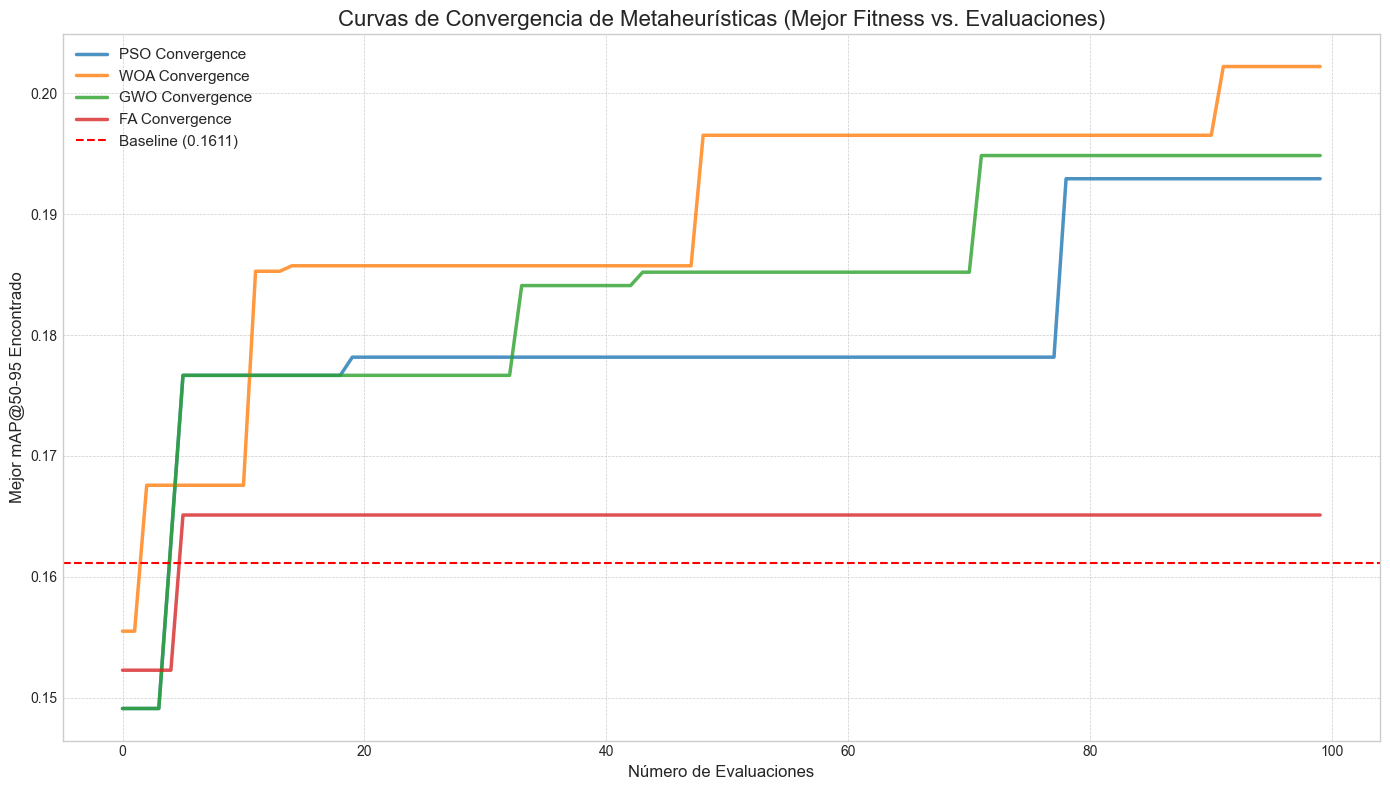

In [11]:
#===================================================================
# Análisis de Resultados de la Ejecución Principal (10x10x5)
#===================================================================

# --- CONFIGURACIÓN ---
algorithms_to_test = ["PSO", "WOA", "GWO", "FA"]
baseline_score = 0.1611 # Reemplaza con el valor exacto de tu ejecución

# Diccionario para guardar los resultados finales (copiados de tu resumen)
final_results = {
    "PSO": {"score": 0.1929, "config": {"lr0": 0.003062, "momentum": 0.925514, "weight_decay": 0.000575, "hsv_s": 0.245831, "scale": 0.488374, "translate": 0.066696}},
    "WOA": {"score": 0.2022, "config": {"lr0": 0.001987, "momentum": 0.850000, "weight_decay": 0.000286, "hsv_s": 0.298415, "scale": 0.385286, "translate": 0.093659}},
    "GWO": {"score": 0.1949, "config": {"lr0": 0.001360, "momentum": 0.850000, "weight_decay": 0.000914, "hsv_s": 0.357341, "scale": 0.122418, "translate": 0.200000}},
    "FA":  {"score": 0.1651, "config": {"lr0": 0.000721, "momentum": 0.905124, "weight_decay": 0.000259, "hsv_s": 0.594327, "scale": 0.033305, "translate": 0.191797}}
}


# --- 1. Mostrar Tabla Comparativa Final ---
print("="*60)
print("--- RESUMEN FINAL DEL EXPERIMENTO (10x10x5) ---")
print("="*60)

print(f"\\nBaseline mAP50-95 (Default): {baseline_score:.4f}")
print("-" * 35)

# Crear un DataFrame para una visualización más bonita
summary_data = []
for algo, result in final_results.items():
    improvement = ((result['score'] - baseline_score) / baseline_score) * 100
    summary_data.append([algo, result['score'], f"{improvement:.2f}%"])

summary_df = pd.DataFrame(summary_data, columns=['Algoritmo', 'Mejor mAP@50-95', 'Mejora vs. Baseline'])
print(summary_df.to_string(index=False))


# --- 2. Mostrar la Mejor Configuración General ---
best_overall_algo = max(final_results, key=lambda k: final_results[k]['score'])
best_overall_result = final_results[best_overall_algo]

print("\\n" + "="*60)
print(f"--- MEJOR CONFIGURACIÓN ENCONTRADA (GANADOR: {best_overall_algo}) ---")
print("="*60)
for key, value in best_overall_result['config'].items():
    print(f"  {key}: {value:.6f}")


# --- 3. Generar Gráficos de Convergencia ---
print("\\n\\n" + "="*60)
print("--- GRÁFICOS DE CONVERGENCIA ---")
print("="*60)
analyze_and_plot_results(algorithms_to_test, baseline_score)